In [1]:
# Set up code for the outsourcer's problem with on-the-job search
# Builds on On the Job Search file
# This block of code separates v_grid of hiring from v_hat_grid of outsourcing
# Try to use secant method to update guess

import numpy as np
import matplotlib.pyplot as plt
# import quantecon as qe
from numba import njit, int64, float64
from interpolation import interp
from IPython.core.debugger import set_trace
from scipy.optimize import minimize, basinhopping
import copy
import pandas as pd
import os
import inspect

# Set plot text sizes here
small_size = 13.0
medium_size = 18.0

plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)     # fontsize of the axes title
plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=medium_size)   # legend fontsize

# Change default linewidth and markersize
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['lines.markersize'] = 10

class OutsourcingOnJob:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate at firm
    delta_o is job loss rate at outsourcer
    delta_hat is firm destruction rate of outsourcing firm <= delta
    xi is probability of searching on-the-job
    eta is workers bargaining power with firm
    eta_o is workers bargaining power with outsourcer
    phi is effectiveness of matching function
    alpha is elasticity of matching function
    y_min, y_max, y_grid_size determine firm productivity grid
    rm is to Reimann Sum approximate firm integrals
    o_min, o_max, o_grid_size determine outsourcer productivity grid
    rm_o is to Reimann Sum approximate outsourcer integrals
    gamma is steepness of marginal cost, 
    c_grid is level of entry cost
    gamma_o is steepness of marginal cost for outsourcers 
    c_o_grid is level of cost
    hp is 1 if b represents home production (free), 0 if unemployment benefit (paid with taxes on workers)
    tau_grid is optional per vacancy transfers/taxes for hiring firms
    tau_hat_grid is optional per vacancy transfers/taxes for outsourcing firms
    tau_o_grid is optional per vacancy transfers/taxes for outsourcers
    tau_R_grid is optional switching transfers/taxes for workers
    tau_R_o_grid is optional switching transfers/taxes for workers going to outsourcers
    """
    def __init__(
        self, B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi, alpha,
        y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
        gamma, gamma_o, c_grid, c_o_grid, hp=1,
        tau_grid=None, tau_hat_grid=None, tau_o_grid=None, tau_R_grid=None, tau_R_o_grid=None
    ):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.c_grid = B, b, delta, eta, gamma, c_grid
        self.delta_hat, self.eta_o, self.gamma_o, self.c_o_grid = delta_hat, eta_o, gamma_o, c_o_grid 
        self.xi, self.delta_o = xi, delta_o
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid_size, self.y_min, self.y_max = y_grid_size, y_min, y_max    
        self.rm = (y_max - y_min) / y_grid_size
        
        self.o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint = False)
        self.o_grid_size, self.o_min, self.o_max = o_grid_size, o_min, o_max    
        self.rm_o = (o_max - o_min) / o_grid_size
        
        self.phi, self.alpha = phi, alpha
        
        self.hp = hp
        
        if tau_grid is None:
            self.tau_grid = np.zeros(y_grid_size)
        else:
            self.tau_grid = tau_grid
            
        if tau_hat_grid is None:
            self.tau_hat_grid = np.zeros(y_grid_size)
        else:
            self.tau_hat_grid = tau_hat_grid
            
        if tau_o_grid is None:
            self.tau_o_grid = np.zeros(o_grid_size)
        else:
            self.tau_o_grid = tau_o_grid
            
        if tau_R_grid is None:
            self.tau_R_grid = np.zeros(y_grid_size)
        else:
            self.tau_R_grid = tau_R_grid
            
        if tau_R_o_grid is None:
            self.tau_R_o_grid = np.zeros(o_grid_size)
        else:
            self.tau_R_o_grid = tau_R_o_grid
        
# Useful to have njit-ed functions to find max absolute error and percent difference
@njit()
def max_absolute_error(x, y):
    return np.max(np.abs(x - y))

@njit()
def percent_diff(x, y):
    return (x - y) / y * 100

# Set up neccesary functions
def operator_factory(ooj):
    
    r, b, delta, eta, gamma, c_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.c_grid
    delta_hat, eta_o, gamma_o, c_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.c_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    phi, alpha = ooj.phi, ooj.alpha
    hp = ooj.hp
    tau_grid, tau_hat_grid, tau_o_grid = ooj.tau_grid, ooj.tau_hat_grid, ooj.tau_o_grid
    tau_R_grid, tau_R_o_grid = ooj.tau_R_grid, ooj.tau_R_o_grid
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    
    @njit()
    def q(theta):
        return min(phi * theta**(-alpha), 1)
    
    @njit()
    def ell(theta):
        return min(phi * theta**(1 - alpha), 1)
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid, tau_grid=0):
        return c_grid * v_grid**gamma - v_grid * tau_grid
    
    @njit()
    def c(v_grid, tau_grid=0):
        return c_grid * gamma * v_grid**(gamma - 1) - tau_grid

    @njit()
    def c_inv(cost_grid, tau_grid=0):
        return (np.maximum(cost_grid + tau_grid, 0) / (gamma * c_grid))**(1 / (gamma - 1))
        
    # Do the same for outsourcers
    @njit()
    def C_o(v_o_grid, tau_o_grid=0):
        return c_o_grid * v_o_grid**gamma_o - v_o_grid * tau_o_grid

    @njit()
    def c_o(v_o_grid, tau_o_grid=0):
        return c_o_grid * gamma_o * v_o_grid**(gamma_o - 1) - tau_o_grid

    @njit()
    def c_o_inv(cost_grid, tau_o_grid=0):
        return (np.maximum(cost_grid + tau_o_grid, 0) / (gamma_o * c_o_grid))**(1 / (gamma_o - 1))
    
    # Given a continuous y_hat, find the nearest y_i
    @njit()
    def find_y_i(y_hat):
        return np.argmin(np.abs(y_hat - y_grid))
    
    # Given v_grid, v_o_grid, n_grid,
    # n_o_grid, y_hat, R_grid, R_o_grid, and p, find
    # Firms who directly hire hire vs those that outsource out
    # Market tightness theta
    # Distribution of vacanices F and F_o
    # Distribution of job seekers G and G_o
    # Probability of worker leaving D and D_o
    # Wages w and w_o
    @njit()
    def make_grids(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):    
        
        y_i = find_y_i(y_hat)
        
        # Useful to have cumulative sums for hiring firms (below y_hat) and outsourcers
        v_temp = np.copy(v_grid)
        v_temp[y_i:] = 0
        n_temp = np.copy(n_grid)
        n_temp[y_i:] = 0
        
        cum_v = np.cumsum(v_temp * rm)
        cum_v_o = np.cumsum(v_o_grid * rm_o)
        cum_n = np.cumsum(n_temp * rm)
        cum_n_o = np.cumsum(n_o_grid * rm_o)
        
        # Define aggregate populations (make sure all exist)
        n_sum = cum_n[-1] + cum_n_o[-1]
        u = max(1 - n_sum, 1e-9)
        v = max(cum_v[-1], 1e-9)
        v_o = max(cum_v_o[-1], 1e-9) 
        v_sum = v + v_o
        pi = v_o / v_sum
        s = u + xi_bar * cum_n[-1] + xi_bar_o * cum_n_o[-1]
        theta = v_sum / s
        
        # Calculate distributions 
        # F is distribution of vacancies (include firms above y_hat in cdf as 1)
        F_grid = cum_v / v
        f_grid = v_temp / v
        
        F_o_grid = cum_v_o / v_o
        f_o_grid = v_o_grid / v_o
        
        # G is distribution of job seekers (include firms above y_hat as bigger than all y firms)        
        G_grid = (u + (xi_bar * cum_n + xi_bar_o * cum_n_o[R_grid])) / s
        G_o_grid = (u + (xi_bar * cum_n[R_o_grid] + xi_bar_o * cum_n_o)) / s
        
        # D is probability a worker finds a better job
        D_grid = 1 - (1 - pi) * F_grid - pi * F_o_grid[R_grid]
        D_o_grid = 1 - (1 - pi) * F_grid[R_o_grid] - pi * F_o_grid 
        
        # What is the value of search?
        f_tot = c(v_grid, tau_grid) / G_grid * f_grid * rm
        o_tot = c_o(v_o_grid, tau_o_grid) / G_o_grid * f_o_grid * rm_o
        i_cum_f = np.cumsum(f_tot[::-1])[::-1]
        i_cum_o = np.cumsum(o_tot[::-1])[::-1]
        
        # For unemployed
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f[0]
        out = eta_o / (1 - eta_o) * pi * i_cum_o[0]
        Gamma_U = ell(theta) / q(theta) * (firm + out)
        
        # For employed at a firm
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f
        out = eta_o / (1 - eta_o) * pi * i_cum_o[R_grid]
        Gamma_grid = ell(theta) / q(theta) * (firm + out)
        
        # For employed at an outsourcer
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f[R_o_grid]
        out = eta_o / (1 - eta_o) * pi * i_cum_o
        Gamma_o_grid = ell(theta) / q(theta) * (firm + out)
        
        # Let nu be the multiplier on outside option b. Depends on interpretation of b (1 or 1/(1-u))
        # This tends to be large when n is small, so cap it at 2
        nu = min((1 - hp * u) / (1 - u), 2)
        
        # Find wages
        w_grid = eta * y_grid + (1 - eta) * (nu * b + Gamma_U - xi_bar * Gamma_grid) 
        w_o_grid = eta_o * p * o_grid + (1 - eta_o) * (nu * b + Gamma_U - xi_bar_o * Gamma_o_grid) 
        
        return (
            theta, G_grid, G_o_grid, D_grid, D_o_grid, 
            Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid, nu
        )
    
    # Given v_grid, v_o_grid, n_grid, J_out, y_zero,
    # n_o_grid, y_hat, R_grid, R_o_grid, and p, find new values
    @njit()
    def iterate(v_grid, v_o_grid, n_grid, n_o_grid, J_out, y_zero, y_hat, R_grid, R_o_grid, p):
        
        (theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid, nu) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)
        
        # Value of hiring firms (outsourcing firm value does not depend on changing parameters)
        J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + xi_bar * ell(theta) * D_grid)
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        y_diff = np.argmin(np.abs(J_out - tau_grid - J_hire + tau_hat_grid))
        y_hat_new = y_grid[max(y_diff, y_zero)]
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_grid_new = c_inv(J_hire, tau_grid)
        
        # Outsourcers
        O = q(theta) * G_o_grid * (o_grid * p - w_o_grid) / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid)
        v_o_grid_new = c_o_inv(O, tau_o_grid)
        
        # Update size
        # Hiring firms
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
        
        # Outsourcers
        n_o_grid_new = (
            (1 - delta_o) * (1 - xi * ell(theta) * D_o_grid) * n_o_grid + q(theta) * G_o_grid * v_o_grid_new
        )
               
        # Update R_grid and R_o_grid by comparing W - U to W_o - U.
        # Note that R_grid is defined for all firms, even those above 
        # y_hat, and R_o_grid might be indifferent to a firm above y_hat that doesn't hire
        # Value of employment at a firm (minus value of unemployment)
        W_min_U = (
            (1 + r) * (w_grid - nu * b - Gamma_U + xi_bar * Gamma_grid)
            / (r + delta + xi_bar * ell(theta) * D_grid) + tau_R_grid
        )
        
        # Value of employment at an outsourcer (minus value of unemployment)
        W_o_min_U = (
            (1 + r) * (w_o_grid - nu * b - Gamma_U + xi_bar_o * Gamma_o_grid)
            / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid) + tau_R_o_grid
        )

        # Use these and search sorted to find new indecision rules (make sure not above all)
        R_grid_new = np.minimum(np.searchsorted(W_o_min_U, W_min_U), o_grid_size - 1)
    
        R_o_grid_new = np.minimum(np.searchsorted(W_min_U, W_o_min_U), y_grid_size - 1)
        
        return v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new
    
    # Given n_hat_grid, n_o_grid, and y_hat find excess demand for outsourcing 
    @njit()
    def QD_QS_ED(n_hat_grid, n_o_grid, y_hat):
        y_i = find_y_i(y_hat)
        QD = np.sum(n_hat_grid[y_i:] * rm) 
        QS = np.sum(n_o_grid * o_grid * rm_o)
        ED = QD - QS
        return QD, QS, ED

    @njit()
    def solve_given_p(
        p, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
        n_o_grid, y_hat, R_grid, R_o_grid, tol, max_iter, slow
    ):

        # Set up initial loop parameters
        i = 0
        err = tol + 1    
        
        # Given p, we can already solve for optimal outsourcing        
        J_out = (y_grid - p) / (r + delta_hat)
        # Make sure J_out is non_negative at y_hat
        y_zero = np.argmin(np.abs(J_out + tau_hat_grid))
        v_hat_grid_new = c_inv(J_out, tau_hat_grid)
        n_hat_grid_new = v_hat_grid_new / delta_hat

        # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, y_hat, R_grid, and R_o_grid
        while i < max_iter and err > tol:
            (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new,
             y_hat_new, R_grid_new, R_o_grid_new) = iterate(
                v_grid, v_o_grid, n_grid, n_o_grid, J_out, y_zero, y_hat, R_grid, R_o_grid, p
            )
            err_v_t = max_absolute_error(v_grid_new, v_grid)
            err_v_o = max_absolute_error(v_o_grid_new, v_o_grid)
            err_n_t = max_absolute_error(n_grid_new, n_grid)
            err_n_o = max_absolute_error(n_o_grid_new, n_o_grid)
            err = max(err_v_t, err_v_o, err_n_t, err_n_o)
            i += 1

            v_grid = slow * v_grid_new + (1 - slow) * v_grid
            v_o_grid = slow * v_o_grid_new + (1 - slow) * v_o_grid
            n_grid = slow * n_grid_new + (1 - slow) * n_grid
            n_o_grid = slow * n_o_grid_new + (1 - slow) * n_o_grid
            y_hat = slow * y_hat_new + (1 - slow) * y_hat 

            # To slowly adjust R_grid, and R_o_grid (which are indexes), instead 
            # add/subtract by 1 if greater/less 
            R_grid = R_grid + 1 * (R_grid_new > R_grid) - 1 * (R_grid_new < R_grid)
            R_o_grid = R_o_grid + 1 * (R_o_grid_new > R_o_grid) - 1 * (R_o_grid_new < R_o_grid) 

        return (
            v_grid_new, v_hat_grid_new, v_o_grid_new, n_grid_new,
            n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new
        )        
    
    return solve_given_p, iterate, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell 

# Find p
def find_p(
    ooj, guess, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i, verbose=True, print_skip=5
):
    
    solve_given_p, _, QD_QS_ED, _, _, _, _, _, _, _, _, _, _ = operator_factory(ooj)
    
    # Solve ED_1 and ED_2 given p_1 and p_2
    
    # Initial guess
    v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid = guess
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
    
    # Find excess_demand for p_1 and p_2
    for p in [p_1, p_2]:
        
#         qe.tic()

        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid) = solve_given_p(
            p, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
            n_o_grid, y_hat, R_grid, R_o_grid, tol=tol_i, max_iter=max_iter_i, slow=slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        
#         qe.toc()
        
        if p == p_2:
            ED_2 = ED
        else:
            ED_1 = ED
        
        if verbose:
            print(f'Excess Demand for price {p} is {ED:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
            
#         set_trace()
        
    while err > tol and j < max_iter:
        
#         qe.tic()
        
        # Update p 
        p = (p_2 * ED_1 - p_1 * ED_2) / (ED_1 - ED_2)
                
        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid) = solve_given_p(
            p, v_grid, v_hat_grid, v_o_grid, n_grid,
            n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol_i, max_iter_i, slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        err = np.abs(ED)
        
#         qe.toc()
        
        # Go to next iteration
        p_2, ED_2 = np.copy(p_1), np.copy(ED_1)
        p_1, ED_1 = np.copy(p), np.copy(ED)
            
        if verbose and j % print_skip == 0:
            print(
                f'Excess Demand at iter {j} is {ED:.4f}; price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
                f"y_hat is {y_hat:.4f}"
            )
            
        j += 1
        
    
    if j < max_iter:
        print(f'Converged in {j} iterations, Excess Demand is {ED:.4f};',
              f'price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
    if j == max_iter:
        print(f'Failed to Converge. Excess Demand is {ED:.4f}; price is {p:.4f};',
              f'QS is {QS:.4f}; QD is {QD:.4f}')
        
    return v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p

# From LS, take the model without outsourcers
# Set up neccesary functions
def ls_operator_factory(ooj):
    
    r, b, delta, eta, gamma, c_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.c_grid
    phi, alpha, xi = ooj.phi, ooj.alpha, ooj.xi
    hp = ooj.hp
    tau_grid = ooj.tau_grid
    xi_bar = xi * (1 - delta)
    
    y_grid, y_grid_size, rm, y_max = ooj.y_grid, ooj.y_grid_size, ooj.rm, ooj.y_max   
    
    # Take cost and matching from operator_factory
    _, _, _, _, _, C, c, c_inv, _, _, _, q, ell = operator_factory(ooj)
    
    # Given v_grid, and n_grid find the distribution of workers
    # Including market tightness theta and distribution of vacancies f_grid
    @njit()
    def ls_worker_dist(v_grid, n_grid):
        
        # Define aggregate populations (make sure all exist)
        n = max(np.sum(n_grid * rm), 1e-9)
        u = max(1 - n, 1e-9)
        v = max(np.sum(v_grid * rm), 1e-9)
        s = u + xi_bar * n
        
        # Wage depends on interpretation of b (either 1 or 1/(1-u))
        # This can get big when 1-u is small, so cap at 2
        nu = min((1 - hp * u) / (1 - u), 2)
        
        # Calculate theta 
        theta = v / s
        
        # f is pdf of vacancies 
        F_grid = np.cumsum(v_grid * rm) / v
        f_grid = v_grid / v
        
        # G_grid is share of jobseekers at less productive firms
        G_grid = (u + xi_bar * np.cumsum(n_grid * rm)) / s
        
        # D_grid is probability the worker leaves for a better job
        D_grid = 1 - F_grid
        
        return theta, nu, f_grid, G_grid, D_grid
    
    # Solve decentralized problem
    # Given v_grid, and n_grid find
    # Market tightness theta and Wages w
    @njit()
    def ls_make_grids(v_grid, n_grid):    
        
        # Get distribution of workers
        theta, nu, f_grid, G_grid, D_grid = ls_worker_dist(v_grid, n_grid)
        
        # What is the value of search?        
        f_tot = c(v_grid, tau_grid) / G_grid * f_grid * rm
        i_cum_f = np.cumsum(f_tot[::-1])[::-1]
        Gamma_grid = ell(theta) / q(theta) * eta / (1 - eta) * i_cum_f
        Gamma_U = Gamma_grid[0]
        
        # Find wage
        w_grid = eta * y_grid + (1 - eta) * (nu * b + Gamma_U - xi_bar * Gamma_grid)
        
        return theta, w_grid, Gamma_U, Gamma_grid, G_grid, D_grid
    
    # Given v_grid and n_grid find new values
    @njit()
    def ls_iterate(v_grid, n_grid):
        
        theta, w_grid, Gamma_U, Gamma_grid, G_grid, D_grid = ls_make_grids(v_grid, n_grid)
        
        # Value of firm
        J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + xi_bar * ell(theta) * D_grid)
        
        # Update vacancies
        v_grid_new = c_inv(J_hire, tau_grid)
        
        # Update size
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
                       
        return v_grid_new, n_grid_new
    
    return ls_iterate, ls_make_grids

# Solve model
def ls_solve_model(ooj, guess, tol, max_iter, slow, verbose=False, print_skip=1e4):
    
    ls_iterate, _ = ls_operator_factory(ooj)
    
    v_grid, n_grid = guess

    # Set up initial loop parameters
    i = 0
    err = tol + 1    

    # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, and y_hat
    while i < max_iter and err > tol:
        v_grid_new, n_grid_new = ls_iterate(v_grid, n_grid)
        err_v = max_absolute_error(v_grid_new, v_grid)
        err_n = max_absolute_error(n_grid_new, n_grid)
        err = max(err_v, err_n)

        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        
        if verbose and i % print_skip == 0:
            print(f"Error at iter {i} is {err:.4f}") 
        
        i += 1
    
    if i < max_iter:
        print(f'Converged in {i} iterations')
    if i == max_iter:
        print(f'Failed to Converge.')

    return v_grid_new, n_grid_new

# Create a factory to solve the Planner's problem with and without outsourcing
def operator_factory_p(ooj):
    
    r, b, delta, eta, gamma, c_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.c_grid
    B = ooj.B
    delta_hat, eta_o, gamma_o, c_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.c_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    phi, alpha = ooj.phi, ooj.alpha
    hp = ooj.hp
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    y_grid, y_grid_size, rm, y_max = ooj.y_grid, ooj.y_grid_size, ooj.rm, ooj.y_max
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    
    # import functions from main factory
    (solve_given_p, iterate, QD_QS_ED, make_grids, find_y_i,
     C, c, c_inv, C_o, c_o, c_o_inv, q, ell) = operator_factory(ooj)
    
    # Use estimates of q_p and ell_p to insure smoothness around q/l == 1
    A = 50 # This is how close estimate is (increases in A)
    
    # Planner's problem also uses derivatives
    @njit()
    def q_p(theta):
        exp = np.exp(A * (phi * theta**(-alpha) - 1))
        return -alpha * phi * theta**(-alpha - 1) / (1 + exp)
    
    @njit()
    def ell_p(theta):
        exp = np.exp(A * (phi * theta**(1 - alpha) - 1))             
        return (1 - alpha) * phi * theta**(-alpha) / (1 - exp)
    
    # Given v_grid, n_grid, and lam_grid find
    # market tightness theta
    # position distribution G and vacancy distribution D
    # vacancy and position externalities
    @njit()
    def ls_make_grids_p(v_grid, n_grid, lam_grid):
    
        # Define aggregate populations (make sure all exist)
        n = max(np.sum(n_grid * rm), 1e-9)
        u = max(1 - n, 1e-9)
        v = max(np.sum(v_grid * rm), 1e-9)
        s = u + xi_bar * n
        
        # Calculate theta 
        theta = v / s
        
        # f is pdf of vacancies 
        F_grid = np.cumsum(v_grid * rm) / v
        # D_grid is probability the worker leaves for a better job
        D_grid = 1 - F_grid
        
        # G_grid is share of jobseekers at less productive firms
        G_grid = (u + xi_bar * np.cumsum(n_grid * rm)) / s     
        
        # Use lamda to find vacancy externality
        # Three temp functions needed
        temp_1 = lam_grid * (1 - D_grid) * n_grid * rm
        temp_1_sum = np.cumsum(temp_1)
        temp_2 = lam_grid * D_grid * n_grid * rm
        temp_2_sum = np.cumsum(temp_2[::-1])[::-1]
        temp = xi_bar * ell(theta) * (temp_1_sum - temp_2_sum) / theta
        
        vac_sum = np.sum(lam_grid * G_grid * v_grid * rm)
        pos_sum = xi_bar * np.sum(lam_grid * D_grid * n_grid * rm)
        
        common_temp = q_p(theta) * vac_sum - ell_p(theta) * pos_sum
        
        vac_ext = B / s * (common_temp - temp)
        
        # Find position externality
        # Need three temp functions for one of integrals
        temp_3 = lam_grid * (1 - (1 - xi_bar) * G_grid) * v_grid * rm
        temp_3_sum = np.cumsum(temp_3)
        temp_4 = lam_grid * (1 - xi_bar) * (1 - G_grid) * v_grid * rm
        temp_4_sum = np.cumsum(temp_4[::-1])[::-1]
        temp_b = q(theta) * (temp_3_sum + temp_4_sum)
        
        pos_ext = ((1 - xi_bar) * theta * common_temp - temp_b) / s
        
#         print(theta, vac_ext, pos_ext)
        
        return theta, G_grid, D_grid, vac_ext, pos_ext


    @njit()
    def ls_iterate_p(v_grid, n_grid, lam_grid):
            
        theta, G_grid, D_grid, vac_ext, pos_ext = ls_make_grids_p(v_grid, n_grid, lam_grid)
            
        # Value of firms
        J_hire = B * lam_grid * G_grid * q(theta) + vac_ext
        
        # Update vacancies
        v_grid_new = c_inv(J_hire)
        
        # Update size
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
                         
        # Update lambda
        lam_grid_new = ((1 + r) * (y_grid - hp * b) + pos_ext) / (r + delta + xi_bar * ell(theta) * D_grid)
                       
        return v_grid_new, n_grid_new, lam_grid_new
    
    # Given v_grid, v_o_grid, n_grid,
    # n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid and rho, find
    # Firms who directly hire hire vs those that outsource out
    # Market tightness theta
    # Distribution of vacanices F and F_o
    # Distribution of job seekers G and G_o
    # Probability of worker leaving D and D_o
    # Externalities from vacancies and size of hiring firms and outsourcers
    @njit()
    def make_grids_p(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, 
                     lam_grid, iota_grid, rho):    
        
        y_i = find_y_i(y_hat)
        
        # Useful to have cumulative sums for hiring firms (below y_hat) and outsourcers
        v_temp = np.copy(v_grid)
        v_temp[y_i:] = 0
        n_temp = np.copy(n_grid)
        n_temp[y_i:] = 0
        
        cum_v = np.cumsum(v_temp * rm)
        cum_v_o = np.cumsum(v_o_grid * rm_o)
        cum_n = np.cumsum(n_temp * rm)
        cum_n_o = np.cumsum(n_o_grid * rm_o)
        
        # Define aggregate populations (make sure all exist)
        n_sum = cum_n[-1] + cum_n_o[-1]
        u = max(1 - n_sum, 1e-9)
        v = max(cum_v[-1], 1e-9)
        v_o = max(cum_v_o[-1], 1e-9) 
        v_sum = v + v_o
        pi = v_o / v_sum
        s = u + xi_bar * cum_n[-1] + xi_bar_o * cum_n_o[-1]
        theta = v_sum / s
        
        # Calculate distributions 
        # F is distribution of vacancies (include firms above y_hat in cdf as 1)
        F_grid = cum_v / v
        f_grid = v_temp / v
        
        F_o_grid = cum_v_o / v_o
        f_o_grid = v_o_grid / v_o
        
        # G is distribution of job seekers (include firms above y_hat as bigger than all y firms)        
        G_grid = (u + (xi_bar * cum_n + xi_bar_o * cum_n_o[R_grid])) / s
        G_o_grid = (u + (xi_bar * cum_n[R_o_grid] + xi_bar_o * cum_n_o)) / s
        
        # D is probability a worker finds a better job
        D_grid = 1 - (1 - pi) * F_grid - pi * F_o_grid[R_grid]
        D_o_grid = 1 - (1 - pi) * F_grid[R_o_grid] - pi * F_o_grid 
        
        # There are two externalities the Planner accounts for (for firms and outsourcers), 
        # one is for sending a vacancy to the matching function 
        # Second is for having a worker that cannot be used elsewhere
        # Calculate both (slightly different for firms vs outsourcers)
        
        # First, vacancy externality
        temp_1_a = (1 - D_grid) * lam_grid * n_temp * rm
        temp_1_a_sum = np.cumsum(temp_1_a)
        temp_1_b = D_grid * lam_grid * n_temp * rm
        temp_1_b_sum = np.cumsum(temp_1_b[::-1])[::-1]
        temp_1 = ell(theta) * xi_bar * (temp_1_a_sum - temp_1_b_sum)
        temp_1_o = ell(theta) * xi_bar * (temp_1_a_sum - temp_1_b_sum)[R_o_grid]
        
        temp_2_a = (1 - D_o_grid) * iota_grid * n_o_grid * rm_o
        temp_2_a_sum = np.cumsum(temp_2_a)
        temp_2_b = D_o_grid * iota_grid * n_o_grid * rm_o
        temp_2_b_sum = np.cumsum(temp_2_b[::-1])[::-1]
        temp_2 = ell(theta) * xi_bar_o * (temp_2_a_sum - temp_2_b_sum)[R_grid]
        temp_2_o = ell(theta) * xi_bar_o * (temp_2_a_sum - temp_2_b_sum)
        
        vac_sum = np.sum(lam_grid * G_grid * v_temp * rm) + np.sum(iota_grid * G_o_grid * v_o_grid * rm_o)
        pos_sum = (xi_bar * np.sum(lam_grid * D_grid * n_temp * rm) 
                   + xi_bar_o * np.sum(iota_grid * D_o_grid * n_o_grid * rm_o))
        
        common_temp = theta * (q_p(theta) * vac_sum - ell_p(theta) * pos_sum)
        
        vac_ext = B * (common_temp - temp_1 - temp_2) / v_sum
        vac_ext_o = B * (common_temp - temp_1_o - temp_2_o) / v_sum
        
        # Next position externality
        temp_3_a = (1 - (1 - xi_bar) * G_grid) * lam_grid * v_temp * rm
        temp_3_a_sum = np.cumsum(temp_3_a)
        temp_3_b = (1 - xi_bar) * (1 - G_grid) * lam_grid * v_temp * rm
        temp_3_b_sum = np.cumsum(temp_3_b[::-1])[::-1]
        temp_3 = temp_3_a_sum + temp_3_b_sum
        
        temp_3_o_a = (1 - (1 - xi_bar_o) * G_grid) * lam_grid * v_temp * rm
        temp_3_o_a_sum = np.cumsum(temp_3_o_a)
        temp_3_o_b = (1 - xi_bar_o) * (1 - G_grid) * lam_grid * v_temp * rm
        temp_3_o_b_sum = np.cumsum(temp_3_o_b[::-1])[::-1]
        temp_3_o = (temp_3_o_a_sum + temp_3_o_b_sum)[R_o_grid]
        
        temp_4_a = (1 - (1 - xi_bar) * G_o_grid) * iota_grid * v_o_grid * rm_o
        temp_4_a_sum = np.cumsum(temp_4_a)
        temp_4_b = (1 - xi_bar) * (1 - G_o_grid) * iota_grid * v_o_grid * rm_o
        temp_4_b_sum = np.cumsum(temp_4_b[::-1])[::-1]
        temp_4 = (temp_4_a_sum + temp_4_b_sum)[R_grid]
        
        temp_4_o_a = (1 - (1 - xi_bar_o) * G_o_grid) * iota_grid * v_o_grid * rm_o
        temp_4_o_a_sum = np.cumsum(temp_4_o_a)
        temp_4_o_b = (1 - xi_bar_o) * (1 - G_o_grid) * iota_grid * v_o_grid * rm_o
        temp_4_o_b_sum = np.cumsum(temp_4_o_b[::-1])[::-1]
        temp_4_o = temp_4_o_a_sum + temp_4_o_b_sum
        
        pos_ext = ((1 - xi_bar) * common_temp - q(theta) * (temp_3 + temp_4)) / s
        pos_ext_o = ((1 - xi_bar_o) * common_temp - q(theta) * (temp_3_o + temp_4_o)) / s
        
        return theta, G_grid, G_o_grid, D_grid, D_o_grid, vac_ext, vac_ext_o, pos_ext, pos_ext_o
    
    # Given v_grid, v_o_grid, n_grid, J_out, y_zero,
    # n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid, and rho, find new values
    @njit()
    def iterate_p(v_grid, v_o_grid, n_grid, n_o_grid, J_out, y_zero, y_hat, R_grid, R_o_grid,
                lam_grid, iota_grid, rho):
        
        # Find theta and determine if q/ell theta = 1
        y_i = find_y_i(y_hat)
        
        theta, G_grid, G_o_grid, D_grid, D_o_grid, vac_ext, vac_ext_o, pos_ext, pos_ext_o = make_grids_p(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid, rho)
        
        # Value of hiring firms (outsourcing firm value does not depend on changing parameters)
        J_hire = B * q(theta) * G_grid * lam_grid + vac_ext
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        y_diff = np.argmin(np.abs(J_out - J_hire))
        y_hat_new = y_grid[max(y_diff, y_zero)]
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_grid_new = c_inv(J_hire)
        
        # Outsourcers
        v_o_grid_new = c_o_inv(B * q(theta) * G_o_grid * iota_grid + vac_ext_o)      

        # Update size
        # Hiring firms
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
        
        # Outsourcers
        n_o_grid_new = (
            (1 - delta_o) * (1 - xi * ell(theta) * D_o_grid) * n_o_grid + q(theta) * G_o_grid * v_o_grid_new
        )
        
        # Update lam_grid and iota_grid
        lam_grid_new = ((1 + r) * (y_grid - hp * b) + pos_ext) / (r + delta + xi_bar * ell(theta) * D_grid)
        iota_grid_new = (
            ((1 + r) * (rho * o_grid - hp * b) + pos_ext_o) / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid)
        )
               
        # Update R_grid and R_o_grid by comparing lambda and iota
        # Note that R_grid is defined for all firms, even those above 
        # y_hat, and R_o_grid might be indifferent to a firm above y_hat that doesn't hire        
        # Use these and search sorted to find new indecision rules (make sure not above all)        
        R_grid_new = np.minimum(np.searchsorted(iota_grid, lam_grid), o_grid_size - 1)
    
        R_o_grid_new = np.minimum(np.searchsorted(lam_grid, iota_grid), y_grid_size - 1)
        
        return (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new,
               lam_grid_new, iota_grid_new)    
    
    # Solve model give a price rho
    @njit()
    def solve_given_rho(
        rho, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
        n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid, tol, max_iter, slow
    ):
        
        # Given rho, we can already solve for optimal outsourcing  
        J_out = (y_grid - rho) / (r + delta_hat)
        # Make sure J_out is non_negative at y_hat
        y_zero = np.argmin(np.abs(J_out))
        v_hat_grid_new = c_inv(J_out)
        n_hat_grid_new = v_hat_grid_new / delta_hat
        
        # Run model once to update lam_grid and iota_grid (otherwise will return
        # previous solution)
        (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new,
         y_hat_new, R_grid_new, R_o_grid_new, lam_grid_new, iota_grid_new) = iterate_p(
            v_grid, v_o_grid, n_grid, n_o_grid, J_out, y_zero, y_hat, R_grid, R_o_grid,
            lam_grid, iota_grid, rho
        )
        
        lam_grid = slow * lam_grid_new + (1 - slow) * lam_grid
        iota_grid = slow * iota_grid_new + (1 - slow) * iota_grid

        # Reset loop
        i = 0
        err = tol + 1 

        # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, y_hat, R_grid, and R_o_grid
        while i < max_iter and err > tol:            
            (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new,
             y_hat_new, R_grid_new, R_o_grid_new, lam_grid_new, iota_grid_new) = iterate_p(
                v_grid, v_o_grid, n_grid, n_o_grid, J_out, y_zero, y_hat, R_grid, R_o_grid,
                lam_grid, iota_grid, rho
            )
            err_v_t = max_absolute_error(v_grid_new, v_grid)
            err_v_o = max_absolute_error(v_o_grid_new, v_o_grid)
            err_n_t = max_absolute_error(n_grid_new, n_grid)
            err_n_o = max_absolute_error(n_o_grid_new, n_o_grid)
            err = max(err_v_t, err_v_o, err_n_t, err_n_o)
            i += 1

            v_grid = slow * v_grid_new + (1 - slow) * v_grid
            v_o_grid = slow * v_o_grid_new + (1 - slow) * v_o_grid
            n_grid = slow * n_grid_new + (1 - slow) * n_grid
            n_o_grid = slow * n_o_grid_new + (1 - slow) * n_o_grid
            y_hat = slow * y_hat_new + (1 - slow) * y_hat 
            lam_grid = slow * lam_grid_new + (1 - slow) * lam_grid
            iota_grid = slow * iota_grid_new + (1 - slow) * iota_grid

            # To slowly adjust R_grid, and R_o_grid (which are indexes), instead 
            # add/subtract by 1 if greater/less 
            R_grid = R_grid + 1 * (R_grid_new > R_grid) - 1 * (R_grid_new < R_grid)
            R_o_grid = R_o_grid + 1 * (R_o_grid_new > R_o_grid) - 1 * (R_o_grid_new < R_o_grid) 

        return (
            v_grid_new, v_hat_grid_new, v_o_grid_new, n_grid_new, n_hat_grid_new, n_o_grid_new,
            y_hat_new, R_grid_new, R_o_grid_new, lam_grid, iota_grid
        )        
    
    return solve_given_rho, iterate_p, make_grids_p, ls_iterate_p, ls_make_grids_p  

# Solve Planner's Problem
def find_rho(
    ooj, guess, rho_1, rho_2, tol, max_iter, tol_i, max_iter_i, slow_i, verbose=True, print_skip=5
):
    
    _, _, QD_QS_ED, _, _, _, _, _, _, _, _, _, _ = operator_factory(ooj)
    solve_given_rho, _, _, _, _ = operator_factory_p(ooj)
    
    b = ooj.b
    
    # Solve ED_1 and ED_2 given rho_1 and rho_2
    
    # Initial guess
    (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat,
     R_grid, R_o_grid, lam_grid, iota_grid) = guess
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
    
    # Find excess_demand for rho_1 and rho_2
    for rho in [rho_1, rho_2]:

        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid) = solve_given_rho(
            rho, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
            n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid,
            tol=tol_i, max_iter=max_iter_i, slow=slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        
        if ED > 0:
            rho_low = rho
            ED_low = ED            
        else:
            rho_high = rho
            ED_high = ED
        
        if verbose:
            print(f'Excess Demand for rho {rho} is {ED:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
            
    # If both rho_high and rho_low don't exist, quit
    if not ("rho_high" in locals()) or not ("rho_low" in locals()):
        warn = "too high" if ("rho_high" in locals()) else "too low"
        raise ValueError("Error: both guesses of rho are " + warn)            
            
    while err > tol and j < max_iter:
        
        # Update rho (if ED_low/high are 0, set very low)
        if ED_low == 0 and ED_high == 0:
            rho = b
        else:
            rho = (rho_high * ED_low - rho_low * ED_high) / (ED_low - ED_high)
            # Make sure rho not too big or too small (below y_max, above b)
            rho = max(min(rho, y_max), b)
                
        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid) = solve_given_rho(
            rho, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
            n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid,
            tol=tol_i, max_iter=max_iter_i, slow=slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        err = np.abs(ED)
        
        # Go to next iteration
        if ED > 0:
            rho_low = rho
            ED_low = ED            
        else:
            rho_high = rho
            ED_high = ED
            
        if verbose and j % print_skip == 0:
            print(
                f'Excess Demand at iter {j} is {ED:.4f}; rho is {rho:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
                f"y_hat is {y_hat:.4f}"
            )
            
        j += 1
    
    if j < max_iter:
        print(f'Converged in {j} iterations, Excess Demand is {ED:.4f};',
              f'price is {rho:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
    if j == max_iter:
        print(f'Failed to Converge. Excess Demand is {ED:.4f}; price is {rho:.4f};',
              f'QS is {QS:.4f}; QD is {QD:.4f}')
        
    return (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid,
            y_hat, R_grid, R_o_grid, lam_grid, iota_grid, rho)


# Solve LS Planner's
def ls_solve_model_p(ooj, guess, tol, max_iter, slow, verbose=False, print_skip=1e4):
    
    _, _, _, ls_iterate_p, ls_make_grids_p = operator_factory_p(ooj)
    
    v_grid, n_grid, lam_grid = guess

    # Set up initial loop parameters
    i = 0
    err = tol + 1   

    # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, and y_hat
    while i < max_iter and err > tol:
        v_grid_new, n_grid_new, lam_grid_new = ls_iterate_p(v_grid, n_grid, lam_grid)
        err_v = max_absolute_error(v_grid_new, v_grid)
        err_n = max_absolute_error(n_grid_new, n_grid)
        err = max(err_v, err_n)

        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        lam_grid = slow * lam_grid_new + (1 - slow) * lam_grid
        
        if verbose and i % print_skip == 0:
            print(f"Error at iter {i} is {err:.4f}") 
        
        i += 1
    
    if i < max_iter:
        print(f'Converged in {i} iterations')
    if i == max_iter:
        print(f'Failed to Converge.')

    return v_grid_new, n_grid_new, lam_grid_new

# Solve for the per vacancy taxes that allow the Planner to decentralize her decisions. 
# Given Planner's choices, guess an initial tax structure. Use these to find aggregate
# marginal taxes and update guess. Repeat until convergence
def tax_operator(ooj, solution_p, solution_ls_p):
    
    # Unpack solutions (drop _p for convenience)
    (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid,
     y_hat, R_grid, R_o_grid, lam_grid, iota_grid, rho) = solution_p
    
    v_grid_ls, n_grid_ls, lam_grid_ls = solution_ls_p
    
    # Get some functions from main operators
    _, _, _, _, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    _, _, make_grids_p, _, ls_make_grids_p = operator_factory_p(ooj)
    
    B, r, delta, xi = ooj.B, ooj.r, ooj.delta, ooj.xi
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    hp = ooj.hp
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    # Get Planner's choices (Don't Change)
    (theta, G_grid, G_o_grid, D_grid, D_o_grid,
     vac_ext, vac_ext_o, pos_ext, pos_ext_o) = make_grids_p(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid, rho)
    
    y_i = find_y_i(y_hat)
    
    # Useful to have cumulative sums for hiring firms (below y_hat) and outsourcers
    v_temp = np.copy(v_grid)
    v_temp[y_i:] = 0
    n_temp = np.copy(n_grid)
    n_temp[y_i:] = 0

    cum_v = np.cumsum(v_temp * rm)
    cum_v_o = np.cumsum(v_o_grid * rm_o)
    cum_n = np.cumsum(n_temp * rm)
    cum_n_o = np.cumsum(n_o_grid * rm_o)

    # Define aggregate populations (make sure all exist)
    n_sum = cum_n[-1] + cum_n_o[-1]
    u = max(1 - n_sum, 1e-9)
    v = max(cum_v[-1], 1e-9)
    v_o = max(cum_v_o[-1], 1e-9) 
    v_sum = v + v_o
    pi = v_o / v_sum

    # Calculate distributions 
    f_grid = v_temp / v
    f_o_grid = v_o_grid / v_o    
    
    # Update tax guess
    @njit()
    def tax_iterate(tau_grid, tau_o_grid):
        
        # Get value of search    
        f_tot = c(v_temp, tau_grid) / G_grid * f_grid * rm
        o_tot = c_o(v_o_grid, tau_o_grid) / G_o_grid * f_o_grid * rm_o
        i_cum_f = np.cumsum(f_tot[::-1])[::-1]
        i_cum_o = np.cumsum(o_tot[::-1])[::-1]

        # For unemployed
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f[0]
        out = eta_o / (1 - eta_o) * pi * i_cum_o[0]
        Gamma_U = ell(theta) / q(theta) * (firm + out)

        # For employed at a firm
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f
        out = eta_o / (1 - eta_o) * pi * i_cum_o[R_grid]
        Gamma_grid = ell(theta) / q(theta) * (firm + out)

        # For employed at an outsourcer
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f[R_o_grid]
        out = eta_o / (1 - eta_o) * pi * i_cum_o
        Gamma_o_grid = ell(theta) / q(theta) * (firm + out)
        
        # Given previous guesses, these are our new guesses for transfers
        bot = r + delta + xi_bar * ell(theta) * D_grid
        bot_o = r + delta_o + xi_bar_o * ell(theta) * D_o_grid
        
        tau_grid_new = (
            eta * c(v_grid) + (1 - eta) * vac_ext + (1 - eta) * q(theta) * G_grid / bot
            * ((1 - hp) * b / n_sum + Gamma_U - xi_bar * Gamma_grid + B * pos_ext)
        )
        
        tau_o_grid_new = (
            eta_o * c_o(v_o_grid) + (1 - eta_o) * vac_ext_o + (1 - eta_o) * q(theta) * G_o_grid / bot_o
            * ((1 - hp) * b / n_sum + Gamma_U - xi_bar_o * Gamma_o_grid + B * pos_ext_o)
        )
        
        # Can also use this to find worker's job switching transfers 
        # (Don't need to iterate, but need some of these defined values, so solve here)
        nu = (1 - hp * u) / (1 - u)
        # If worker is about indifferent, use epsilon and mult to nudge them closer to Planner's choices
        # As of right now, this is not chosen systematically, may want to guess + check
        epsilon = 1e-1
        mult = 1
#         epsilon = 4e-1
#         mult = .99
        
        # If transfers/taxes are on hiring firms
#         tau_R_grid_new = (
#             (eta_o * (o_grid[R_grid] * rho - nu * b - Gamma_U + xi_bar_o * Gamma_o_grid[R_grid])
#             / bot_o[R_grid]
#             - eta * (y_grid - nu * b - Gamma_U + xi_bar * Gamma_grid) / bot) * mult - epsilon
#         )
#         tau_R_o_grid_new = np.zeros(o_grid_size)
        
        # If transfers/taxes are on outsourcers
        tau_R_grid_new = np.zeros(y_grid_size)
        tau_R_o_grid_new = (
            (eta * (y_grid[R_o_grid] - nu * b - Gamma_U + xi_bar * Gamma_grid[R_o_grid]) / bot[R_o_grid] 
            - eta_o * (o_grid * rho - nu * b - Gamma_U + xi_bar_o * Gamma_o_grid) / bot_o) * mult - epsilon
        )
        
        return tau_grid_new, tau_o_grid_new, tau_R_grid_new, tau_R_o_grid_new
    
    # LS
    theta_ls, G_grid_ls, D_grid_ls, vac_ext_ls, pos_ext_ls = ls_make_grids_p(v_grid_ls, n_grid_ls, lam_grid_ls)
    n_ls = np.sum(n_grid_ls * rm)
    v_ls = np.sum(v_grid_ls * rm)
    f_grid_ls = v_grid_ls / v_ls   
    
    # Update tax guess for LS
    @njit()
    def ls_tax_iterate(tau_grid):
        
        # Get value of search    
        f_tot = c(v_grid_ls, tau_grid) / G_grid_ls * f_grid_ls * rm
        i_cum_f = np.cumsum(f_tot[::-1])[::-1]
        Gamma_grid = ell(theta_ls) / q(theta_ls) * eta / (1 - eta) * i_cum_f
        Gamma_U = Gamma_grid[0]
        
        # Given previous guess, this is our new guess for taxes
        tau_grid_new = (
            eta * c(v_grid_ls) + (1 - eta) * vac_ext_ls 
            + (1 - eta) * q(theta_ls) * G_grid_ls / (r + delta + xi_bar * ell(theta_ls) * D_grid_ls)
            * ((1 - hp) * b / n_ls + Gamma_U - xi_bar * Gamma_grid + pos_ext_ls / (1 + r))
        )
        
        return tau_grid_new
        
    return tax_iterate, ls_tax_iterate
    
# Iterate to get taxes
def tau_iterate(ooj, guess, solution_p, solution_ls_p,
                slow=5e-1, tol=1e-8, max_iter=1e2, verbose=False, print_skip=1e1):
    
    # Get function
    tax_iterate, _ = tax_operator(ooj, solution_p, solution_ls_p)
    
    tau_grid, tau_o_grid = guess

    # Set up initial loop parameters
    i = 0
    err = tol + 1    

    # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, and y_hat
    while i < max_iter and err > tol:
        tau_grid_new, tau_o_grid_new, tau_R_grid_new, tau_R_o_grid_new = tax_iterate(tau_grid, tau_o_grid)
        
        err_t = np.max(np.abs(tau_grid_new - tau_grid))
        err_o = np.max(np.abs(tau_o_grid_new - tau_o_grid))
        err = max(err_t, err_o)

        tau_grid = slow * tau_grid_new + (1 - slow) * tau_grid
        tau_o_grid = slow * tau_o_grid_new + (1 - slow) * tau_o_grid
        
        if verbose and i % print_skip == 0:
            print(f"Error at iter {i} is {err:.4f}") 
        
        i += 1
    
    if i < max_iter:
        print(f'Converged in {i} iterations')
    if i == max_iter:
        print(f'Failed to Converge.')
        
    # Create a copy of lsoj with taxes
    ooj_tau = copy.copy(ooj)
    ooj_tau.tau_grid, ooj_tau.tau_o_grid = tau_grid_new, tau_o_grid_new
    ooj_tau.tau_R_grid, ooj_tau.tau_R_o_grid = tau_R_grid_new, tau_R_o_grid_new

    return tau_grid_new, tau_o_grid_new, tau_R_grid_new, tau_R_o_grid_new, ooj_tau

# Iterate to get taxes for LS
def ls_tau_iterate(ooj, guess, solution_p, solution_ls_p,
                slow=5e-1, tol=1e-8, max_iter=1e2, verbose=False, print_skip=1e1):
    
    # Get function
    _, ls_tax_iterate = tax_operator(ooj, solution_p, solution_ls_p)
    
    tau_grid = guess

    # Set up initial loop parameters
    i = 0
    err = tol + 1    

    # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, and y_hat
    while i < max_iter and err > tol:
        tau_grid_new = ls_tax_iterate(tau_grid)
        
        err = np.max(np.abs(tau_grid_new - tau_grid))

        tau_grid = slow * tau_grid_new + (1 - slow) * tau_grid
        
        if verbose and i % print_skip == 0:
            print(f"Error at iter {i} is {err:.4f}") 
        
        i += 1
    
    if i < max_iter:
        print(f'Converged in {i} iterations')
    if i == max_iter:
        print(f'Failed to Converge.')
        
    # Create a copy of lsoj with taxes
    ooj_tau = copy.copy(ooj)
    ooj_tau.tau_grid = tau_grid_new

    return tau_grid_new, ooj_tau


# What is the optimal simple tax function? Use bisection, assuming welfare is concave in
# taxes with global max
def optimal_simple_tax(ooj, guess, p_1_0, p_2_0, tau_low, tau_high,
                       max_iter_simp, max_iter, tol_i, max_iter_i, slow_i,
                       verbose=True, print_skip=1):
    
    b, hp = ooj.b, ooj.hp
    y_grid = ooj.y_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    rm, rm_o = ooj.rm, ooj.rm_o 
    
    # Solve welfare for tau_low and tau_high    
    for tau in [tau_low, tau_high]:
        
        # tau is the tax on hiring firms and outsourcing firms
        ooj_temp = copy.copy(ooj)
        ooj_temp.tau_grid = tau * np.ones(y_grid_size)
        ooj_temp.tau_o_grid = tau * np.ones(o_grid_size)

        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid, p) = find_p(
            ooj_temp, guess, p_1_0, p_2_0, tol, max_iter, tol_i, max_iter_i, slow_i,
            verbose=verbose, print_skip=print_skip
        )
        
        solution_temp = (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid, p)
        
        # Find total flow welfare
        _, _, _, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj_temp)
        y_i = find_y_i(y_hat)
        u = 1 - np.sum(n_grid[:y_i] * rm) - np.sum(n_o_grid * rm_o)
        
        firm_production = (
            np.sum(n_grid[:y_i] * y_grid[:y_i] * rm) + np.sum(n_hat_grid[y_i:] * y_grid[y_i:] * rm)
        )
        total_production = firm_production + u * b * hp

        vacancy_costs = (
            np.sum(C(v_grid)[:y_i] * rm) + np.sum(C(v_hat_grid)[y_i:] * rm) + np.sum(C_o(v_o_grid) * rm_o)
        )

        tot_welfare_flow = total_production - vacancy_costs
        
        if tau == tau_low:
            tot_welfare_flow_low = tot_welfare_flow
            solution_low = solution_temp
            ooj_low = ooj_temp
        else:
            tot_welfare_flow_high = tot_welfare_flow
            solution_high = solution_temp
            ooj_high = ooj_temp
        
        if verbose:
            print(f'Flow Welfare for tax {tau:.4f} is {tot_welfare_flow:.4f}')

    # Which of these taxes gives higher welfare? Set this as standard
    if tot_welfare_flow_low > tot_welfare_flow_high:
        max_welfare = tot_welfare_flow_low
        max_solution = solution_low
        max_tau = tau_low
        ooj_simp = ooj_low
        guess = solution_low[:-1]
        p_1, p_2 = solution_low[-1], solution_low[-1] - 0.25
        last_min = "high"
    else:
        max_welfare = tot_welfare_flow_high
        max_solution = solution_high
        max_tau = tau_high
        ooj_simp = ooj_high
        guess = solution_high[:-1]
        p_1, p_2 = solution_high[-1], solution_high[-1] + 0.25
        last_min = "low"
        
    # Use bisection to update taxes each time  
    for j in np.arange(max_iter_simp):
        
        # Update tau with bisection 
        tau = (tau_high + tau_low) / 2
        ooj_temp = copy.copy(ooj)
        ooj_temp.tau_grid = tau * np.ones(y_grid_size)
        ooj_temp.tau_o_grid = tau * np.ones(o_grid_size)
                
        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid, p) = find_p(
            ooj_temp, guess, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i,
            verbose=verbose, print_skip=print_skip
        )
        
        solution_temp = (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid, p)
        
        # Find total flow welfare
        _, _, _, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj_temp)
        y_i = find_y_i(y_hat)
        u = 1 - np.sum(n_grid[:y_i] * rm) - np.sum(n_o_grid)
        
        firm_production = (
            np.sum(n_grid[:y_i] * y_grid[:y_i] * rm) + np.sum(n_hat_grid[y_i:] * y_grid[y_i:] * rm)
        )
        total_production = firm_production + u * b * hp

        vacancy_costs = (
            np.sum(C(v_grid)[:y_i] * rm) + np.sum(C(v_hat_grid)[y_i:] * rm) + np.sum(C_o(v_o_grid) * rm_o)
        )

        tot_welfare_flow = total_production - vacancy_costs
        
        # Replace the last min and test if a new max
        if last_min == "low":
            tau_low = tau
            
            if tot_welfare_flow > max_welfare:
                max_welfare = tot_welfare_flow
                max_solution = solution_temp
                max_tau = tau
                ooj_simp = ooj_temp
                guess = solution_temp[:-1]
                p_1, p_2 = solution_temp[-1], solution_temp[-1] - 0.25
                last_min = "high"
                
        else:
            tau_high = tau
            
            if tot_welfare_flow > max_welfare:
                max_welfare = tot_welfare_flow
                max_solution = solution_temp
                max_tau = tau
                ooj_simp = ooj_temp
                guess = solution_temp[:-1]
                p_1, p_2 = solution_temp[-1], solution_temp[-1] + 0.25
                last_min = "low"
            
        if verbose and j % print_skip == 0:
            print(f'Optimal Tax at iter {j} is {max_tau:.4f}; max welfare is {max_welfare:.4f}')
        
    print(f'Final Optimal Tax is {max_tau:.4f}; max welfare is {max_welfare:.4f}')
        
    return ooj_simp, max_solution, max_tau

# Do the same for LS
def optimal_simple_tax_ls(ooj, guess, tau_low, tau_high, max_iter_simp, max_iter, tol, slow,
                          verbose=True, print_skip=1):
    
    b, hp = ooj.b, ooj.hp
    y_grid = ooj.y_grid
    y_grid_size = ooj.y_grid_size
    rm= ooj.rm
    
    # Solve welfare for tau_low and tau_high    
    for tau in [tau_low, tau_high]:
        
        # tau is the tax on hiring firms and outsourcing firms
        ooj_temp = copy.copy(ooj)
        ooj_temp.tau_grid = tau * np.ones(y_grid_size)
#         # Give outsourcers the same tax structure (will be useful elsewhere)
        ooj_temp.tau_o_grid = tau * np.ones(ooj.o_grid_size)

        v_grid, n_grid = ls_solve_model(ooj_temp, guess, tol, max_iter, slow, verbose, print_skip)
        
        solution_temp = (v_grid, n_grid)
        
        # Find total flow welfare
        _, _, _, _, _, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj_temp)
        u = 1 - np.sum(n_grid * rm)
        firm_production = np.sum(n_grid * y_grid * rm)
    
        total_production = firm_production + u * b * hp

        vacancy_costs = np.sum(C(v_grid) * rm) 

        tot_welfare_flow = total_production - vacancy_costs
        
        if tau == tau_low:
            tot_welfare_flow_low = tot_welfare_flow
            solution_low = solution_temp
            ooj_low = ooj_temp
        else:
            tot_welfare_flow_high = tot_welfare_flow
            solution_high = solution_temp
            ooj_high = ooj_temp
        
        if verbose:
            print(f'Flow Welfare for tax {tau:.4f} is {tot_welfare_flow:.4f}')

    # Which of these taxes gives higher welfare? Set this as standard
    if tot_welfare_flow_low > tot_welfare_flow_high:
        max_welfare = tot_welfare_flow_low
        max_solution = solution_low
        max_tau = tau_low
        ooj_simp = ooj_low
        guess = solution_low
        last_min = "high"
    else:
        max_welfare = tot_welfare_flow_high
        max_solution = solution_high
        max_tau = tau_high
        ooj_simp = ooj_high
        guess = solution_high
        last_min = "low"
        
    # Use bisection to update taxes each time  
    for j in np.arange(max_iter_simp):
        
        # Update tau with bisection 
        tau = (tau_high + tau_low) / 2
        ooj_temp = copy.copy(ooj)
        ooj_temp.tau_grid = tau * np.ones(y_grid_size)
        # Give outsourcing firms and outsourcers the same taxe structure (will be useful elsewhere)
        ooj_temp.tau_o_grid = tau * np.ones(ooj.o_grid_size)
                
        v_grid, n_grid = ls_solve_model(ooj_temp, guess, tol, max_iter, slow, verbose, print_skip)
        
        solution_temp = (v_grid, n_grid)
        
        # Find total flow welfare
        u = 1 - np.sum(n_grid * rm)
        firm_production = np.sum(n_grid * y_grid * rm)
    
        total_production = firm_production + u * b * hp

        vacancy_costs = np.sum(C(v_grid) * rm) 

        tot_welfare_flow = total_production - vacancy_costs
        
        # Replace the last min and test if a new max
        if last_min == "low":
            tau_low = tau
            
            if tot_welfare_flow > max_welfare:
                max_welfare = tot_welfare_flow
                max_solution = solution_temp
                max_tau = tau
                ooj_simp = ooj_temp
                guess = solution_temp
                last_min = "high"
                
        else:
            tau_high = tau
            
            if tot_welfare_flow > max_welfare:
                max_welfare = tot_welfare_flow
                max_solution = solution_temp
                max_tau = tau
                ooj_simp = ooj_temp
                guess = solution_temp
                last_min = "low"
            
        if verbose and j % print_skip == 0:
            print(f'Optimal Tax at iter {j} is {max_tau:.4f}; max welfare is {max_welfare:.4f}')
        
    print(f'Final Optimal Tax is {max_tau:.4f}; max welfare is {max_welfare:.4f}')
        
    return ooj_simp, max_solution, max_tau

In [2]:
# These functions save results in text files, figures, tables, and csvs        
# Create a function to print some facts that are useful
def list_facts(ooj, solution, f=None, compare=False, values=None, folder=None, file=None):
    
    # Unpack solution
    (v_grid, v_hat_grid, v_o_grid, n_grid,
     n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = solution
    
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid, nu) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    delta, xi = ooj.delta, ooj.xi
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    hp = ooj.hp
    
    y_i = find_y_i(y_hat)
    
    print(f"The indifferent firm is y_hat = {y_hat:.2f}$. Price of outsourcing is {p:.2f}.")
    
    u = 1 - np.sum(n_grid[:y_i] * rm) - np.sum(n_o_grid * rm_o) 
    pi = np.sum(v_o_grid * rm_o) / (np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o))
    zeta = np.sum(n_o_grid * rm_o) / (np.sum(n_grid[:y_i] * rm) + np.sum(n_o_grid * rm_o))
    e_delta = (1 - zeta) * delta + zeta * delta_o 
    u_lom = e_delta / (e_delta + ell(theta))
    tot_v = np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o)
    
    print(f"Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f}")
    print(f"Workers match with probability {ell(theta) * 100:.2f}.",
          f"Firms/Outsourcers match with probability {q(theta) * 100:.2f}")
    print(f"Total vacancies searching for workers are {tot_v:.4f}. Theta is {theta:.4f}")
    print(f"{pi * 100:.0f} percent of vacancies searching for workers are from outsourcers,",
          f"{zeta * 100:.0f} percent of positions outsourced")
    
    # Document ue rate, ee rate, and percent of jobs from unemployment
    ue = ell(theta)
    ee_h = np.sum(n_grid[:y_i] * xi_bar * ell(theta) * D_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm)
    ee_o = np.sum(n_o_grid * xi_bar_o * ell(theta) * D_o_grid * rm_o) / np.sum(n_o_grid * rm_o)
    ee = (1 - zeta) * ee_h + zeta * ee_o
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    print(f"The ue rate is {ue:.4f}, the ee rate is {ee:.4f},",
          f" and {per_from_u:0f} of new jobs are from unemployment")  
                       
    # Do firm/outsourcer vacancies and size line up in steady state?
    n_ss = v_grid * q(theta) * G_grid / (delta + xi_bar * ell(theta) * D_grid)
    err = max_absolute_error(n_ss, n_grid)
    err_at = np.argmax(np.abs(n_ss - n_grid))
    
    n_ss_hat = v_hat_grid / delta_hat
    err_hat = max_absolute_error(n_ss_hat, n_hat_grid)
    err_hat_at = np.argmax(np.abs(n_ss_hat - n_hat_grid))
    
    n_o_ss = v_o_grid * q(theta) * G_o_grid / (delta_o + xi_bar_o * ell(theta) * D_o_grid)
    err_o = max_absolute_error(n_o_ss, n_o_grid)
    err_o_at = np.argmax(np.abs(n_o_ss - n_o_grid))
    
    print(
        "Checking if vacancies + LoM imply right size:\n",
         f"Hiring firms largest error = {err:.6f} at position {err_at} \n",
         f"Outsourcing firms largest error = {err_hat:.6f} at position {err_hat_at}\n",
         f"Outsourcer largest error = {err_o:.6f} at position {err_o_at}"
    )  
    
    if compare:

        [r, B, u_data, zeta_data, pi_data, UE_data, EU_h_data, EU_o_data, EE_h_data, EE_o_data,
         w_mean_data, w_o_mean_data, w_sd_data, w_o_sd_data, w_25_data, w_o_25_data, w_75_data, 
         w_o_75_data, ed_type] = values

        EE_data = (1 - zeta_data) * EE_h_data + zeta_data * EE_o_data 
        
        n = np.sum(n_grid[:y_i] * rm)
        n_o = np.sum(n_o_grid * rm_o)
        
        # If matching mean wages
        w_mean = np.sum(w_grid[:y_i] * n_grid[:y_i] * rm) / n
        w_o_mean = np.sum(w_o_grid * n_o_grid * rm_o) / n_o
        
        err_w = percent_diff(w_mean, w_mean_data) 
        err_w_o = percent_diff(w_o_mean, w_o_mean_data)
        
        # If matching var wages
        w_sd = np.sqrt(np.sum((w_grid[:y_i] - w_mean)**2 * n_grid[:y_i] * rm) / n)
        w_o_sd = np.sqrt(np.sum((w_o_grid - w_o_mean)**2 * n_o_grid * rm_o) / n_o)
        
        err_sd = percent_diff(w_sd, w_sd_data)
        err_sd_o = percent_diff(w_o_sd, w_o_sd_data)
        
        # If matching difference between outsourced and traditional wages
        w_dif = w_mean - w_o_mean
        w_dif_data = w_mean_data - w_o_mean_data
        
        err_dif = percent_diff(w_dif, w_dif_data)
        
        # If matching 25 + 75 Percentiles of data
        n_cdf = np.cumsum(n_grid[:y_i] * rm) / n
        n_o_cdf = np.cumsum(n_o_grid * rm_o) / n_o
        
        ind_25 = np.argmin(np.abs(n_cdf - 0.25))
        ind_75 = np.argmin(np.abs(n_cdf - 0.75))
        ind_25_o = np.argmin(np.abs(n_o_cdf - 0.25))
        ind_75_o = np.argmin(np.abs(n_o_cdf - 0.75))
        
        w_25 = w_grid[ind_25]
        w_o_25 = w_o_grid[ind_25_o]
        w_75 = w_grid[ind_75]
        w_o_75 = w_o_grid[ind_75_o]
        
        err_25 = percent_diff(w_25, w_25_data)
        err_25_o = percent_diff(w_o_25, w_o_25_data)
        err_75 = percent_diff(w_75, w_75_data)
        err_75_o = percent_diff(w_o_75, w_o_75_data)
        
        # Other data moments
        err_ee = percent_diff(ee, EE_data)
        err_zeta = percent_diff(zeta, zeta_data)
        err_UE = percent_diff(ue, UE_data)
        err_u = percent_diff(u, u_data)
        
        speil = (
        f""" 
        How well did calibration do?
        Targeted Moments
        w_25: Model {w_25:.4f}; Data {w_25_data:.4f}; Error {err_25:.5f}
        w_o_25: Model {w_o_25:.4f}; Data {w_o_25_data:.4f}; Error {err_25_o:.5f}
        w_75: Model {w_75:.4f}; Data {w_75_data:.4f}; Error {err_75:.5f}
        w_o_75: Model {w_o_75:.4f}; Data {w_o_75_data:.4f}; Error {err_75_o:.5f}
        EE: Model {ee:.4f}; Data {EE_data:.4f}; Error {err_ee:.5f}
        zeta: Model {zeta:.4f}; Data {zeta_data:.4f}; Error {err_zeta:.5f} 
        u: Model {u:.4f}; Data {u_data:.4f}; Error {err_u:.5f} 
        Untargeted Moments
        w_mean: Model {w_mean:.4f}; Data {w_mean_data:.4f}; Error {err_w:.5f}
        w_o_mean: Model {w_o_mean:.4f}; Data {w_o_mean_data:.4f}; Error {err_w_o:.5f}
        w_diff: Model {w_dif:.4f}; Data {w_dif_data:.4f}; Error {err_dif:.5f}
        w_sd: Model {w_sd:.4f}; Data {w_sd_data:.4f}; Error {err_sd:.5f}
        w_o_sd: Model {w_o_sd:.4f}; Data {w_o_sd_data:.4f}; Error {err_sd_o:.5f}
        pi: Model {pi:.4f}; Data {pi_data:.4f}; Error {percent_diff(pi, pi_data):.5f}
        EE_h: Model {ee_h:.4f}; Data {EE_h_data:.4f}; Error {percent_diff(ee_h, EE_h_data):.5f}
        EE_o: Model {ee_o:.4f}; Data {EE_o_data:.4f}; Error {percent_diff(ee_o, EE_o_data):.5f}
        """
        )                 
        
        print(speil)
        
        # Write performance measures in a LaTeX table.
        # Make one table for drafts (with caption). And one for slides (smaller, no caption)
            
        names = [
            "Targeted", 
            "25th Percentile Compensation Residual, Traditional",
            "75th Percentile Compensation Residual, Traditional",
            "25th Percentile Compensation Residual, Outsourced",
            "75th Percentile Compensation Residual, Outsourced",
            "Weekly EE Rate", 
            "Unemployment Rate", 
            "Fraction Outsourced",
            "Untargeted",             
            "Mean Compensation Residual, Traditional",
            "St. Dev. Compensation Residual, Traditional",
            "Mean Compensation Residual, Outsourced",
            "St. Dev. Compensation Residual, Outsourced",
            "Difference in Mean Compensation Residuals",
            "Fraction Outsourced, Newly Employed"
        ]

        # List of variable values from model and data
        model_vals = [
            "", '{:.2f}'.format(w_25), '{:.2f}'.format(w_75), '{:.2f}'.format(w_o_25), '{:.2f}'.format(w_o_75),
            '{:.4f}'.format(ee), '{:.3f}'.format(u), '{:.3f}'.format(zeta), "",
            '{:.2f}'.format(w_mean), '{:.2f}'.format(w_sd), 
            '{:.2f}'.format(w_o_mean), '{:.2f}'.format(w_o_sd), '{:.3f}'.format(w_dif),
            '{:.3f}'.format(pi)
        ]

        data_vals = [
            "",  '{:.2f}'.format(w_25_data), '{:.2f}'.format(w_75_data),
            '{:.2f}'.format(w_o_25_data), '{:.2f}'.format(w_o_75_data),
            '{:.4f}'.format(EE_data), '{:.3f}'.format(u_data),
            '{:.3f}'.format(zeta_data), "",
            '{:.2f}'.format(w_mean_data), '{:.2f}'.format(w_sd_data), 
            '{:.2f}'.format(w_o_mean_data), '{:.2f}'.format(w_o_sd_data), '{:.3f}'.format(w_dif_data),
            '{:.3f}'.format(pi_data)
        ]

        column_names = ["Moment", "{Model}", "{Data}"]

        df = pd.DataFrame(zip(names, model_vals, data_vals), columns=column_names)

        table = df.to_latex(buf=None, column_format="lSS", position="t!", escape=False, index=False)

        # Put \\midrules where they belong
        first_loc = "Targeted &         &        \\\\"
        second_loc = "Untargeted &         &        \\\\"
        table = table.replace(first_loc, first_loc + "\\midrule")
        table = table.replace(second_loc, "\\midrule \n" + second_loc + "\\midrule")
        
        # Create and save a slides table without a capition and smaller
        centering = "\\centering"
        table_slide = table.replace(centering, "\\footnotesize \n" + centering)

        # Put caption and label at the end
        if ed_type == "low":
            caption = """\n \\caption{Calibration results for workers without a bachelor's
            degree who ever work in a high outsourcing occupation. All compensation residuals
            are recentered at mean total compensation for workers without a bachelor's degree.}"""
            label = "\n \\label{calibration_results_l}"
        elif ed_type == "high":
            caption = """\n \\caption{Calibration results for workers with a bachelor's
            degre who ever work in a high outsourcing occupation. All compensation residuals
            are recentered at mean total compensation for workers with a bachelor's degree.}"""
            label = "\n \\label{calibration_results_h}"    
            
        end_tab = "\\end{tabular}"
        table = table.replace(end_tab, end_tab + caption + label)

        # Save Table
        save = folder + file + "cal_results.tex"
        save_slide = folder + file + "cal_results_slides.tex"

        with open(save, "w") as f2:
            f2.write(table)
            f2.close()
            
        with open(save_slide, "w") as f2:
            f2.write(table_slide)
            f2.close()
    
    # If want to save everything in an output file
    if f is not None:
        f.write(f"""
        Some facts about the model: 
        The indifferent firm is y_hat = {y_hat:.2f}$. Price of outsourcing is {p:.2f}. 
        Unemployment is {u * 100:.2f}. According to LoM, should be {u_lom * 100:.2f} 
        Workers match with probability {ell(theta) * 100:.2f}. 
        Firms/Outsourcers match with probability {q(theta) * 100:.2f} 
        Total vacancies searching for workers are {tot_v:.4f}. Theta is {theta:.4f}
        {pi * 100:.0f} percent of vacancies searching for workers are from outsourcers,
        {zeta * 100:.0f} percent of positions outsourced
        The ue rate is {ue:.4f}, the ee rate is {ee:.4f}
        and {per_from_u:0f} of new jobs are from unemployment
        Checking if vacancies + LoM imply right size:
        Hiring firms largest error = {err:.6f} at position {err_at}
        Outsourcing firms largest error = {err_hat:.6f} at position {err_hat_at}
        Outsourcer largest error = {err_o:.6f} at position {err_o_at}
        """)
        
        if compare:
            f.write(speil)
        
def save_parameters(ooj, f, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i, compare=False,
                    folder=None, file=None, result=None, method=None, ed_type="", hopping=None,
                    max_iter_est=None, bounds=None, weights=None, csv_path=None):
    
    r, b, delta, eta, gamma = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma
    delta_hat, eta_o, gamma_o = ooj.delta_hat, ooj.eta_o, ooj.gamma_o
    xi, delta_o = ooj.xi, ooj.delta_o
    phi, alpha, gamma, gamma_o = ooj.phi, ooj.alpha, ooj.gamma, ooj.gamma_o
    hp = ooj.hp
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    y_min, y_max, o_min, o_max = ooj.y_min, ooj.y_max, ooj.o_min, ooj.o_max
    
    f.write(f"""
    These are the parameters used for this simulation:
    B = {B} 
    r = {r} 
    delta = {delta} 
    delta_o = {delta_o} 
    delta_hat = {delta_hat}  
    eta = {eta} 
    eta_o = {eta_o} 
    phi = {phi} 
    alpha = {alpha} 
    xi = {xi} 
    y_min = {y_min}
    y_max = {y_max}
    y_grid_size = {y_grid_size}
    o_min = {o_min} 
    o_max = {o_max}
    o_grid_size = {o_grid_size}
    b = {b} 
    gamma = {gamma}
    gamma_o = {gamma_o} 
    hp = {hp}
    """)
    
    if hopping is not None:
        niter_b, T, interval, seed, step = hopping
        f.write(f"""Used basinhopping algorithm. A maximum of {niter_b} of hopping iterations.
        Hops were discarded if error was {T} greater than previous best. 
        Step function started as {step}.
        Step size updated after {interval} iterations.
        Seed was {seed}.""")
    
    if compare:
        f.write(f"""Method used in minimazation was {method} with a maximum of {max_iter} iterations;
                weights are {weights}""")
        if bounds is not None:
            f.write(f"Bounds are {bounds}")
    
    if result is not None:
        
        c_0, c_1, c_o_0, c_o_1, xi, phi, b = result.x
        
        f.write(f"""
        These are the calibrated results:
        c_0 = {c_0} 
        c_1 = {c_1} 
        c_o_0 = {c_o_0} 
        c_o_1 = {c_o_1} 
        xi = {xi} 
        phi = {phi}
        b = {b}
        """)
    
    f.write(f"""
    The code runs using these parameters:
    p_1 = {p_1}
    p_2 = {p_2}
    tol = {tol}
    max_iter = {max_iter}
    tol_i = {tol_i}
    max_iter_i = {max_iter_i}
    slow_i = {slow_i}    
    """)    
    
    # If csv_path exists, save csv of inputs here
    if csv_path is not None:
        
        var_names = [
            "B", "r", "delta", "delta_o", "delta_hat", "eta", "eta_o", "phi", "alpha", "xi",
            "y_min", "y_max", "y_grid_size", "o_min", "o_max", "o_grid_size", "b", "gamma", "gamma_o",
            "c_0", "c_1", "c_o_0", "c_o_1", "hp",
            "p_1", "p_2", "tol", "max_iter", "tol_i", "max_iter_i", "slow_i"
        ]
        
        var_vals = [
            B, r, delta, delta_o, delta_hat, eta, eta_o, phi, alpha, xi,
            y_min, y_max, y_grid_size, o_min, o_max, o_grid_size, b, gamma, gamma_o,
            c_0, c_1, c_o_0, c_o_1, hp, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i
        ]
        
        df = pd.DataFrame(data={"variables": var_names, "value": var_vals})
        df.to_csv(path_or_buf=csv_path, index=False)
        
    # Write parameters used in a table. Make a full table and separate ones for 
    # those matched inside/outside the model for slides
    if result is not None:
        
        # list of variable names
        outside_names = [
            "Outside Model", "$r$", "$\\delta$", "$\\tilde{\\delta}$", "$\\alpha$", "$\\eta$", "$\\gamma$",
            "$\\munderbar{y}$", "$\\bar{y}$", "$\\munderbar{o}$", "$\\bar{o}$"
        ]
        inside_names = [
            "Inside Model", "$c_0$", "$c_1$", "$\\tilde{c}_0$", "$\\tilde{c}_1$", "$b$", "$\\phi$", "$\\xi$"
        ]

        # List of variable values
        outside_vals = [
            "", '{:.4f}'.format(r), '{:.4f}'.format(delta), '{:.4f}'.format(delta_o),
            '{:.1f}'.format(alpha), '{:.1f}'.format(eta), '{:.1f}'.format(gamma), 
            '{:.1f}'.format(y_min), '{:.1f}'.format(y_max), '{:.1f}'.format(o_min), '{:.1f}'.format(o_max)
        ]
        inside_vals = [
            "", '{:.2f}'.format(c_0), '{:.2f}'.format(c_1), '{:.2f}'.format(c_o_0), '{:.2f}'.format(c_o_1),
            '{:.2f}'.format(b), '{:.2f}'.format(phi), '{:.2f}'.format(xi)
        ]
            
#         outside_descs = [
#             "", "5\\% yearly interest rate",
#             "Traditional Job Loss (NLSY)", "Outsourced Job Loss (NLSY)",
#             "Petrongolo and Pissarides (2001)", "Hosios Rule", "", "", "", "", ""
#         ] 
        
#         inside_descs = [
#             "", "25th Percentile of ", 
#             "Traditional worker's residual compensation sd",
#             "Trad - out worker's residual compensation difference", 
#             "Outsourced worker's residual compensation sd",
#             "Percent of workers outsourced", "Unemployment rate", "Average EE rate"
#         ]

        # Combine these all for main table
        names = outside_names + inside_names
        vals = outside_vals + inside_vals
#         descs = outside_descs + inside_descs

#         column_names = ["Variable", "{Value}", "Description"]
        column_names = ["Variable", "{Value}"]

        df = pd.DataFrame(zip(names, vals), columns=column_names)
#         df = pd.DataFrame(zip(names, vals, descs), columns=column_names)

#         table = df.to_latex(buf=None, column_format="lSr", position="h!", escape=False, index=False)
        table = df.to_latex(buf=None, column_format="lS", position="h!", escape=False, index=False)

        # Put \\midrules where they belong
        first_loc = "Outside Model &         \\\\"
        second_loc = "Inside Model &         \\\\"
        table = table.replace(first_loc, first_loc + "\\midrule")
        table = table.replace(second_loc, "\\midrule \n" + second_loc + "\\midrule")
        
#         first_loc = "Outside Model &         &                                           \\\\"
#         second_loc = "Inside Model &         &                                           \\\\"
#         table = table.replace(first_loc, first_loc + "\\midrule")
#         table = table.replace(second_loc, "\\midrule \n" + second_loc + "\\midrule")

        # Put caption and label at the end
        if ed_type == "low":
            caption = """\n \\caption{Calibration parameters for workers without a bachelor's
            degree who ever work in a high outsourcing occupation.}"""
            label = "\n \\label{calibration_params_l}"
        elif ed_type == "high":
            caption = """\n \\caption{Calibration parameters for workers with a bachelor's
            degree who ever work in a high outsourcing occupation.}"""
            label = "\n \\label{calibration_params_h}"   
        end_tab = "\\end{tabular}"
        table = table.replace(end_tab, end_tab + caption + label)

        # Save Table
        save = folder + file + "params.tex"

        with open(save, "w") as f2:
            f2.write(table)
            f2.close()

        # Save tables separatley for slides
        outside_df = pd.DataFrame(zip(outside_names, outside_vals), columns=column_names)
        inside_df = pd.DataFrame(zip(inside_names, inside_vals), columns=column_names)

        outside_table = outside_df.to_latex(buf=None, column_format="lS", escape=False, index=False)
        inside_table = inside_df.to_latex(buf=None, column_format="lS", escape=False, index=False)
        
#         outside_df = pd.DataFrame(zip(outside_names, outside_vals, outside_descs), columns=column_names)
#         inside_df = pd.DataFrame(zip(inside_names, inside_vals, inside_descs), columns=column_names)

#         outside_table = outside_df.to_latex(buf=None, column_format="lSr", escape=False, index=False)
#         inside_table = inside_df.to_latex(buf=None, column_format="lSr", escape=False, index=False)

        # Put \\midrules where they belong
        first_loc = "Outside Model &        \\\\"
        second_loc = "Inside Model &        \\\\"
        outside_table = outside_table.replace(first_loc, first_loc + "\\midrule")
        inside_table = inside_table.replace(second_loc, second_loc + "\\midrule")   
        
#         first_loc = "Outside Model &         &                                           \\\\"
#         second_loc = "Inside Model &         &                                          \\\\"
#         outside_table = outside_table.replace(first_loc, first_loc + "\\midrule")
#         inside_table = inside_table.replace(second_loc, second_loc + "\\midrule")     

        # Save Tables
        outside_save = folder + file + "outside_params.tex"

        with open(outside_save, "w") as f2:
            f2.write(outside_table)
            f2.close()

        inside_save = folder + file + "inside_params.tex"

        with open(inside_save, "w") as f2:
            f2.write(inside_table)
            f2.close()
        
# To retrieve these parameters again
def get_parameters(csv_path):
    
    parameters = pd.read_csv(csv_path)

    values = parameters[["value"]].to_numpy().T[0]
    
    [B, r, delta, delta_o, delta_hat, eta, eta_o, phi, alpha, xi,
     y_min, y_max, y_grid_size, o_min, o_max, o_grid_size, b, gamma, gamma_o,
     c_0, c_1, c_o_0, c_o_1, hp, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i] = values
    
    # Change y_grid_size and o_grid_size to integers
    y_grid_size, o_grid_size = np.int64(y_grid_size), np.int64(o_grid_size)
    
    # Put back in values
    values = [B, r, delta, delta_o, delta_hat, eta, eta_o, phi, alpha, xi,
     y_min, y_max, y_grid_size, o_min, o_max, o_grid_size, b, gamma, gamma_o,
     c_0, c_1, c_o_0, c_o_1, hp, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i]

    return values

# Create a function to graph baseline results
def graph_results(ooj, solution, save=False, height=7, folder=None, file=None):

    # Make sure dimensions are 1:1.77 (or 1:1.62)
    width = height * 1.77    
#     width = height * 1.62
    
    # Unpack solution
    (v_grid, v_hat_grid, v_o_grid, n_grid,
     n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = solution
    
    # Get data needed from ooj
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid, nu) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    r, delta, xi = ooj.r, ooj.delta, ooj.xi
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    c_grid, c_o_grid = ooj.c_grid, ooj.c_o_grid
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size    
    hp = ooj.hp
    tau_grid, tau_hat_grid, tau_o_grid = ooj.tau_grid, ooj.tau_hat_grid, ooj.tau_o_grid
    tau_R_grid, tau_R_o_grid = ooj.tau_R_grid, ooj.tau_R_o_grid
    
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    y_i = find_y_i(y_hat)
        
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, c="b", alpha=0.75)
    ax.plot(y_grid, y_grid, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Compensation $w$")
    
    if save:
        fig.savefig(folder + file + 'B Firm Compensation v Productivity.pdf')
    else:
        plt.show()  
        
    plt.close()
        
    # Graph outsourcer wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, w_o_grid, c="b", alpha=0.75)
    ax.plot(o_grid, o_grid * p, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Compensation $w_o$")
    
    if save:
        fig.savefig(folder + file + 'B Outsourcer Compensation v Productivity.pdf')
    else:
        plt.show() 
        
    plt.close()
        
    # Graph vacacies by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], v_grid[:y_i] * rm, c="b", alpha=0.75, label="Firms")
    ax.plot(w_o_grid, v_o_grid * rm_o, c="tab:orange", alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Compensation $w$", ylabel="Vacancies $v$")
    ax.legend(loc="upper right")
    
    if save:
        fig.savefig(folder + file + 'B Vacancies v Compensation.pdf')
    else:
        plt.show()   
        
    plt.close()      
    
    # Graph filled posititions by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], n_grid[:y_i] * rm, c="b", alpha=0.75, label="Firms")
    ax.plot(w_o_grid, n_o_grid * rm_o, c="tab:orange", alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Compensation $w$", ylabel="Size $n$")
    ax.legend(loc="upper right")
    
    if save:
        fig.savefig(folder + file + 'B Size v Compensation.pdf')
    else:
        plt.show() 
        
    plt.close()
        
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid * rm, c="b", alpha=0.75, label=r"Hiring Vacancies $v$")
    ax.plot(y_grid, v_hat_grid * rm, c="tab:orange", alpha=0.75, label=r"Outsourcing Vacancies $\hat{v}$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'B Firm Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm positions by productivity (Make this nicer to show others)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], n_grid[:y_i] * rm, c="b", alpha=0.75, label=r"Hiring size $n$")
    ax.plot(y_grid[y_i:], n_hat_grid[y_i:] * rm, c="tab:orange", alpha=0.75,
            label=r"Outsourcing size $\hat{n}$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Size $n$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'B Firm Size.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph firm positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid * rm, c="b", alpha=0.75, label=r"Hiring size $n$")
    ax.plot(y_grid, n_hat_grid * rm, c="tab:orange", alpha=0.75,
            label=r"Outsourcing size $\hat{n}$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Size $n$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'B Firm Size Raw.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm revenue by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid * y_grid * rm, c="b", alpha=0.75, label=r"Hiring Revenue")
    ax.plot(y_grid, n_hat_grid * y_grid * rm, c="tab:orange", alpha=0.75,
            label=r"Outsourcing Revenue")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Revenue")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'B Firm Revenue.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm per period profits by productivity (Not including vacancy costs)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid * (y_grid - w_grid) * rm, c="b", alpha=0.75, label=r"Hiring Profits")
    ax.plot(y_grid, n_hat_grid * (y_grid - p) * rm, c="tab:orange", alpha=0.75,
            label=r"Outsourcing Profits")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Profits")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'B Firm Profits.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph outsourcer vacancies and filled size by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid * rm_o, alpha=0.75, label=r"Vacanicies $\tilde{v}$")
    ax.set(xlabel="Productivity $o$", ylabel="Vacancies")
    
    if save:
        fig.savefig(folder + file + 'B Outsourcer Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer size by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid * rm_o, alpha=0.75, label=r"size $\tilde{n}$")
    ax.set(xlabel="Productivity $o$", ylabel=r"Size $\tilde{n}$")
    
    if save:
        fig.savefig(folder + file + 'B Outsourcer Size.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer revenue by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, o_grid * p * n_o_grid * rm_o, alpha=0.75, label=r"Revenue")
    ax.set(xlabel="Productivity $o$", ylabel="Revenue")
    
    if save:
        fig.savefig(folder + file + 'B Outsourcer Revenue.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer profit by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, (o_grid * p - w_o_grid) * n_o_grid * rm_o, alpha=0.75, label=r"Profit")
    ax.set(xlabel="Productivity $o$", ylabel="Profit")
    
    if save:
        fig.savefig(folder + file + 'B Outsourcer Profit.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph median tenure by wage
    p_stay = (1 - delta) * (1 - xi * ell(theta) * D_grid)
    median_tenure = np.log(.5) / np.log(p_stay)
    p_o_stay = (1 - delta_o) * (1 - xi * ell(theta) * D_o_grid)
    median_tenure_o = np.log(.5) / np.log(p_o_stay)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], median_tenure[:y_i], alpha=0.75, label="Firms")
    ax.plot(w_o_grid, median_tenure_o, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage", ylabel="Median Tenure")
    ax.legend(loc="upper left")
    
    if save:
        fig.savefig(folder + file + 'B Median Tenure.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph firings (lose jobs) vs quits (find better job) by wage
    firings = delta * n_grid * rm
    quits = xi_bar * ell(theta) * D_grid * n_grid * rm
    firings_o = delta_o * n_o_grid * rm_o
    quits_o = xi_bar_o * ell(theta) * D_o_grid * n_o_grid * rm_o
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], firings[:y_i], alpha=0.75, label="Firm Firings")
    ax.plot(w_grid[:y_i], quits[:y_i], alpha=0.75, label="Firm Quits")
    ax.plot(w_o_grid, firings_o, alpha=0.75, label="Outsourcer Firings")
    ax.plot(w_o_grid, quits_o, alpha=0.75, label="Outsourcer Quits")
    ax.set(xlabel="Wage", ylabel="Number")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'B Firings and Quits.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = (q(theta) * G_grid * (y_grid - w_grid) 
              / (r + delta + xi_bar * ell(theta) * D_grid))
    mc = c(v_grid, tau_grid)   
    
    J_out = (y_grid - p) / (r + delta_hat) 
    mc_hat = c(v_hat_grid, tau_hat_grid) 
    
    O = (q(theta) * G_o_grid * (p * o_grid - w_o_grid) 
         / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid))
    mc_o = c_o(v_o_grid, tau_o_grid) 
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, alpha=0.75, label="Hiring Firm Marginal Value")
    ax.plot(y_grid[y_i:], J_out[y_i:], alpha=0.75, label="Outsourcing Firm Marginal Value")
    ax.plot(y_grid, mc, alpha=0.75, label="Hiring Firm Marginal Cost")
    ax.plot(y_grid, mc_hat, alpha=0.75, label="Outsourcing Firm Marginal Cost")
    ax.plot(o_grid, O, alpha=0.75, label="Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o, alpha=0.75, label="Outsourcer Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'B M Value and Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    J_out_diff = J_out - mc_hat
    O_diff = O - mc_o
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i][v_grid[:y_i] > 0],
            J_hire_diff[:y_i][v_grid[:y_i] > 0], alpha=0.75, label="Hiring Firm Diff")
    ax.plot(y_grid[y_i:], J_out_diff[y_i:], alpha=0.75, label="Outsourcing Firm Diff")
    ax.plot(o_grid[v_o_grid > 0], O_diff[v_o_grid > 0], alpha=0.75, label="Outsourcer Diff")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'B M Value Minus Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the workers' indifference curve for hired vs outsourced
    o_R_grid = o_grid[R_grid]
    y_R_o_grid = y_grid[R_o_grid]
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, c="b", alpha=0.75, label="Firm Indifference")
    ax.plot(y_R_o_grid, o_grid, c="tab:orange", alpha=0.75, label="Outsourcer Indifference")    
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "B Worker's Indifference Curve.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Plot various distribributions for the firm
    v = np.sum(v_grid[:y_i] * rm)
    F_grid = np.minimum(np.cumsum(v_grid * rm) / v, 1)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, F_grid, alpha=0.75, label=r"$F$")  
    ax.plot(y_grid, G_grid, alpha=0.75, label=r"$G$") 
    ax.plot(y_grid, D_grid, alpha=0.75, label=r"$D$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "B Firm Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Plot various distribributions for the outsourcer
    v_o = np.sum(v_o_grid * rm_o)
    F_o_grid = np.cumsum(v_o_grid * rm_o) / v_o
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, F_o_grid, alpha=0.75, label=r"$\tilde{F}$")  
    ax.plot(o_grid, G_o_grid, alpha=0.75, label=r"$\tilde{G}$") 
    ax.plot(o_grid, D_o_grid, alpha=0.75, label=r"$\tilde{D}$")  
    ax.set(xlabel="Productivity $o$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "B Outsourcer Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Graph value of search by wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid, Gamma_grid, alpha=0.75, label="Firms")
    ax.plot(w_o_grid, Gamma_o_grid, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Value of Serach")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'B Value of Search.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph cdf of size by wage
    cdf = np.cumsum(n_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm) 
    cdf_o = np.cumsum(n_o_grid * rm_o) / np.sum(n_o_grid * rm_o) 
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_grid[:y_i], cdf, alpha=0.75, label="Firms")
    ax.plot(w_o_grid, cdf_o, alpha=0.75, label="Outsourcers")
    ax.set(xlabel="Wage $w$", ylabel="Density")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'B CDF of Wages.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph log of cost
    fig, axes = plt.subplots(1, 2, figsize=(width, height))
    axes[1].plot(y_grid, np.log(c_grid), alpha=0.75, label="Firms")
    axes[0].plot(o_grid, np.log(c_o_grid), alpha=0.75, label="Outsourcers")
    axes[1].set(xlabel="Productivity $y$", ylabel="Log Cost of Entry")
    axes[0].set(xlabel="Productivity $o$", ylabel="Log Cost of Entry")
#     ax.legend()
    
    if save:
        fig.savefig(folder + file + 'B Log Cost of Entry.pdf')
    else:
        plt.show()
        
    plt.close()
    
# Create a function to compare the cdf of wage in simulation to data from data_ecdf
def cdf_comp(ooj, solution, ecdf_path="../../Cleaned Data/data_ecdf.csv",
             save=False, height=7, folder=None, file=None):
    
    # Unpack solution
    (v_grid, v_hat_grid, v_o_grid, n_grid,
     n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = solution
    
    # Get data
    data_ecdf = pd.read_csv(ecdf_path)
    
    firms = data_ecdf[data_ecdf["outsourced"] == 0]
    outsourcer = data_ecdf[data_ecdf["outsourced"] == 1]
    
    w_data = firms[["wage"]].to_numpy().T[0]
    cdf_data = firms[["density"]].to_numpy().T[0]
    w_o_data = outsourcer[["wage"]].to_numpy().T[0]
    cdf_o_data = outsourcer[["density"]].to_numpy().T[0]
    
    # Make sure dimensions are 1:1.77 (or 1:1.62)
    width = height * 1.77    
#     width = height * 1.62
    
    # Get data needed from ooj
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid, nu) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid_size = ooj.y_grid_size
    
    y_i = find_y_i(y_hat)
    
    # Graph cdf of size by wage
    cdf = np.cumsum(n_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm) 
    cdf_o = np.cumsum(n_o_grid * rm_o) / np.sum(n_o_grid * rm_o) 
    
    # Get the 25 + 75 Percentiles of wages in data and model
    ind_25_data = np.argmin(np.abs(cdf_data - 0.25))
    ind_75_data = np.argmin(np.abs(cdf_data - 0.75))
    ind_o_25_data = np.argmin(np.abs(cdf_o_data - 0.25))
    ind_o_75_data = np.argmin(np.abs(cdf_o_data - 0.75))
    
    ind_25 = np.argmin(np.abs(cdf - 0.25))
    ind_75 = np.argmin(np.abs(cdf - 0.75))
    ind_o_25 = np.argmin(np.abs(cdf_o - 0.25))
    ind_o_75 = np.argmin(np.abs(cdf_o - 0.75))
    
    w_25_data = w_data[ind_25_data]
    w_75_data = w_data[ind_75_data]
    w_o_25_data = w_o_data[ind_o_25_data]
    w_o_75_data = w_o_data[ind_o_75_data]
    
    cdf_25_data = cdf_data[ind_25_data]
    cdf_75_data = cdf_data[ind_75_data]
    cdf_o_25_data = cdf_o_data[ind_o_25_data]
    cdf_o_75_data = cdf_o_data[ind_o_75_data]
    
    w_25 = w_grid[ind_25]
    w_75 = w_grid[ind_75]
    w_o_25 = w_o_grid[ind_o_25]
    w_o_75 = w_o_grid[ind_o_75]
    
    cdf_25 = cdf[ind_25]
    cdf_75 = cdf[ind_75]
    cdf_o_25 = cdf_o[ind_o_25]
    cdf_o_75 = cdf_o[ind_o_75]
    
    # Firms
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_data, cdf_data, alpha=0.75, c="b", label="Data")
    ax.plot(w_grid[:y_i], cdf, alpha=0.75, c="tab:orange", ls="-.", label="Model")
    ax.plot(w_25_data, cdf_25_data, alpha=0.75, c="b",
            marker="o", linestyle = 'None', label="25th Percentile")
    ax.plot(w_75_data, cdf_75_data, alpha=0.75, c="b",
            marker="^", linestyle = 'None', label="75th Percentile")
    ax.plot(w_25, cdf_25, alpha=0.75, c="tab:orange", marker="o")
    ax.plot(w_75, cdf_75, alpha=0.75, c="tab:orange", marker="^")
    ax.set(xlabel="Compensation $w$", ylabel="CDF")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Model v Data CDF of Firm Compensation.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Outsourcer
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_o_data, cdf_o_data, alpha=0.75, c="b", label="Data")
    ax.plot(w_o_grid, cdf_o, alpha=0.75, c="tab:orange", ls="-.", label="Model")
    ax.plot(w_o_25_data, cdf_o_25_data, alpha=0.75, c="b", 
            marker="o", linestyle = 'None', label="25th Percentile")
    ax.plot(w_o_75_data, cdf_o_75_data, alpha=0.75, c="b", 
            marker="^", linestyle = 'None', label="75th Percentile")
    ax.plot(w_o_25, cdf_o_25, alpha=0.75, c="tab:orange", marker="o")
    ax.plot(w_o_75, cdf_o_75, alpha=0.75, c="tab:orange", marker="^")
    ax.set(xlabel=r"Compensation $\tilde{w}$", ylabel="CDF")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Model v Data CDF of Outsourcer Compensation.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Firms
    # Use interp to smooth cdf_data, then create pdf_data
    w_grid_data = np.linspace(min(w_data), max(w_data), y_grid_size)
    cdf_data_smooth = interp(w_data, cdf_data, w_grid_data)
    
    pdf_data = np.zeros(y_grid_size)
    pdf_data[1:] = cdf_data_smooth[1:] - cdf_data_smooth[:-1]  
    
    pdf = n_grid[:y_i] * rm / np.sum(n_grid[:y_i] * rm)
    
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.plot(w_grid[:y_i], pdf, alpha=0.75, label="Model", color="blue")  
#     ax.bar(w_grid[:y_i], pdf, alpha=0.05, label="Model", color="blue")  
#     ax.hist(w_data, alpha=0.45, density=True, bins=25, label="Data", color="green")  
    ax.plot(w_grid_data, pdf_data, alpha=0.75, label="Data", color="green") 
    ax.set(xlabel="Compensation $w$", ylabel="Density")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Model v Data PDF of Firm Compensation.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Outsourcer
    w_o_grid_data = np.linspace(min(w_o_data), max(w_o_data), y_grid_size)
    cdf_o_data_smooth = interp(w_o_data, cdf_o_data, w_o_grid_data)
    
    pdf_o_data = np.zeros(y_grid_size)
    pdf_o_data[1:] = cdf_o_data_smooth[1:] - cdf_o_data_smooth[:-1]    
    
    pdf_o_grid = n_o_grid * rm_o / np.sum(n_o_grid * rm_o)    
    
    fig, ax = plt.subplots(figsize=(width, height))
#     ax.bar(w_o_grid, pdf_o_grid, alpha=0.05, label="Model", color="red")   
    ax.plot(w_o_grid, pdf_o_grid, alpha=0.75, label="Model", color="red")   
#     ax.hist(w_o_data, alpha=0.45, density=True, bins=25, label="Data", color="tab:orange")    
    ax.plot(w_o_grid_data, pdf_o_data, alpha=0.75, label="Data", color="tab:orange")  
    ax.set(xlabel=r"Compensation $\tilde{w}$", ylabel="Density")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Model v Data PDF of Outsourcer Compensation.pdf')
    else:
        plt.show()
        
    plt.close()

    
# Often want to compute outcomes like welfare, especially for baseline decentralized model
# Create a function that calculates desired stats
def baseline_decentralized_facts(ooj, solution):
    
    # Unpack solution
    (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = solution
    
    # Get functions needed from ooj
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    
    B, r, delta, xi, b = ooj.B, ooj.r, ooj.delta, ooj.xi, ooj.b
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    hp = ooj.hp
    tau_grid, tau_hat_grid, tau_o_grid = ooj.tau_grid, ooj.tau_hat_grid, ooj.tau_o_grid
    tau_R_grid, tau_R_o_grid = ooj.tau_R_grid, ooj.tau_R_o_grid
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    y_i = find_y_i(y_hat)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid,
     Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid, nu) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)
    
    u = 1 - np.sum(n_grid[:y_i] * rm) - np.sum(n_o_grid * rm_o) 
    pi = np.sum(v_o_grid * rm_o) / (np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o))
    zeta = np.sum(n_o_grid * rm_o) / (np.sum(n_grid[:y_i] * rm) + np.sum(n_o_grid * rm_o))
    e_delta = (1 - zeta) * delta + zeta * delta_o 
    ue = ell(theta)
    ee_h = np.sum(n_grid[:y_i] * xi_bar * ell(theta) * D_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm)
    ee_o = np.sum(n_o_grid * xi_bar_o * ell(theta) * D_o_grid * rm_o) / np.sum(n_o_grid * rm_o)
    ee = (1 - zeta) * ee_h + zeta * ee_o
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    
    # If paying taxes for unemployment benefits, employed workers pay u / (1 - u) * b, else 0
    # (Not to be confused with taxes on vacancies to restore efficiency)
    tax = (1 - hp) * u / (1 - u) * b
    
    U = (1 + r) * (b + Gamma_U) / r
    d_xi = delta + xi_bar * ell(theta) * D_grid
    d_xi_o = delta_o + xi_bar_o * ell(theta) * D_o_grid
    W = (
        ((1 + r) * (w_grid - tax + xi_bar * Gamma_grid) + d_xi * U)
        / (r + d_xi)
    )
    W_o = (
        ((1 + r) * (w_o_grid - tax + xi_bar_o * Gamma_o_grid) + d_xi_o * U) 
        / (r + d_xi_o)
    )
    
    # Workers get lump sum transfers/taxes to balance budget
    lump_sum = (
        - np.sum(tau_grid[:y_i] * v_grid[:y_i] * rm)
        - np.sum(tau_hat_grid[y_i:] * v_hat_grid[y_i:] * rm)
        - np.sum(tau_o_grid * v_o_grid * rm_o)
    )        
    
    W_flow = (1 - B) * np.sum(n_grid[:y_i] * W[:y_i] * rm) + (1 - u) * (1 - zeta) * lump_sum
    W_o_flow = (1 - B) * np.sum(n_o_grid * W_o * rm_o) + (1 - u) * zeta * lump_sum
    u_flow = u * (b + Gamma_U + lump_sum) 
    
    w_welfare_flow = W_flow + W_o_flow + u_flow
    w_welfare = (
        np.sum(n_grid[:y_i] * W[:y_i] * rm) + np.sum(n_o_grid * W_o * rm_o)
        + u * U + lump_sum / (1 - B)
    )
    
    J_flow = np.sum((n_grid[:y_i] * (y_grid[:y_i] - w_grid[:y_i]) - C(v_grid, tau_grid)[:y_i]) * rm)
    J_hat_flow = np.sum((n_hat_grid[y_i:] * (y_grid[y_i:] - p) - C(v_hat_grid, tau_hat_grid)[y_i:]) * rm)
    f_welfare_flow = J_flow + J_hat_flow
    f_welfare = f_welfare_flow / (1 - B)
    
    o_welfare_flow = np.sum((n_o_grid * (p * o_grid - w_o_grid) - C_o(v_o_grid, tau_o_grid)) * rm_o)
    o_welfare = o_welfare_flow / (1 - B)
    
    tot_welfare_sep = w_welfare + f_welfare + o_welfare
    tot_welfare_flow_sep = (1 - B) * tot_welfare_sep

    w_hired_mean = np.sum(n_grid[:y_i] * w_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm) - tax
    w_out_mean = np.sum(n_o_grid * w_o_grid * rm_o) / np.sum(n_o_grid * rm_o) - tax

    w_mean = w_hired_mean * (1 - zeta) + w_out_mean * zeta
    flow_mean = (1 - u) * w_mean + u * b

    firm_production = (
        np.sum(n_grid[:y_i] * y_grid[:y_i] * rm) + np.sum(n_hat_grid[y_i:] * y_grid[y_i:] * rm)
    )
    
    total_production = firm_production + u * b * hp

    vacancy_costs = (
        np.sum(C(v_grid)[:y_i] * rm) + np.sum(C(v_hat_grid)[y_i:] * rm) + np.sum(C_o(v_o_grid) * rm_o)
    )
    
    tot_welfare_flow = total_production - vacancy_costs
    tot_welfare = tot_welfare_flow / (1 - B)
    
    workers_share_firm_production = (
        (np.sum(n_grid[:y_i] * w_grid[:y_i] * rm) + np.sum(n_o_grid * w_o_grid * rm_o)) / firm_production * 100
    )

    workers_share_production = (
        (np.sum(n_grid[:y_i] * w_grid[:y_i] * rm) + np.sum(n_o_grid * w_o_grid * rm_o) + u * b)
        / total_production * 100
    )
    
    return (
        u, pi, zeta, ue, ee, per_from_u, w_mean, flow_mean, W_flow, W_o_flow, u_flow, w_welfare_flow, 
        J_flow, J_hat_flow, f_welfare_flow, o_welfare_flow, tot_welfare_flow_sep, tot_welfare_sep,
        firm_production, total_production, vacancy_costs, tot_welfare_flow, tot_welfare,
        workers_share_firm_production, workers_share_production
    )

# Calculate similar stats for LS decentralized (y_hat is from equivalent with outsourcing)
def ls_decentralized_facts(ooj, solution, y_hat):
    
    # Unpack solution
    v_grid, n_grid = solution
    
    # Get functions needed from ooj
    _, _, _, _, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    _, ls_make_grids = ls_operator_factory(ooj)    
    
    B, r, delta, xi, b = ooj.B, ooj.r, ooj.delta, ooj.xi, ooj.b
    rm = ooj.rm
    y_grid = ooj.y_grid
    y_grid_size = ooj.y_grid_size
    hp = ooj.hp
    tau_grid, tau_hat_grid, tau_o_grid = ooj.tau_grid, ooj.tau_hat_grid, ooj.tau_o_grid
    tau_R_grid, tau_R_o_grid = ooj.tau_R_grid, ooj.tau_R_o_grid
    xi_bar = xi * (1 - delta)
    
    # Find y_i for comparison
    y_i = find_y_i(y_hat)
    
    # Make grids
    theta, w_grid, Gamma_U, Gamma_grid, G_grid, D_grid = ls_make_grids(v_grid, n_grid)
    
    u = 1 - np.sum(n_grid * rm)
    ue = ell(theta)
    ee = np.sum(n_grid * xi_bar * ell(theta) * D_grid * rm) / np.sum(n_grid * rm)
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    
    # Create a fake zeta for percent of workers at "outsourcing" firms
    zeta = np.sum(n_grid[y_i:] * rm) / np.sum(n_grid * rm)
    
    # If paying taxes for unemployment benefits, employed workers pay u / (1 - u) * b, else 0
    # (Not to be confused with taxes on vacancies to restore efficiency)
    tax = (1 - hp) * u / (1 - u) * b

    U = (1 + r) * (b + Gamma_U) / r
    d_xi = delta + xi_bar * ell(theta) * D_grid
    W = (
        ((1 + r) * (w_grid - tax + xi_bar * Gamma_grid) + d_xi * U) 
        / (r + d_xi)
    )
    
    # Workers get lump sum transfers/taxes to balance budget
    lump_sum = - np.sum(tau_grid * v_grid * rm)
    
    # Divide worker welfare into above and below y_hat (from problem with outsourcers)
    W_flow = (1 - B) * np.sum(n_grid[:y_i] * W[:y_i] * rm) + (1 - u) * (1 - zeta) * lump_sum
    W_o_flow = (1 - B) * np.sum(n_grid[y_i:] * W[y_i:] * rm) + (1 - u) * zeta * lump_sum
    u_flow = u * (b + Gamma_U + lump_sum)

    W_mean = np.sum(n_grid * W * rm) / np.sum(n_grid * rm)

    w_welfare_flow = W_flow + W_o_flow + u_flow
    w_welfare = np.sum(n_grid * W * rm) + u * U
    
    # Do the same for firms
    J_flow = np.sum((n_grid[:y_i] * (y_grid[:y_i] - w_grid[:y_i]) - C(v_grid, tau_grid)[:y_i]) * rm)
    J_hat_flow = np.sum((n_grid[y_i:] * (y_grid[y_i:] - w_grid[y_i:]) - C(v_grid, tau_grid)[y_i:]) * rm)
    f_welfare_flow = J_flow + J_hat_flow
    f_welfare = f_welfare_flow / (1 - B)    
    
    tot_welfare_sep = w_welfare + f_welfare
    tot_welfare_flow_sep = (1 - B) * tot_welfare_sep

    w_mean = np.sum(n_grid * w_grid * rm) / np.sum(n_grid * rm)
    flow_mean = (1 - u) * w_mean + u * b

    firm_production = np.sum(n_grid * y_grid * rm)
    
    total_production = firm_production + u * b * hp

    vacancy_costs = np.sum(C(v_grid) * rm) 
    
    tot_welfare_flow = total_production - vacancy_costs
    tot_welfare = tot_welfare_flow / (1 - B)

    workers_share_firm_production = np.sum(n_grid * w_grid * rm) / firm_production * 100
    
    workers_share_production = (np.sum(n_grid * w_grid * rm) + u * b) / total_production * 100
    
    return (
        u, ue, ee, per_from_u, w_mean, flow_mean, W_flow, W_o_flow, u_flow, w_welfare_flow, 
        J_flow, J_hat_flow, f_welfare_flow, tot_welfare_flow_sep, tot_welfare_sep,
        firm_production, total_production, vacancy_costs, tot_welfare_flow, tot_welfare,
        workers_share_firm_production, workers_share_production
    )

# Compare model with and without outsourcers, both decentralized and Planner problem
# (Assume no per vacancy or worker switching taxes)
def comp_no_outsourcers(ooj, solution, solution_p, solution_ls, solution_ls_p,
                        save=False, height=7, f=None, folder=None, file=None, ed_type=""):
    
    # Unpack solutions
    (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
     n_o_grid, y_hat, R_grid, R_o_grid, p) = solution
    
    (v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p,
     n_o_grid_p, y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho) = solution_p
    
    v_grid_ls, n_grid_ls = solution_ls
    
    v_grid_ls_p, n_grid_ls_p, lam_grid_ls = solution_ls_p

    # Make sure dimensions are 1:1.77 (or 1:1.62)
    width = height * 1.77    
#     width = height * 1.62
    
    # Get functions needed from ooj
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    
    # Also ls_operator factory
    _, ls_make_grids = ls_operator_factory(ooj)
    
    # Also Planner's operator factory
    solve_given_rho, iterate_p, make_grids_p, ls_iterate_p, ls_make_grids_p = operator_factory_p(ooj)
        
    B, r, delta, xi, b = ooj.B, ooj.r, ooj.delta, ooj.xi, ooj.b
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    hp = ooj.hp
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    y_i = find_y_i(y_hat)
    y_i_p = find_y_i(y_hat_p)
    
    # Make all grids
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid, nu) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    # If no outsourcing by PLanner, use LS
    if np.any(v_o_grid_p > 0):
        (theta_p, G_grid_p, G_o_grid_p, D_grid_p, D_o_grid_p,
         vac_ext, vac_ext_o, pos_ext, pos_ext_o) = make_grids_p(
            v_grid_p, v_o_grid_p, n_grid_p, n_o_grid_p, y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho
        )
    else:
        theta_p, G_grid_p, D_grid_p, vac_ext, pos_ext = ls_make_grids_p(v_grid_p, n_grid_p, lam_grid)
        G_o_grid_p, D_o_grid_p = np.zeros(o_grid_size), np.ones(o_grid_size) 
        vac_ext_o, pos_ext_o = np.zeros(o_grid_size), 1e5 * np.ones(o_grid_size) 
    
    theta_ls, w_grid_ls, Gamma_U_ls, Gamma_grid_ls, G_grid_ls, D_grid_ls = ls_make_grids(v_grid_ls, n_grid_ls)
    
    theta_ls_p, G_grid_ls_p, D_grid_ls_p, vac_ext_ls, pos_ext_ls = ls_make_grids_p(
        v_grid_ls_p, n_grid_ls_p, lam_grid_ls)
    
    # Need to create combine firm and outsourcer wages into one distribution
    # Do this by interpolating over range of wages then adding together
    w_min, w_max = min(w_grid[:y_i]), max(w_grid[:y_i])
    w_o_min, w_o_max = min(w_o_grid), max(w_o_grid)
    w_combined_min = min(w_min, w_o_min)
    w_combined_max = max(w_max, w_o_max)
    w_combined = np.linspace(w_combined_min, w_combined_max, y_grid_size)
    
    v_interp = interp(w_grid[:y_i], v_grid[:y_i], w_combined)
    n_interp = interp(w_grid[:y_i], n_grid[:y_i], w_combined)
    v_o_interp = interp(w_o_grid, v_o_grid, w_combined)
    n_o_interp = interp(w_o_grid, n_o_grid, w_combined)
    
    # Make sure v_iterp and n_interp are zero outside ranges
    v_interp[np.logical_or(w_combined < w_min, w_combined > w_max)] = 0
    n_interp[np.logical_or(w_combined < w_min, w_combined > w_max)] = 0
    v_o_interp[np.logical_or(w_combined < w_o_min, w_combined > w_o_max)] = 0
    n_o_interp[np.logical_or(w_combined < w_o_min, w_combined > w_o_max)] = 0
    
    v_combined = v_interp * rm + v_o_interp * rm_o
    n_combined = n_interp * rm + n_o_interp * rm_o
    
    # Calculate Worker, Firm, Outsourcer, and Total Welfare (as a flow)
    # Also calculate total production, worker's share of production, and total costs
    # (See function above)
    (u, pi, zeta, ue, ee, per_from_u, w_mean, flow_mean, W_flow, W_o_flow, u_flow, w_welfare_flow, 
     J_flow, J_hat_flow, f_welfare_flow, o_welfare_flow, tot_welfare_flow_sep, tot_welfare_sep,
     firm_production, total_production, vacancy_costs, tot_welfare_flow, tot_welfare,
     workers_share_firm_production, workers_share_production) = baseline_decentralized_facts(ooj, solution)

    # Planner
    u_p = 1 - np.sum(n_grid_p[:y_i_p] * rm) - np.sum(n_o_grid_p * rm_o) 
    zeta_p = np.sum(n_o_grid_p * rm_o) / (np.sum(n_grid_p[:y_i_p] * rm) + np.sum(n_o_grid_p * rm_o))    
    pi_p = np.sum(v_o_grid_p * rm_o) / (np.sum(v_grid_p[:y_i_p] * rm) + np.sum(v_o_grid_p * rm_o))
    
    firm_production_p = (
        np.sum(n_grid_p[:y_i_p] * y_grid[:y_i_p] * rm) + np.sum(n_hat_grid_p[y_i_p:] * y_grid[y_i_p:] * rm)
    )
    
    total_production_p = firm_production_p + u_p * b * hp

    vacancy_costs_p = (
        np.sum(C(v_grid_p)[:y_i_p] * rm) + np.sum(C(v_hat_grid_p)[y_i_p:] * rm) + np.sum(C_o(v_o_grid_p) * rm_o)
    )
    
    tot_welfare_flow_p = total_production_p - vacancy_costs_p
    tot_welfare_p = tot_welfare_flow_p / (1 - B)

    frac_welfare = tot_welfare_flow / tot_welfare_flow_p * 100

    # No Outsourcing
    # (See function above)
    (u_ls, ue_ls, ee_ls, per_from_u_ls, w_mean_ls, flow_mean_ls, W_flow_ls, W_o_flow_ls, u_flow_ls,
     w_welfare_flow_ls, J_flow_ls, J_hat_flow_ls, f_welfare_flow_ls, 
     tot_welfare_flow_sep_ls, tot_welfare_sep_ls, firm_production_ls, total_production_ls,
     vacancy_costs_ls, tot_welfare_flow_ls, tot_welfare_ls, workers_share_firm_production_ls,
     workers_share_production_ls) = ls_decentralized_facts(ooj, solution_ls, y_hat)

    # No Outsourcing Planner
    u_ls_p = 1 - np.sum(n_grid_ls_p * rm)

    firm_production_ls_p = np.sum(n_grid_ls_p * y_grid * rm)
    
    total_production_ls_p = firm_production_ls_p + u_ls_p * b * hp

    vacancy_costs_ls_p = np.sum(C(v_grid_ls_p) * rm)    

    tot_welfare_flow_ls_p = total_production_ls_p - vacancy_costs_ls_p
    tot_welfare_ls_p = tot_welfare_flow_ls_p / (1 - B)

    frac_welfare_ls = tot_welfare_flow_ls / tot_welfare_flow_ls_p * 100

    # Share of maximum welfare
    frac_welfare_ls_out = tot_welfare_flow_ls / tot_welfare_flow_p * 100
    frac_welfare_ls_p_out = tot_welfare_flow_ls_p / tot_welfare_flow_p * 100
    
    # Comparing outsourcing to no outsourcing
    words = f"""
        Comparing to the Scenario without Outsourcers
        Unemployment: with {u:.4f}; without {u_ls:.4f}; dif {percent_diff(u_ls, u):.4f}
        Workers Job Finding Probability: with {ell(theta):.4f}; without {ell(theta_ls):.4f}; 
        dif {percent_diff(ell(theta_ls), ell(theta)):.4f}
        Firms Worker Finding Probability: with {q(theta):.4f}; without {q(theta_ls):.4f}; 
        dif {percent_diff(q(theta_ls), q(theta)):.4f}
        Unemployed Value of Search: with {Gamma_U:.4f}; 
        without {Gamma_U_ls:.4f}; dif {percent_diff(Gamma_U_ls, Gamma_U):.4f}
        Mean Wages: with {w_mean:.2f}; without {w_mean_ls:.2f}; dif {percent_diff(w_mean_ls, w_mean):.4f}
        Mean Flow: with {flow_mean:.2f}; without {flow_mean_ls:.2f};
        dif {percent_diff(flow_mean_ls, flow_mean):.4f}
        Worker Welfare: with {w_welfare_flow:.4f}; without {w_welfare_flow_ls:.4f}; 
        dif {percent_diff(w_welfare_flow_ls, w_welfare_flow):.4f}
        Firm Welfare: with {f_welfare_flow:.4f}; without {f_welfare_flow_ls:.4f}; 
        dif {percent_diff(f_welfare_flow_ls, f_welfare_flow):.4f}
        Total Welfare: with {tot_welfare_flow:.4f}; without {tot_welfare_flow_ls:.0f}; 
        dif {percent_diff(tot_welfare_flow_ls, tot_welfare_flow):.4f}
        Efficient Welfare: with {tot_welfare_flow_p:.4f}; without {tot_welfare_flow_ls_p:.4f};
        dif {percent_diff(tot_welfare_flow_ls_p, tot_welfare_flow_p):.4f}
        Fraction of Efficient Welfare: with {frac_welfare:.4f}; without {frac_welfare_ls:.4f};
        dif {percent_diff(frac_welfare_ls, frac_welfare):.4f}
        Firm Production: with {firm_production:.4f}; without {firm_production_ls:.4f}; 
        dif {percent_diff(firm_production_ls, firm_production):.4f}
        Total Production: with {total_production:.4f}; without {total_production_ls:.4f}; 
        dif {percent_diff(total_production_ls, total_production):.4f}
        Worker's Share of Production: with {workers_share_production:.2f};
        without {workers_share_production_ls:.0f}; 
        dif {percent_diff(workers_share_production_ls, workers_share_production):.4f}
        """
    if f is not None:
        f.write(words)
        
    else:
        print(words)
        
    # Comparing outsourcing decentralized to Planner
    words = f"""
        Comparing to Planner's Problem with Outsourcers
        Unemployment: decentralized {u:.4f}; Planner's {u_p:.4f}; dif {percent_diff(u_p, u):.4f}
        Workers Job Finding Probability: with {ell(theta):.4f}; without {ell(theta_p):.4f}; 
        dif {percent_diff(ell(theta_p), ell(theta)):.4f}
        Firms Worker Finding Probability: with {q(theta):.4f}; without {q(theta_p):.4f}; 
        dif {percent_diff(q(theta_p), q(theta)):.4f}
        Firms Worker Finding Probability: decentralized {q(theta):.4f}; Planner's {q(theta_p):.4f}; 
        dif {percent_diff(q(theta_p), q(theta)):.4f}
        Indifferent firm y_hat: decentralized {y_hat:.4f}; Planner's {y_hat_p:.4f};
        dif {percent_diff(y_hat_p, y_hat):.4f}
        Price of Outsourcing: decentralized {p:.4f}; Planner's {rho:.4f}; dif {percent_diff(rho, p):.4f}
        Percent of Vacancies Outsourced: decentralized {pi:.4f}; Planner's {pi_p:.4f};
        dif {percent_diff(pi_p, pi):.4f}
        Percent of Jobs Outsourced: decentralized {zeta:.4f}; Planner's {zeta_p:.4f};
        dif {percent_diff(zeta_p, zeta):.4f}
        Market Tightness: decentralized {theta:.4f}; Planner's {theta_p:.4f};
        dif {percent_diff(theta_p, theta):.4f}
        Total Welfare: decentralized {tot_welfare:.0f}; Planner's {tot_welfare_p:.0f}; 
        dif {percent_diff(tot_welfare_p, tot_welfare):.4f}
        Flow Total Welfare: with {tot_welfare_flow:.4f}; without {tot_welfare_flow_p:.4f}; 
        dif {percent_diff(tot_welfare_flow_p, tot_welfare_flow):.4f}
        Firm Production: with {firm_production:.4f}; without {firm_production_p:.4f}; 
        dif {percent_diff(firm_production_p, total_production):.4f}
        Total Production: with {total_production:.4f}; without {total_production_p:.4f}; 
        dif {percent_diff(total_production_p, total_production):.4f}
        """
    
    if f is not None:
        f.write(words)
        
    else:
        print(words)
        
    
    # Figure section
    
    # Start with outsourcing vs not decentralized
    
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, alpha=0.75, c="b", label="Outsourcers")
    ax.plot(y_grid, w_grid_ls, alpha=0.75, 
            c="darkviolet", linestyle="-.", label="No Outsourcers")
    ax.plot(y_grid, y_grid, alpha=0.5, c="k", ls="--")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Compensation $w$")
    ax.legend(loc="upper left")

    if save:
        fig.savefig(folder + file + 'NOvO Compensation.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm wages vs productivity difference
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid_ls - w_grid, alpha=0.75, label="Without - With")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Compensation $w$")
#     ax.legend(loc="upper left")

    if save:
        fig.savefig(folder + file + 'NOvO Compensation Dif.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph firm vacancies vs wages
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_combined, v_combined, alpha=0.75, c="b", label="Outsourcers")
    ax.plot(w_grid_ls, v_grid_ls * rm, alpha=0.75, 
            c="darkviolet", linestyle="-.", label="No Outsourcers")
    ax.set(xlabel="Compensation $w$", ylabel="Vacancies $v$")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'NOvO Vacancies vs Compensation.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(w_combined, n_combined, alpha=0.75, c="b", label="Outsourcers")
    ax.plot(w_grid_ls, n_grid_ls * rm, alpha=0.75,
            c="darkviolet", linestyle="-.", label="No Outsourcers")
    ax.set(xlabel="Compensation $w$", ylabel="Size $n$")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'NOvO Size vs Compensation.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Compare distribution of firm vacancies
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid * rm, alpha=0.75, c="b", label="Hiring Firms $v$")
    ax.plot(y_grid, v_hat_grid * rm, alpha=0.75, c="tab:orange", label=r"Outsourcing Firms $\hat{v}$")
    ax.plot(y_grid, v_grid_ls * rm, alpha=0.75, 
            c="darkviolet", linestyle="-.", label="No Outsourcers $v_{LS}$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'NOvO Firm Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Compare distribution of firm size
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid * rm, alpha=0.75, c="b", label="Hiring Firms $n$")
    ax.plot(y_grid, n_hat_grid * rm, alpha=0.75, c="tab:orange", label=r"Outsourcing Firms $\hat{n}$")
    ax.plot(y_grid, n_grid_ls * rm, alpha=0.75, 
            c="darkviolet", linestyle="-.", label="No Outsourcers $n_{LS}$")
    ax.set(xlabel="Productivity $y$", ylabel=r"Size $n$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'NOvO Firm Size Raw.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Compare distribution of firm size (for presentation)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], n_grid[:y_i] * rm, alpha=0.75, c="b", label="Hiring Firms $n$")
    ax.plot(y_grid[y_i:], n_hat_grid[y_i:] * rm, alpha=0.75, c="tab:orange",
            label=r"Outsourcing Firms $\hat{n}$")
    ax.plot(y_grid, n_grid_ls * rm, alpha=0.75, 
            c="darkviolet", linestyle="-.", label="No Outsourcers $n_{LS}$")
    ax.set(xlabel="Productivity $y$", ylabel=r"Size $n$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'NOvO Firm Size.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Compare distribution of revenue
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid * y_grid * rm, alpha=0.75, c="b", label="Hiring Firms")
    ax.plot(y_grid, n_hat_grid * y_grid * rm, alpha=0.75, c="tab:orange", label=r"Outsourcing Firms")
    ax.plot(y_grid, n_grid_ls * y_grid * rm, alpha=0.75,
            c="darkviolet", linestyle="-.", label="No Outsourcers")
    ax.set(xlabel="Productivity $y$", ylabel="Revenue")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'NOvO Firm Revenue.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Compare distribution of profit
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid * (y_grid - w_grid) * rm, alpha=0.75, c="b", label="Hiring Firms")
    ax.plot(y_grid, n_hat_grid * (y_grid - p) * rm, alpha=0.75, c="tab:orange",
            label=r"Outsourcing Firms")
    ax.plot(y_grid, n_grid_ls * (y_grid - w_grid_ls) * rm, alpha=0.75,
            c="darkviolet", linestyle="-.", label="No Outsourcers")
    ax.set(xlabel="Productivity $y$", ylabel="Profit")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'NOvO Firm Profit.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Outsourcing vs Not for Planner

    # Compare distribution of firm vacancies by Planner
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid_p * rm, alpha=0.75, 
            c="tab:green", linestyle="--", label="Hiring Firms $v^P$")
    ax.plot(y_grid, v_hat_grid_p * rm, alpha=0.75, 
            c="r", linestyle="--", label=r"Outsurcing Firms $\hat{v}^P$")
    ax.plot(y_grid, v_grid_ls_p * rm, alpha=0.75, 
            c="darkslategray", linestyle=":", label="No Outsourcers $v_{LS}^P$")
    ax.axvline(x=y_hat_p, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'NOvO Planner Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Compare distribution of firm size by Planner
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid_p * rm, alpha=0.75, 
            c="tab:green", linestyle="--", label="Hiring Firms $n^P$")
    ax.plot(y_grid, n_hat_grid_p * rm, alpha=0.75,
            c="r", linestyle="--", label=r"Outsourcing Firms $\hat{n}^P$")
    ax.plot(y_grid, n_grid_ls_p * rm, alpha=0.75, 
            c="darkslategray", linestyle=":", label="No Outsourcers $n_{LS}^P$")
    ax.set(xlabel="Productivity $y$", ylabel="Size $n$")
    ax.axvline(x=y_hat_p, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'NOvO Planner Size Raw.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Compare distribution of firm size by Planner (for presenting)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i_p], n_grid_p[:y_i_p], alpha=0.75,
            c="tab:green", linestyle="--", label="Hiring Firms $n^P$")
    ax.plot(y_grid[y_i_p:], n_hat_grid_p[y_i_p:], alpha=0.75,
            c="r", linestyle="--", label=r"Outsourcing Firms $\hat{n}^P$")
    ax.plot(y_grid, n_grid_ls_p, alpha=0.75, 
            c="darkslategray", linestyle=":", label="No Outsourcers $n_{LS}^P$")
    ax.set(xlabel="Productivity $y$", ylabel="Size $n$")
    ax.axvline(x=y_hat_p, c='k', lw=1, linestyle=':', alpha=0.6)
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'NOvO Planner Size.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Compare outsourcing decentralized to Planner
    
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid * rm, alpha=0.75, c="b", label=r"Hiring Firms ${v}$")
    ax.plot(y_grid, v_hat_grid * rm, alpha=0.75, c="tab:orange", label=r"Outsourcing Firms $\hat{v}$")
    ax.plot(y_grid, v_grid_p * rm, alpha=0.75, 
            c="tab:green", linestyle="--", label=r"Planner Hiring Firms ${v}^P$")
    ax.plot(y_grid, v_hat_grid_p * rm, alpha=0.75, 
            c="r", linestyle="--", label=r"Planner Outsourcing Firms $\hat{v}^P$")
    ax.axvline(x=y_hat, lw=1, linestyle=':', alpha=0.6, color="black")
    ax.axvline(x=y_hat_p, lw=1, linestyle=':', alpha=0.6, color="grey")
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'DvP Firm Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph firm positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid * rm, alpha=0.75, c="b", label=r"Hiring Firms ${n}$")
    ax.plot(y_grid, n_hat_grid * rm, alpha=0.75, c="tab:orange", label=r"Outsourcing Firms $\hat{n}$")
    ax.plot(y_grid, n_grid_p * rm, alpha=0.75, 
            c="tab:green", linestyle="--", label=r"Planner Hiring Firms ${n}^P$")
    ax.plot(y_grid, n_hat_grid_p * rm, alpha=0.75, 
            c="r", linestyle="--", label=r"Planner Outsourcing Firms $\hat{n}^P$")
    ax.axvline(x=y_hat, lw=1, linestyle=':', alpha=0.6, color="black")
    ax.axvline(x=y_hat_p, lw=1, linestyle=':', alpha=0.6, color="grey")
    ax.set(xlabel="Productivity $y$", ylabel="Size $n$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'DvP Firm Size Raw.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm positions by productivity (for presentations)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], n_grid[:y_i] * rm, alpha=0.75, c="b",
            label=r"Hiring Firms ${n}$")
    ax.plot(y_grid[y_i:], n_hat_grid[y_i:] * rm, alpha=0.75, c="tab:orange",
            label=r"Outsourcing Firms $\hat{n}$")
    ax.plot(y_grid[:y_i_p], n_grid_p[:y_i_p] * rm, alpha=0.75, 
            c="tab:green", linestyle="--", label=r"Planner Hiring Firms ${n}^P$")
    ax.plot(y_grid[y_i_p:], n_hat_grid_p[y_i_p:] * rm, alpha=0.75,
            c="r", linestyle="--", label=r"Planner Outsourcing Firms $\hat{n}^P$")
    ax.axvline(x=y_hat, lw=1, linestyle=':', alpha=0.6, color="black")
    ax.axvline(x=y_hat_p, lw=1, linestyle=':', alpha=0.6, color="grey")
    ax.set(xlabel="Productivity $y$", ylabel="Size $n$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'DvP Firm Size.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph outsourcer vacancies and filled size by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid * rm_o, alpha=0.75, c="b", label=r"Outsourcers $\tilde{v}$")
    ax.plot(o_grid, v_o_grid_p * rm_o, alpha=0.75, 
            c="tab:green", linestyle="--", label=r"Planner Outsourcers $\tilde{v}^P$")
    ax.set(xlabel="Productivity $o$", ylabel=r"Vacancies $\tilde{v}$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'DvP Outsourcer Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Outsourcer size
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid * rm_o, alpha=0.75, c="b", label=r"Outsourcers $\tilde{n}$")
    ax.plot(o_grid, n_o_grid_p * rm_o, alpha=0.75, 
            c="tab:green", linestyle="--", label=r"Planner Outsourcers $\tilde{n}^P$")
    ax.set(xlabel="Productivity $o$", ylabel=r"Size $\tilde{n}$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'DvP Outsourcer Size.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = (q(theta) * G_grid * (y_grid - w_grid) 
              / (r + delta + xi_bar * ell(theta) * D_grid))
    mc = c(v_grid)   
    
    O = (q(theta) * G_o_grid * (p * o_grid - w_o_grid) 
         / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid))
    mc_o = c_o(v_o_grid) 
    
    J_hire_p = B * q(theta_p) * G_grid_p * lam_grid + vac_ext
    mc_p = c(v_grid_p)
    
    O_p = B * q(theta_p) * G_o_grid_p * iota_grid + vac_ext_o
    mc_o_p = c_o(v_o_grid_p)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, alpha=0.75, c="b", label="Hiring Firm Marginal Value")
    ax.plot(y_grid, mc, alpha=0.75, c="navy", label="Hiring Firm Marginal Cost")
    ax.plot(o_grid, O, alpha=0.75, c="tab:orange", label="Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o, alpha=0.75, c="gold", label="Outsourcer Marginal Cost")
    ax.plot(y_grid, J_hire_p, alpha=0.75, c="tab:green", label="Planner Hiring Firm Marginal Value")
    ax.plot(y_grid, mc_p, alpha=0.75, c="darkslategray", label="Planner Hiring Firm Marginal Cost")
    ax.plot(o_grid, O_p, alpha=0.75, c="r", label="Planner Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o_p, alpha=0.75, c="darkred", label="Planner Outsourcer Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'DvP M Value and Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    O_diff = O - mc_o
    J_hire_diff_p = J_hire_p - mc_p
    O_diff_p = O_p - mc_o_p    
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i][v_grid[:y_i] > 0],
            J_hire_diff[:y_i][v_grid[:y_i] > 0], alpha=0.75, label="Hiring Firm Diff")
    ax.plot(o_grid[v_o_grid > 0], O_diff[v_o_grid > 0], alpha=0.75, label="Outsourcer Diff")
    ax.plot(y_grid[:y_i_p][v_grid_p[:y_i_p] > 0],
            J_hire_diff_p[:y_i_p][v_grid_p[:y_i_p] > 0], alpha=0.75, label="Planner Hiring Firm Diff")
    ax.plot(o_grid[v_o_grid_p > 0], O_diff_p[v_o_grid_p > 0], alpha=0.75, label="Planner Outsourcer Diff")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'DvP M Value Minus Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the workers' indifference curve for hired vs outsourced
    o_R_grid = o_grid[R_grid]
    y_R_o_grid = y_grid[R_o_grid]
    o_R_grid_p = o_grid[R_grid_p]
    y_R_o_grid_p = y_grid[R_o_grid_p]
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, alpha=0.75, c="b", label="Firm Indifference")
    ax.plot(y_R_o_grid, o_grid, alpha=0.75, c="tab:orange", label="Outsourcer Indifference")  
    ax.plot(y_grid, o_R_grid_p, alpha=0.75, 
            c="tab:green", linestyle="--", label="Planner Firm Indifference")
    ax.plot(y_R_o_grid_p, o_grid, alpha=0.75, 
            c="r", linestyle="--", label="Planner Outsourcer Indifference")   
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "DvP Worker's Indifference Curve Raw.pdf")
    else:
        plt.show()
        
    plt.close()
    
    # Plot the workers' indifference curve for hired vs outsourced (for presentation)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, alpha=0.75, c="b", label="Baseline Indifference") 
    ax.plot(y_grid, o_R_grid_p, alpha=0.75, 
            c="tab:green", linestyle="--", label="Planner Indifference")  
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "DvP Worker's Indifference Curve.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Plot various distribributions for the firm    
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.plot(y_grid, G_grid, alpha=0.75, c="b", label=r"$G$") 
    ax.plot(y_grid, D_grid, alpha=0.75, c="tab:orange", label=r"$D$")  
    ax.plot(y_grid, G_grid_p, alpha=0.75,
            c="tab:green", linestyle="--", label=r"$G^P$") 
    ax.plot(y_grid, D_grid_p, alpha=0.75, 
            c="r", linestyle="--", label=r"$D^P$") 
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "DvP Firm Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Plot various distribributions for the outsourcer    
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.plot(o_grid, G_o_grid, alpha=0.75, c="b", label=r"$\tilde{G}$") 
    ax.plot(o_grid, D_o_grid, alpha=0.75, c="tab:orange", label=r"$\tilde{D}$") 
    ax.plot(o_grid, G_o_grid_p, alpha=0.75, 
            c="tab:green", linestyle="--", label=r"$\tilde{G}^P$") 
    ax.plot(o_grid, D_o_grid_p, alpha=0.75, 
            c="r", linestyle="--", label=r"$\tilde{D}^P$")  
    ax.set(xlabel="Productivity $o$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "DvP Outsourcer Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
    
    # LS Decentralized vs Planner
    
    # Graph firm vacancies vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid_ls * rm, alpha=0.75, 
            c="darkviolet", linestyle="-.", label="Decentralized $v_{LS}$")
    ax.plot(y_grid, v_grid_ls_p * rm, alpha=0.75, 
            c="darkslategray", linestyle=":", label="Planner $v_{LS}^P$")
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend()

    if save:
        fig.savefig(folder + file + 'LS DvP Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid_ls * rm, alpha=0.75, 
            c="darkviolet", linestyle="-.", label="Decentralized $n_{LS}$")
    ax.plot(y_grid, n_grid_ls_p * rm, alpha=0.75,
            c="darkslategray", linestyle=":", label="Planner $n_{LS}^P$")
    ax.set(xlabel="Productivity $y$", ylabel="Size $n$")
    ax.legend()

    if save:
        fig.savefig(folder + file + 'LS DvP Size.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    J_ls_hire = (q(theta_ls) * G_grid_ls * (y_grid - w_grid_ls) 
              / (r + delta + xi_bar * ell(theta_ls) * D_grid_ls))
    mc_ls = c(v_grid_ls)
    
    J_ls_p = B * lam_grid_ls * G_grid_ls_p * q(theta_ls_p) + vac_ext_ls
    mc_ls_p = c(v_grid_ls_p)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_ls_hire, alpha=0.75, c="darkviolet", label="D Firm Marginal Value")
    ax.plot(y_grid, mc_ls, alpha=0.75, c="purple", label="D Firm Marginal Cost")
    ax.plot(y_grid, J_ls_p, alpha=0.75, c="darkslategray", label="Planner Firm Marginal Value")
    ax.plot(y_grid, mc_ls_p, alpha=0.75, c="lime", label="Planner Firm Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'LS DvP M Value and Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the differences from the above curves
    J_ls_hire_diff = J_ls_hire - mc_ls
    J_ls_p_diff = J_ls_p - mc_ls_p
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid_ls > 0], J_ls_hire_diff[v_grid_ls > 0], alpha=0.75, label="Decentralized")
    ax.plot(y_grid[v_grid_ls_p > 0], J_ls_p_diff[v_grid_ls_p > 0], alpha=0.75, label="Planner")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'LS DvP M Value Minus Cost.pdf')
    else:
        plt.show()
        
    plt.close()
    
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.plot(y_grid, G_grid_ls, alpha=0.75, 
            c="darkviolet", linestyle="-.", label=r"$G$") 
    ax.plot(y_grid, D_grid_ls, alpha=0.75, 
            c="purple", linestyle="-.", label=r"$D$")   
    ax.plot(y_grid, G_grid_ls_p, alpha=0.75, 
            c="darkslategray", linestyle=":", label=r"$G^P$") 
    ax.plot(y_grid, D_grid_ls_p, alpha=0.75, 
            c="lime", linestyle=":", label=r"$D^P$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "LS DvP Firm Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
    
    # Make tables using pandas that are converted into Latex
    if save:
        
        dec, plan = "{Decentralized}", "{Planner}"
        ll, p_cno = "{Level}", "{\\phantom{$\\Delta\\%$ No Out}}"
        cno, cdec = "{$\\Delta\\%$ No Out}", "{$\\Delta\\%$ Decent.}"
        dp = "$\\Delta\\%$"

        column_tuples = [(dec, ll), (dec, p_cno), (plan, ll), (plan, cdec), (plan, p_cno)]
        column_index = pd.MultiIndex.from_tuples(column_tuples, names=["\\phantom{problem}", "\\phantom{measure}"])

        noout, out = "No Out", "Out"
        unemp = "Unemployment Rate $u$"
        wjobf = "Worker Match Prob $\\ell$"
        fworkf = "Firm Match Prob $q$"
        totprod = "Total Production"
        costvacancy = "Total Vacancy Costs"
        workshare = "Worker's Share Production"
        avwagew = "Average Compensation $|$ Working"
        wwelf = "Flow Worker Welfare"
        totwelf = "Flow Total Welfare"
        pereffwelf = "\\% Efficient Welfare"
        price = "Price of Outsourcing $p$ ($\\rho$)"
        indiff = "Indifferent Firm $\\hat{y}$"
        perout = "Percent of Jobs Outsourced"

        noout_vars = [unemp, wjobf, fworkf, totprod, costvacancy,
                      workshare, avwagew, wwelf, totwelf, pereffwelf]
        out_vars = [unemp, wjobf, fworkf, price, indiff, perout, totprod, costvacancy,
                    workshare, avwagew, wwelf, totwelf, pereffwelf]
        noout_t = [noout] * len(noout_vars)
        out_t = [out] * len(out_vars)

        # Also create a phantom middle category for labels
        middle_list = [("\\phantom{Mid}", "\\phantom{Mid}")]

        noout_row_list = list(zip(noout_t, noout_vars))
        out_row_list = list(zip(out_t, out_vars))
        row_tuples = noout_row_list + middle_list + out_row_list
        row_index = pd.MultiIndex.from_tuples(row_tuples, names=["\\phantom{out}", "\\phantom{variable}"])

        # Now that we have indexing, we can input values. Need level for all squares,
        # Delta No Out for bottom two, and Delta Decent for right two
        level_nd = [
            '{:.2f}'.format(u_ls * 100), '{:.2f}'.format(ell(theta_ls) * 100),
            '{:.2f}'.format(q(theta_ls) * 100), '{:.2f}'.format(total_production_ls),
            '{:.2f}'.format(vacancy_costs_ls), '{:.2f}'.format(workers_share_production_ls),
            '{:.2f}'.format(w_mean_ls), '{:.2f}'.format(flow_mean_ls), 
            '{:.2f}'.format(tot_welfare_flow_ls), '{:.2f}'.format(frac_welfare_ls)
        ]

        blank = "{}"
        D_no_nd = [blank] * len(level_nd)

        level_np = [
            '{:.2f}'.format(u_ls_p * 100), '{:.2f}'.format(ell(theta_ls_p) * 100),
            '{:.2f}'.format(q(theta_ls_p) * 100),
            '{:.2f}'.format(total_production_ls_p), '{:.2f}'.format(vacancy_costs_ls_p),
            '{--}', '{--}', '{--}', '{:.2f}'.format(tot_welfare_flow_ls_p), '{--}'
        ]

        D_d_np = [
            '{:.2f}'.format(percent_diff(u_ls_p, u_ls)),
            '{:.2f}'.format(percent_diff(ell(theta_ls_p), ell(theta_ls))),
            '{:.2f}'.format(percent_diff(q(theta_ls_p), q(theta_ls))),
            '{:.2f}'.format(percent_diff(total_production_ls_p, total_production_ls)),
            '{:.2f}'.format(percent_diff(vacancy_costs_ls_p, vacancy_costs_ls)), '{--}', '{--}', '{--}', 
            '{:.2f}'.format(percent_diff(tot_welfare_flow_ls_p, tot_welfare_flow_ls)), '{--}'
        ]

        D_no_np = [blank] * len(level_nd)

        level_od = [
            '{:.2f}'.format(u * 100), '{:.2f}'.format(ell(theta) * 100), '{:.2f}'.format(q(theta) * 100),
            '{:.2f}'.format(p), '{:.2f}'.format(y_hat), '{:.2f}'.format(zeta * 100),
            '{:.2f}'.format(total_production), '{:.2f}'.format(vacancy_costs),
            '{:.2f}'.format(workers_share_production), '{:.2f}'.format(w_mean), 
            '{:.2f}'.format(flow_mean), '{:.2f}'.format(tot_welfare_flow), '{:.2f}'.format(frac_welfare)
        ]

        D_no_od = [
            '{:.2f}'.format(percent_diff(u, u_ls)), '{:.2f}'.format(percent_diff(ell(theta), ell(theta_ls))),
            '{:.2f}'.format(percent_diff(q(theta), q(theta_ls))),
            '{--}', '{--}', '{--}', 
            '{:.2f}'.format(percent_diff(total_production, total_production_ls)),
            '{:.2f}'.format(percent_diff(vacancy_costs, vacancy_costs_ls)),
            '{:.2f}'.format(percent_diff(workers_share_production, workers_share_production_ls)),
            '{:.2f}'.format(percent_diff(w_mean, w_mean_ls)),
            '{:.2f}'.format(percent_diff(flow_mean, flow_mean_ls)), 
            '{:.2f}'.format(percent_diff(tot_welfare_flow, tot_welfare_flow_ls)),
            '{:.2f}'.format(percent_diff(frac_welfare, frac_welfare_ls))
        ]

        level_op = [
            '{:.2f}'.format(u_p * 100), '{:.2f}'.format(ell(theta_p) * 100), '{:.2f}'.format(q(theta_p) * 100),
            '{:.2f}'.format(rho), '{:.2f}'.format(y_hat_p),
            '{:.2f}'.format(zeta_p * 100), '{:.2f}'.format(total_production_p), '{:.2f}'.format(vacancy_costs_p),
            '{--}', '{--}', '{--}', '{:.2f}'.format(tot_welfare_flow_p), '{--}'
        ]

        D_d_op = [
            '{:.2f}'.format(percent_diff(u_p, u)), '{:.2f}'.format(percent_diff(ell(theta_p), ell(theta))),
            '{:.2f}'.format(percent_diff(q(theta_p), q(theta))), '{:.2f}'.format(percent_diff(rho, p)),
            '{:.2f}'.format(percent_diff(y_hat_p, y_hat)), '{:.2f}'.format(percent_diff(zeta_p, zeta)), 
            '{:.2f}'.format(percent_diff(total_production_p, total_production)),
            '{:.2f}'.format(percent_diff(vacancy_costs_p, vacancy_costs)), '{--}', '{--}', '{--}', 
            '{:.2f}'.format(percent_diff(tot_welfare_p, tot_welfare)), '{--}'
        ]

        D_no_op = [
            '{:.2f}'.format(percent_diff(u_p, u_ls_p)), '{:.2f}'.format(percent_diff(ell(theta_p), ell(theta_ls_p))),
            '{:.2f}'.format(percent_diff(q(theta_p), q(theta_ls_p))),
            '{--}', '{--}', '{--}',
            '{:.2f}'.format(percent_diff(total_production_p, total_production_ls_p)),
            '{:.2f}'.format(percent_diff(vacancy_costs_p, vacancy_costs_ls_p)), '{--}', '{--}', '{--}', 
            '{:.2f}'.format(percent_diff(tot_welfare_flow_p, tot_welfare_flow_ls_p)),
            '{--}'
        ]

        col_1 = level_nd + [ll] + level_od 
        col_2 = D_no_nd + [cno] + D_no_od
        col_3 = level_np + [ll] + level_op 
        col_4 = D_d_np + [cdec] + D_d_op 
        col_5 = D_no_np + [cno] + D_no_op 
        table_inner = zip(col_1, col_2, col_3, col_4, col_5)

        df = pd.DataFrame(table_inner, index=row_index, columns=column_index)

        # Create table
        table = df.to_latex(buf=None, column_format="llSSSSS", multicolumn_format="c",
                    na_rep="{--}", position="t!", escape=False,
                    index_names=True, multicolumn=True, multirow=True)

        # Get rid of row that labels the row names (can't figure out how to stop this automatically)
        replace_part = "\n\\phantom{out} & \\phantom{variable} &                 &                               &           &                       &                               \\\\"
        table = table.replace(replace_part, "") 

        # Add in size modifier
        centering = "\\centering"
        table = table.replace(centering, centering + "\n \\resizebox{\\textwidth}{!}{ ") 

        # Replace \cline{1-7} with \midrule and put \midrule where it belongs
        table = table.replace("\\cline{1-7}", "\\midrule") 
        mid_midrule = "\\phantom{Mid} & \\phantom{Mid} &         {Level} &           {$\Delta\\%$ No Out} &   {Level} &  {$\Delta\\%$ Decent.} &           {$\\Delta\\%$ No Out} \\\\"
        table = table.replace(mid_midrule, mid_midrule + "\\midrule")

        # Manually add label + caption (to keep at bottom)
        tab = "\\end{tabular}"
        if ed_type == "low":
            caption = """\n \\caption{Outcomes of four different variations of the model.
            Parameters come from calibration for workers without a bachelor's
            degree who ever work in a high outsourcing occupation. The bottom left model is the 
            baseline specification. The top left model uses the same parameters but does not allow outsourcing.
            The right two models are the Planner's versions. For each model, I report levels for 
            outcomes of interest. The bottom row shows the percent differences between the model with outsourcing
            versus the model without outsourcing. The right column shows the percent differences between the
            Planner's choices and the decentralized outcomes.
            }"""
            label = "\n \\label{mod_comp_l}"
        elif ed_type == "high":
            caption = """\n \\caption{Outcomes of four different variations of the model.
            Parameters come from calibration for workers with a bachelor's
            degree who ever work in a high outsourcing occupation. The bottom left model is the 
            baseline specification. The top left model uses the same parameters but does not allow outsourcing.
            The right two models are the Planner's versions. For each model, I report levels for 
            outcomes of interest. The bottom row shows the percent differences between the model with outsourcing
            versus the model without outsourcing. The right column shows the percent differences between the
            Planner's choices and the decentralized outcomes.
            }"""
            label = "\n \\label{mod_comp_h}"
        table = table.replace(tab, tab + "\n }" + caption + label) 

        name = folder + file + "comparison_all.tex"
        # Save Table
        with open(name, "w") as f2:
            f2.write(table)
            f2.close()

        # Also save various versions of the four quadrants for slides
        # 1. decentralized outsourcers vs no outsourcers
        table_inner_1 = zip(level_nd, level_od[:3] + level_od[6:], D_no_od[:3] + D_no_od[6:])
        column_names_1 = ["{No Outsourcers}", "{Outsourcers}", dp]
        df_1 = pd.DataFrame(table_inner_1, index=noout_vars, columns=column_names_1)

        # Create table (can save this directly)
        save_1 = folder + file + "comparison_dno_do.tex"
        df_1.to_latex(buf=save_1, column_format="lSSS", escape=False, position="h")

        # 2. outsourcers decentralized vs planner
        table_inner_2 = zip(level_od[:8] + [level_od[11]], 
                            level_op[:8] + [level_op[11]], 
                            D_d_op[:8] + [D_d_op[11]])
        column_names_2 = ["{Decentralized}", "{Planner}", dp]
        df_2 = pd.DataFrame(table_inner_2, index=out_vars[:8] + [out_vars[11]],
                            columns=column_names_2)

        # Create table (can save this directly)
        save_2 = folder + file + "comparison_do_po.tex"
        df_2.to_latex(buf=save_2, column_format="lSSS", escape=False, position="h")

        # 3. planners outsourcers vs no outsourcers
        table_inner_3 = zip(level_np[:5] + [level_np[8]],
                            level_op[:3] + level_op[6:8] + [level_op[11]],
                            D_no_op[:3] + D_no_op[6:8] + [D_no_op[11]])
        column_names_3 = ["{No Outsourcers}", "{Outsourcers}", dp]
        df_3 = pd.DataFrame(table_inner_3, index=noout_vars[:5] + [noout_vars[8]],
                            columns=column_names_3)

        # Create table (can save this directly)
        save_3 = folder + file + "comparison_pno_po.tex"
        df_3.to_latex(buf=save_3, column_format="lSSS", escape=False, position="h")
        
        # 4. no outsourcers planner vs decentralized
        table_inner_4 = zip(level_nd[:5] + [level_nd[8]],
                            level_np[:5] + [level_np[8]],
                            D_d_np[:5] + [D_d_np[8]])
        column_names_4 = ["{Decentralized}", "{Planner}", dp]
        df_4 = pd.DataFrame(table_inner_4, index=noout_vars[:5] + [noout_vars[8]],
                            columns=column_names_4)

        # Create table (can save this directly)
        save_4 = folder + file + "comparison_dno_pno.tex"
        df_4.to_latex(buf=save_4, column_format="lSSS", escape=False, position="h")
        
        # Also break down differences in welfare flows. Save for drafts and slides
        # 1. Decentralize Outsourcer vs None
        # Some figures needed that are not caluculated above
        
        # Worker distributions
        n_ls = np.sum(n_grid_ls[:y_i] * rm)
        n_o_ls = np.sum(n_grid_ls[y_i:] * rm)
        
        n = (1 - u) * (1 - zeta)
        n_o = (1 - u) * zeta
        
        # Worker average welfare
        u_av_ls = u_flow_ls / u_ls
        W_av_ls = W_flow_ls / n_ls
        W_o_av_ls = W_o_flow_ls / n_o_ls
        
        u_av = u_flow / u
        W_av = W_flow / n
        W_o_av = W_o_flow / n_o
        
        # Remember firms are uniform. For lower bound of productivity, take least productive firm
        # with positive size with or without outsourcing
        low = np.searchsorted(n_grid, 0, side="right")
        low_ls = np.searchsorted(n_grid_ls, 0, side="right")
        lo = min(low, low_ls)
        # How many points are hiring firms/ outsourcing firms
        hire_points = y_i - lo
        outsourcing_points = y_grid_size - y_i
        points = hire_points + outsourcing_points
        # What share of firms are hiring/outsourcing
        hire_share = hire_points / points
        outsourcing_share = outsourcing_points / points
        
        # Firm average welfare
        J_av_ls = J_flow_ls / hire_share
        J_hat_av_ls = J_hat_flow_ls / outsourcing_share
        
        J_av = J_flow / hire_share
        J_hat_av = J_hat_flow / outsourcing_share
        
        # Row names
        flow_names = [
            "Unemployed", "Below $\\hat{y}$",
            "Above $\\hat{y}$/Outsourcers", "Workers", 
            "\\midrule Below $\\hat{y}$", "Above $\\hat{y}$", "Firms", 
            "\\midrule Outsourcers", "\\midrule Total" 
        ]
        
        # No outsourcing, decentralized
        # Share of population
        pop_share_nd = [
            '{:.3f}'.format(u_ls), '{:.3f}'.format(n_ls),
            '{:.3f}'.format(n_o_ls), '',  
            '{:.3f}'.format(hire_share), '{:.3f}'.format(outsourcing_share),
            '', '', ''
        ]
        
        # Average welfare flows
        flow_av_nd = [
            '{:.3f}'.format(u_av_ls), '{:.3f}'.format(W_av_ls),
            '{:.3f}'.format(W_o_av_ls), '',  
            '{:.3f}'.format(J_av_ls), '{:.3f}'.format(J_hat_av_ls),
            '', '', ''
        ]
        
        # Total welfare flows
        flow_levels_nd = [
            '{:.3f}'.format(u_flow_ls), '{:.3f}'.format(W_flow_ls),
            '{:.3f}'.format(W_o_flow_ls), '{:.3f}'.format(w_welfare_flow_ls),  
            '{:.3f}'.format(J_flow_ls), '{:.3f}'.format(J_hat_flow_ls),
            '{:.3f}'.format(f_welfare_flow_ls), '', '{:.3f}'.format(tot_welfare_flow_ls)
        ]
        
        # Outsourcing, decentralized
        # Share of population
        pop_share_od = [
            '{:.3f}'.format(u), '{:.3f}'.format(n),
            '{:.3f}'.format(n_o), '',  
            '{:.3f}'.format(hire_share), '{:.3f}'.format(outsourcing_share),
            '', '', ''
        ]
        
        # Average welfare flows
        flow_av_od = [
            '{:.3f}'.format(u_av), '{:.3f}'.format(W_av),
            '{:.3f}'.format(W_o_av), '',  
            '{:.3f}'.format(J_av), '{:.3f}'.format(J_hat_av),
            '', '', ''
        ]

        # Total welfare flows
        flow_levels_od = [
            '{:.3f}'.format(u_flow), '{:.3f}'.format(W_flow),
            '{:.3f}'.format(W_o_flow), '{:.3f}'.format(w_welfare_flow), '{:.3f}'.format(J_flow),
            '{:.3f}'.format(J_hat_flow), '{:.3f}'.format(f_welfare_flow),
            '{:.3f}'.format(o_welfare_flow), '{:.3f}'.format(tot_welfare_flow)
        ]
        
        nd, od = "{No Outsourcers}", "{Outsourcers}"
        pop, av, tot = "{Population}", "{Average Welfare}", "{Total Welfare}"

        column_tuples = [(nd, pop), (nd, av), (nd, tot), (od, pop), (od, av), (od, tot)]
        column_index = pd.MultiIndex.from_tuples(column_tuples, names=["\\phantom{out}", "\\phantom{measure}"])

        table_inner_flow = zip(pop_share_nd, flow_av_nd, flow_levels_nd, 
                               pop_share_od, flow_av_od, flow_levels_od)
        df_flow = pd.DataFrame(table_inner_flow, index=flow_names, columns=column_index)

        # Create table for slides
        table_flow = df_flow.to_latex(buf=None, column_format="lSSSSSS", escape=False, position="h",
                                      multicolumn_format="c", multicolumn=True)
        
        # Add resizebox to table
        centering = "\\centering"
        centering_new = centering + "\n \\resizebox{\\textwidth}{!}{ "
        
        table_flow = table_flow.replace(centering, centering_new)
        
        tab_flow = "\\end{tabular}"
        tab_new = tab_flow + "\n }"
        
        table_flow = table_flow.replace(tab_flow, tab_new)

        # Save slide table
        save_flow_c = folder + file + "comparison_dno_do_flow_welfare_slide.tex"
        with open(save_flow_c, "w") as f2:
            f2.write(table_flow)
            f2.close()
            
        # Create table for drafts (different postion)
        table_flow = df_flow.to_latex(buf=None, column_format="lSSSSSS", escape=False, position="t!",
                                      multicolumn_format="c", multicolumn=True)
        
        # Add resizebox to table (see above)
        table_flow = table_flow.replace(centering, centering_new)

        # Manually add label + caption 
        if ed_type == "low":
            caption_flow = """\n \\caption{Comparing welfare flows of decentralized model with and without outsourcing.
            For workers, firms, and outsourcers, table reports share in certain categories,
            average welfare in these categories, and how much these categories add
            to total welfare. Parameters come from calibration for workers without a bachelor's
            degree who ever work in a high outsourcing occupation.            
            }"""
            label_flow = "\n \\label{welf_comp_l}"
        elif ed_type == "high":
            caption_flow = """\n \\caption{Comparing welfare flows of decentralized model with and without outsourcing.
            For workers, firms, and outsourcers, table reports share in certain categories,
            average welfare in these categories, and how much these categories add
            to total welfare. Parameters come from calibration for workers with a bachelor's
            degree who ever work in a high outsourcing occupation.
            }"""
            label_flow = "\n \\label{welf_comp_h}"
        table_flow = table_flow.replace(tab_flow, tab_new + caption_flow + label_flow) 

        # Save draft table
        save_flow_d = folder + file + "comparison_dno_do_flow_welfare_draft.tex"
        with open(save_flow_d, "w") as f2:
            f2.write(table_flow)
            f2.close()

# Compare model where workers are more productive (y_grid * mult)
def comp_more_productive(ooj, ooj_mp, solution, solution_mp, mult,
                      save=False, height=7, f=None, folder=None, file=None): 
    
    # Make sure dimensions are 1:1.77 (or 1:1.62)
    width = height * 1.77    
#     width = height * 1.62
    
    # Unpack solutions
    (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
     n_o_grid, y_hat, R_grid, R_o_grid, p) = solution
    
    (v_grid_mp, v_hat_grid_mp, v_o_grid_mp, n_grid_mp, n_hat_grid_mp,
     n_o_grid_mp, y_hat_mp, R_grid_mp, R_o_grid_mp, p_mp) = solution_mp
    
    # Get data needed from ooj and ooj_mp
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    _, _, _, make_grids_mp, find_y_i_mp, _, _, _, _, _, _, _, _ = operator_factory(ooj_mp)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid, nu) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    (theta_mp, G_grid_mp, G_o_grid_mp, D_grid_mp, D_o_grid_mp, Gamma_U_mp,
     Gamma_grid_mp, Gamma_o_grid_mp, w_grid_mp, w_o_grid_mp, nu_mp) = make_grids_mp(
        v_grid_mp, v_o_grid_mp, n_grid_mp, n_o_grid_mp, y_hat_mp, R_grid_mp, R_o_grid_mp, p_mp
    )
    
    B, r, delta, xi = ooj.B, ooj.r, ooj.delta, ooj.xi
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    c_grid, c_o_grid = ooj.c_grid, ooj.c_o_grid
    rm, rm_o = ooj.rm, ooj.rm_o
    rm_mp, rm_o_mp = ooj_mp.rm, ooj_mp.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_mp, o_grid_mp = ooj_mp.y_grid, ooj_mp.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    b, b_mp = ooj.b, ooj_mp.b
    eta_o = ooj.eta_o
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    y_i = find_y_i(y_hat)
    y_i_mp = find_y_i_mp(y_hat_mp)
    
    # Calculate baseline model facts
    # (See function above)
    (u, pi, zeta, ue, ee, per_from_u, w_mean, flow_mean, W_flow, W_o_flow, u_flow, w_welfare_flow, 
     J_flow, J_hat_flow, f_welfare_flow, o_welfare_flow, tot_welfare_flow_sep, tot_welfare_sep,
     firm_production, total_production, vacancy_costs, tot_welfare_flow, tot_welfare,
     workers_share_firm_production, workers_share_production) = baseline_decentralized_facts(ooj, solution)
    
    # Do the same for more productive  
    (u_mp, pi_mp, zeta_mp, ue_mp, ee_mp, per_from_u_mp, w_mean_mp, flow_mean_mp, W_flow_mp,
     W_o_flow_mp, u_flow_mp, w_welfare_flow_mp, J_flow_mp, J_hat_flow_mp, f_welfare_flow_mp,
     o_welfare_flow_mp, tot_welfare_flow_sep_mp, tot_welfare_sep_mp, firm_production_mp,
     total_production_mp, vacancy_costs_mp, tot_welfare_flow_mp, tot_welfare_mp,
     workers_share_firm_production_mp, 
     workers_share_production_mp) = baseline_decentralized_facts(ooj_mp, solution_mp)
    
    words = f"""
        Comparing to the Scenario with workers {mult} more productive
        Unemployment: calibration {u:.4f}; mult {u_mp:.4f}; dif {percent_diff(u_mp, u):.4f}
        UE Rate: calibration {ue:.4f}; mult {ue_mp:.4f}; dif {percent_diff(ue_mp, ue):.4f}
        EE Rate: calibration {ee:.4f}; mult {ee_mp:.4f}; dif {percent_diff(ee_mp, ee):.4f}
        Per New Jobs from Unemployment: calibration {per_from_u:.4f}; mult {per_from_u_mp:.4f};
        dif {percent_diff(per_from_u_mp, per_from_u):.4f}
        Firms Worker Finding Probability: calibration {q(theta):.4f}; mult {q(theta_mp):.4f}; 
        dif {percent_diff(q(theta_mp), q(theta)):.4f}
        Indifferent firm y_hat: calibration {y_hat:.4f}; mult {y_hat_mp:.4f};
        dif {percent_diff(y_hat_mp, y_hat):.4f}
        Price of Outsourcing: calibration {p:.4f}; mult {p_mp:.4f}; dif {percent_diff(p_mp, p):.4f}
        Percent of Vacancies Outsourced: calibration {pi:.4f}; mult {pi_mp:.4f};
        dif {percent_diff(pi_mp, pi):.4f}
        Percent of Jobs Outsourced: calibration {zeta:.4f}; mult {zeta_mp:.4f};
        dif {percent_diff(zeta_mp, zeta):.4f}
        Market Tightness: calibration {theta:.4f}; mult {theta_mp:.4f};
        dif {percent_diff(theta_mp, theta):.4f}
        Unemployed Value of Search: calibration {Gamma_U:.4f}; 
        full {Gamma_U_mp:.4f}; dif {percent_diff(Gamma_U_mp, Gamma_U):.4f}
        Mean Wages: calibration {w_mean:.2f}; mult {w_mean_mp:.2f}; dif {percent_diff(w_mean_mp, w_mean):.4f}
        Worker Welfare: calibration {w_welfare_flow:.4f}; mult {w_welfare_flow_mp:.0f}; 
        dif {percent_diff(w_welfare_flow_mp, w_welfare_flow):.4f}
        Hired Worker Welfare: calibration {W_flow:.4f}; mult {W_flow_mp:.0f}; 
        dif {percent_diff(W_flow_mp, W_flow):.4f}
        Outsourced Worker Welfare: calibration {W_o_flow:.4f}; mult {W_o_flow_mp:.0f}; 
        dif {percent_diff(W_o_flow_mp, W_o_flow):.4f}
        Firm Welfare: calibration {f_welfare_flow:.4f}; mult {f_welfare_flow_mp:.0f}; 
        dif {percent_diff(f_welfare_flow_mp, f_welfare_flow):.4f}
        Outsourcer Welfare: calibration {o_welfare_flow:.4f}; mult {o_welfare_flow_mp:.0f}; 
        dif {percent_diff(o_welfare_flow_mp, o_welfare_flow):.4f}
        Total Welfare: calibration {tot_welfare_flow:.4f}; mult {tot_welfare_flow_mp:.0f}; 
        dif {percent_diff(tot_welfare_flow_mp, tot_welfare_flow):.4f}
        Firm Production: calibration {firm_production:.4f}; mult {firm_production_mp:.4f}; 
        dif {percent_diff(firm_production_mp, firm_production):.4f}
        Total Production: calibration {total_production:.4f}; mult {total_production_mp:.4f}; 
        dif {percent_diff(firm_production_mp, firm_production):.4f}
        Worker's Share of Production: calibration {workers_share_production:.2f}; mult {workers_share_production_mp:.0f}; 
        dif {percent_diff(workers_share_production_mp, workers_share_production):.4f}
        """
    
    if f is not None:
        f.write(words)
        
    else:
        print(words)
    
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, w_grid, alpha=0.75, label="Baseline Model")
    ax.plot(y_grid, w_grid_mp, alpha=0.75, color="maroon", label=fr"Workers $\times{mult}$ Productive")
    ax.plot(y_grid, y_grid, alpha=0.5, c="k", ls="--")
    ax.plot(y_grid, mult * y_grid, alpha=0.5, c="gray", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Compensation $w$")
    ax.legend(loc="upper left")

    if save:
        fig.savefig(folder + file + 'Comp ' + str(mult) + ' Times Productive Firm Compensation.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, w_o_grid, alpha=0.75, label="Baseline Model")
    ax.plot(o_grid, w_o_grid_mp, alpha=0.75, color="maroon", label=fr"Workers $\times{mult}$ Productive")
    ax.plot(o_grid, o_grid * p, alpha=0.5, c="k", ls="--")
    ax.plot(o_grid, o_grid * p_mp, alpha=0.5, c="gray", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Compensation $w$")
    ax.legend(loc="upper left")

    if save:
        fig.savefig(folder + file + 'Comp ' + str(mult) + ' Times Productive Outsourcer Compensation.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], v_grid[:y_i] * rm, alpha=0.75, label=r"$v$")
    ax.plot(y_grid[y_i:], v_hat_grid[y_i:] * rm, alpha=0.75, label=r"$\hat v$")
    ax.plot(y_grid[:y_i_mp], v_grid_mp[:y_i_mp] * rm_mp, alpha=0.75,
            color="maroon", label=fr"$v_{{{mult}}}$")
    ax.plot(y_grid[y_i_mp:], v_hat_grid_mp[y_i_mp:] * rm_mp, alpha=0.75,
            color="orangered", label=fr"$\hat v_{{{mult}}}$")
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Comp ' + str(mult) + ' Times Productive Firm Vacancies vs Productivity.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm size by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], n_grid[:y_i] * rm, alpha=0.75, label=r"$n$")
    ax.plot(y_grid[y_i:], n_hat_grid[y_i:] * rm, alpha=0.75, label=r"$\hat n$")
    ax.plot(y_grid[:y_i_mp], n_grid_mp[:y_i_mp] * rm_mp, alpha=0.75, color="maroon",
            label=fr"$n_{{{mult}}}$")
    ax.plot(y_grid[y_i_mp:], n_hat_grid_mp[y_i_mp:] * rm_mp, alpha=0.75, color="orangered",
            label=fr"$\hat n_{{{mult}}}$")
    ax.set(xlabel="Productivity $y$", ylabel="Size $n$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Comp ' + str(mult) + ' Times Productive Firm Size vs Productivity.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm revenue by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], n_grid[:y_i] * y_grid[:y_i] * rm, alpha=0.75, label=r"$n$")
    ax.plot(y_grid[y_i:], n_hat_grid[y_i:] * y_grid[y_i:] * rm, alpha=0.75, label=r"$\hat n$")
    ax.plot(y_grid[:y_i_mp], n_grid_mp[:y_i_mp] * y_grid_mp[:y_i_mp] * rm_mp, alpha=0.75,
            color="maroon", label=fr"$n_{{{mult}}}$")
    ax.plot(y_grid[y_i_mp:], n_hat_grid_mp[y_i_mp:] * y_grid_mp[y_i_mp:] * rm_mp, alpha=0.75,
            color="orangered", label=fr"$\hat n_{{{mult}}}$")
    ax.set(xlabel="Productivity $y$", ylabel="Revenue")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Comp ' + str(mult) + ' Times Productive Firm Revenue.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm profit by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], n_grid[:y_i] * (y_grid[:y_i] - w_grid[:y_i]) * rm, alpha=0.75,
            label=r"$n$")
    ax.plot(y_grid[y_i:], n_hat_grid[y_i:] * (y_grid[y_i:] - p) * rm, alpha=0.75,
            label=r"$\hat n$")
    ax.plot(y_grid[:y_i_mp], n_grid_mp[:y_i_mp] * (y_grid_mp[:y_i_mp] - w_grid_mp[:y_i_mp]) * rm_mp,
            alpha=0.75, color="maroon", label=fr"$n_{{{mult}}}$")
    ax.plot(y_grid[y_i_mp:], n_hat_grid_mp[y_i_mp:] * (y_grid_mp[y_i_mp:] - p_mp) * rm_mp, lw=2,
            alpha=0.75, color="orangered", label=fr"$\hat n_{{{mult}}}$")
    ax.set(xlabel="Productivity $y$", ylabel="Profit")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Comp ' + str(mult) + ' Times Productive Firm Profit.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid * rm_o, alpha=0.75, label="Baseline Model")
    ax.plot(o_grid, v_o_grid_mp * rm_o_mp, alpha=0.75, color="maroon",
            label=fr"Workers $\times{mult}$ Productive")
    ax.set(xlabel="Productivity $o$", ylabel="Vacancies $v$")
    ax.legend()
    
    if save:
        fig.savefig(
            folder + file + 'Comp ' + str(mult) + ' Times Productive Outsourcer Vacancies vs Productivity.pdf'
        )
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid * rm_o, alpha=0.75, label="Baseline Model")
    ax.plot(o_grid, n_o_grid_mp * rm_o_mp, alpha=0.75, color="maroon",
            label=fr"Workers $\times{mult}$ Productive")
    ax.set(xlabel="Productivity $o$", ylabel="Size $n$")
    ax.legend()
    
    if save:
        fig.savefig(
            folder + file + 'Comp ' + str(mult) + ' Times Productive Outsourcer Size vs Productivity.pdf'
        )
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer revenue by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid * o_grid * p * rm_o, alpha=0.75, label="Baseline Model")
    ax.plot(o_grid, n_o_grid_mp * o_grid_mp * p_mp * rm_o_mp, alpha=0.75, color="maroon",
            label=fr"Workers $\times{mult}$ Productive")
    ax.set(xlabel="Productivity $o$", ylabel="Revenue")
    ax.legend()
    
    if save:
        fig.savefig(
            folder + file + 'Comp ' + str(mult) + ' Times Productive Outsourcer Revenue.pdf'
        )
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer profit by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid * (o_grid * p - w_o_grid) * rm_o, alpha=0.75, label="Baseline Model")
    ax.plot(o_grid, n_o_grid_mp * (o_grid_mp * p_mp - w_o_grid_mp) * rm_o_mp, alpha=0.75,
            color="maroon", label=fr"Workers $\times{mult}$ Productive")
    ax.set(xlabel="Productivity $o$", ylabel="Profit")
    ax.legend()
    
    if save:
        fig.savefig(
            folder + file + 'Comp ' + str(mult) + ' Times Productive Outsourcer Profit.pdf'
        )
    else:
        plt.show()
        
    plt.close()
    
# Graph per vacancy taxes
def graph_tau(ooj, ooj_ls, solution_tau, solution_p, solution_tau_ls, solution_ls_p,
              save=False, height=7, folder=None, file=None):
    
    # Make sure dimensions are 1:1.77 (or 1:1.62)
    width = height * 1.77
#     width = height * 1.62

    # Unpack solutions
    (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
     n_o_grid, y_hat, R_grid, R_o_grid, p) = solution_tau
    
    (v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p, n_o_grid_p,
     y_hat_p, R_grid_p, R_o_grid_p, lam_grid_p, iota_grid_p, rho_p) = solution_p
    
    v_grid_ls, n_grid_ls = solution_tau_ls
    
    v_grid_ls_p, n_grid_ls_p, lam_grid_ls_p = solution_ls_p
    
    # Get some functions from main operators
    _, _, _, _, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    _, _, make_grids_p, _, ls_make_grids_p = operator_factory_p(ooj)
    
    delta, delta_o, xi= ooj.delta, ooj.delta_o, ooj.xi
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o) 
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    
    tau_grid, tau_hat_grid, tau_o_grid = ooj.tau_grid, ooj.tau_hat_grid, ooj.tau_o_grid
    tau_R_grid, tau_R_o_grid = ooj.tau_R_grid, ooj.tau_R_o_grid
    
    tau_grid_ls = ooj_ls.tau_grid
    
    y_i = find_y_i(y_hat)
    y_i_p = find_y_i(y_hat_p)
    
    # Sum total taxes/transfers to firms+outsourcers
    tau_tot = np.sum(tau_grid[:y_i] * v_grid[:y_i] * rm)
    tau_o_tot = np.sum(tau_o_grid * v_o_grid * rm_o)
    add = tau_tot + tau_o_tot
    print(f"Total firm taxes/transfers are {tau_tot:.4f}; outsourcers {tau_o_tot:.4f}; overall {add:.4f}")
    
    # Calculate these using Planner's cuttoffs
    tau_tot_p = np.sum(tau_grid[:y_i_p] * v_grid_p[:y_i_p] * rm)
    tau_o_tot_p = np.sum(tau_o_grid * v_o_grid_p * rm_o)
    add_p = tau_tot_p + tau_o_tot_p
    print(f"Alt Total firm taxes/transfers are {tau_tot_p:.4f}; outsourcers {tau_o_tot_p:.4f}; overall {add_p:.4f}")
    
    # For firms
    # Graph taxes by productiivty
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], tau_grid[:y_i], alpha=0.75)
    ax.plot(y_grid[y_i:], tau_hat_grid[y_i:], alpha=0.75)
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Tax/Transfer")
    
    if save:
        fig.savefig(folder + file + 'Taxes Firm.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph taxes paid by productiivty
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], tau_grid[:y_i] * v_grid[:y_i] * rm, alpha=0.75)
    ax.plot(y_grid[y_i:], tau_hat_grid[y_i:] * v_hat_grid[y_i:] * rm, alpha=0.75)
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Tax/Transfer Recieved")
    
    if save:
        fig.savefig(folder + file + 'Taxes Received Firm.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph taxes cost share by productivity
    criteria = np.logical_and(y_grid < y_hat, v_grid > 0)
    cost_share = (
    -tau_grid[criteria] * v_grid[criteria] / C(v_grid, tau_grid)[criteria] * 100
    )
    criteria_hat = np.logical_and(y_grid >= y_hat, v_hat_grid > 0)
    cost_share_hat = (
    -tau_hat_grid[criteria_hat] * v_hat_grid[criteria_hat] / C(v_hat_grid, tau_hat_grid)[criteria_hat] * 100
    )
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[criteria], cost_share, alpha=0.75)
    ax.plot(y_grid[criteria_hat], cost_share_hat, alpha=0.75)
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Tax/Transfer Cost Share")
    
    if save:
        fig.savefig(folder + file + 'Taxes Cost Share Firm.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid * rm, alpha=0.75, label=r"${v}^{\tau}$")
    ax.plot(y_grid, v_hat_grid * rm, alpha=0.75, label=r"$\hat{v}^{\tau}$")
    ax.plot(y_grid, v_grid_p * rm, alpha=0.75, label=r"${v}^P$")
    ax.plot(y_grid, v_hat_grid_p * rm, alpha=0.75, label=r"$\hat{v}^P$")
    ax.axvline(x=y_hat, lw=1, linestyle=':', alpha=0.6, color="black")
    ax.axvline(x=y_hat_p, lw=1, linestyle=':', alpha=0.6, color="pink")
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Taxes v Planner Firm Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph difference in firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], rm * (v_grid_p[:y_i] - v_grid[:y_i]), alpha=0.75, label="Hiring")
    ax.plot(y_grid[y_i:], rm * (v_hat_grid_p[y_i:] - v_hat_grid[y_i:]), alpha=0.75, label="Outsourcing")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Taxes v Planner Firm Vacancies Diff.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph firm size by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid * rm, alpha=0.75, label=r"${n}^{\tau}$")
    ax.plot(y_grid, n_hat_grid * rm, alpha=0.75, label=r"$\hat{n}^{\tau}$")
    ax.plot(y_grid, n_grid_p * rm, alpha=0.75, label=r"${n}^P$")
    ax.plot(y_grid, n_hat_grid_p * rm, alpha=0.75, label=r"$\hat{n}^P$")
    ax.axvline(x=y_hat, lw=1, linestyle=':', alpha=0.6, color="black")
    ax.axvline(x=y_hat_p, lw=1, linestyle=':', alpha=0.6, color="pink")
    ax.set(xlabel="Productivity $y$", ylabel="Size")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Taxes v Planner Firm Size.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph difference in firm size by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], rm * (n_grid_p[:y_i] - n_grid[:y_i]), alpha=0.75, label="Hiring")
    ax.plot(y_grid[y_i:], rm * (n_hat_grid_p[y_i:] - n_hat_grid[y_i:]), alpha=0.75, label="Outsourcing")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Taxes v Planner Firm Size Diff.pdf')
    else:
        plt.show() 
    
    plt.close()
        
    # For outsourcers
    # Graph taxes by productiivty
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, tau_o_grid, alpha=0.75)
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Tax/Transfer")
    
    if save:
        fig.savefig(folder + file + 'Taxes Outsourcer.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph taxes paid by productiivty
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, tau_o_grid * v_o_grid * rm_o, alpha=0.75)
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Tax/Transfer Recieved")
    
    if save:
        fig.savefig(folder + file + 'Taxes Received Outsourcer.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph taxes cost share by productivity
    cost_share_o = (
    -tau_o_grid[v_o_grid > 0] * v_o_grid[v_o_grid > 0] / C_o(v_o_grid, tau_o_grid)[v_o_grid > 0] * 100
    )
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid[v_o_grid > 0], cost_share_o, alpha=0.75)
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Tax/Transfer Cost Share")
    
    if save:
        fig.savefig(folder + file + 'Taxes Cost Share Outsourcer.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid * rm_o, alpha=0.75, label=r"$\tilde{v}^{\tau}$")
    ax.plot(o_grid, v_o_grid_p * rm_o, alpha=0.75, label=r"$\tilde{v}^P$")
    ax.set(xlabel="Productivity $o$", ylabel=r"Vacancies $\tilde{v}$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Taxes v Planner Outsourcer Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph difference in firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, rm_o * (v_o_grid_p - v_o_grid), alpha=0.75)
    ax.set(xlabel="Productivity $o$", ylabel="Difference")
    
    if save:
        fig.savefig(folder + file + 'Taxes v Planner Outsourcer Vacancies Diff.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph outsourcer size by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid * rm_o, alpha=0.75, label=r"$\tilde{n}^{\tau}$")
    ax.plot(o_grid, n_o_grid_p * rm_o, alpha=0.75, label=r"$\tilde{n}^P$")
    ax.set(xlabel="Productivity $o$", ylabel=r"Size $\tilde{n}$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Taxes v Planner Outsourcer Size.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph difference in firm positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, rm_o * (n_o_grid_p - n_o_grid), alpha=0.75)
    ax.set(xlabel="Productivity $o$", ylabel="Difference")
    
    if save:
        fig.savefig(folder + file + 'Taxes v Planner Outsourcer Size Diff.pdf')
    else:
        plt.show() 
        
    plt.close()
        
    # Plot the workers' indifference curve for hired vs outsourced
    o_R_grid = o_grid[R_grid]
    y_R_o_grid = y_grid[R_o_grid]
    o_R_grid_p = o_grid[R_grid_p]
    y_R_o_grid_p = y_grid[R_o_grid_p]
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, alpha=0.75, label="Firm Indifference")
    ax.plot(y_R_o_grid, o_grid, alpha=0.75, label="Outsourcer Indifference")  
    ax.plot(y_grid, o_R_grid_p, alpha=0.75, label="Planner Firm Indifference")
    ax.plot(y_R_o_grid_p, o_grid, alpha=0.75, label="Planner Outsourcer Indifference")   
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "Taxes v Planner Worker Indifference Curve.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Graph worker switching taxes by productivity (at hiring firms)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, tau_R_grid, alpha=0.75)
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Tax/Transfer")
    
    if save:
        fig.savefig(folder + file + 'Taxes Worker Switching Hiring Firms.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot differnces in worker indifference curves by productivity (at hiring firms)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, R_grid_p - R_grid, alpha=0.75)
    ax.plot(y_grid[v_grid_p > 0], R_grid_p[v_grid_p > 0] - R_grid[v_grid_p > 0], alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    
    if save:
        fig.savefig(folder + file + 'Taxes v Planner Worker Indifference Hiring Firms.pdf')
    else:
        plt.show()  
        
    plt.close()
        
    # Graph worker switching taxes by productivity (at outsourcers)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, tau_R_o_grid, alpha=0.75)
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Tax/Transfer")
    
    if save:
        fig.savefig(folder + file + 'Taxes Worker Switching Outsourcers.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot differences in worker indifference curves by productivity (at outsourcers)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, R_o_grid_p - R_o_grid, alpha=0.75)
    ax.plot(o_grid[v_o_grid_p > 0], R_o_grid_p[v_o_grid_p > 0] - R_o_grid[v_o_grid_p > 0], alpha=0.75)
    ax.set(xlabel="Productivity $o$", ylabel="Difference")
    
    if save:
        fig.savefig(folder + file + 'Taxes v Planner Worker Indifference Outsourcers.pdf')
    else:
        plt.show()  
        
    plt.close()  
        
    # Do similar things for LS
    # Sum total taxes/transfers to firms
    tau_tot_ls = np.sum(tau_grid_ls * v_grid_ls * rm)
    print(f"Total firm taxes/transfers are {tau_tot_ls:.4f}")
    
    tau_tot_2_ls = np.sum(tau_grid_ls * v_grid_ls_p * rm)
    print(f"Alt Total firm taxes/transfers are {tau_tot_2_ls:.4f}")
    
    # Graph taxes by productiivty
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, tau_grid_ls, alpha=0.75)
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Tax/Transfer")
    
    if save:
        fig.savefig(folder + file + 'LS Taxes.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph taxes paid by productiivty
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, tau_grid_ls * v_grid_ls * rm, alpha=0.75)
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Tax/Transfer Recieved")
    
    if save:
        fig.savefig(folder + file + 'LS Taxes Received.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm vacancies vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid_ls * rm, alpha=0.75, label=r"$v^{\tau}")
    ax.plot(y_grid, v_grid_ls_p * rm, alpha=0.75, label=r"v^P")
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend()

    if save:
        fig.savefig(folder + file + 'LS Taxes v Planner Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph difference in firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, rm * (v_grid_ls_p - v_grid_ls), alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    
    if save:
        fig.savefig(folder + file + 'LS Taxes v Planner Vacancies Dif.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm positions vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid_ls * rm, alpha=0.75, label=r"$n^{\tau}")
    ax.plot(y_grid, n_grid_ls_p * rm, alpha=0.75, label=r"n^P")
    ax.set(xlabel="Productivity $y$", ylabel="Size $n$")
    ax.legend()

    if save:
        fig.savefig(folder + file + 'LS Taxes v Planner Size.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph difference in firm positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, rm * (n_grid_ls_p - n_grid_ls), alpha=0.75)
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    
    if save:
        fig.savefig(folder + file + 'LS Taxes v Planner size.pdf')
    else:
        plt.show() 
        
    plt.close()
        
    # Compare my model's taxes to LS
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], tau_grid[:y_i], alpha=0.75, label="Hiring Firms")
    ax.plot(y_grid[y_i:], tau_hat_grid[y_i:], alpha=0.75, label="Outsourcing Firms")
    ax.plot(y_grid, tau_grid_ls, alpha=0.75, label="LS Firms")
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Tax/Transfer")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Taxes NOvO Firm.pdf')
    else:
        plt.show()
        
    plt.close()
    
# Create a function that takes the percent of the gap between a and b closed by the gap between
# a and c
@njit()
def gap_closed(a, b, c):
    gap = a - b
    closed = a - c
    return closed / gap * 100

# Compare the optimal tax system to a different tax system (that may be much simpler). How much of the
# total gains are achieved? Do the same with LS. How far off are we if we use LS taxes instead?
# (including for outsourcing firms)
def tau_compare(ooj, ooj_opt, ooj_simp, ooj_ls_opt, ooj_ls_simp,
                solution, solution_opt, solution_simp, solution_wm,
                solution_ls, solution_ls_opt, solution_ls_simp,
                save=False, height=7, f=None, folder=None, file=None):
    
    # Make sure dimensions are 1:1.77 (or 1:1.62)
    width = height * 1.77
#     width = height * 1.62

    # Unpack solutions
    # Solution without taxes
    (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
     n_o_grid, y_hat, R_grid, R_o_grid, p) = solution
    
    # Solution with optimal taxes (should equal Planner's choices)
    (v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p, n_o_grid_p,
     y_hat_p, R_grid_p, R_o_grid_p, p_p) = solution_opt
    
    # Solution with simple taxes
    (v_grid_t, v_hat_grid_t, v_o_grid_t, n_grid_t, n_hat_grid_t, n_o_grid_t,
     y_hat_t, R_grid_t, R_o_grid_t, p_t) = solution_simp
    
    # Solution with wrong model taxes
    (v_grid_w, v_hat_grid_w, v_o_grid_w, n_grid_w, n_hat_grid_w, n_o_grid_w,
     y_hat_w, R_grid_w, R_o_grid_w, p_w) = solution_wm
    
    # LS solution without taxes
    v_grid_ls, n_grid_ls = solution_ls
    
    # LS solution with optimal taxes (should equal Planner's choices)
    v_grid_ls_p, n_grid_ls_p = solution_ls_opt
    
    # LS solution with simple taxes
    v_grid_ls_t, n_grid_ls_t = solution_ls_simp
    
    # Get some functions from main operators
    _, _, _, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    _, _, _, make_grids_opt, _, _, _, _, _, _, _, _, _ = operator_factory(ooj_opt)
    _, _, _, make_grids_simp, _, _, _, _, _, _, _, _, _ = operator_factory(ooj_simp)
    _, _, _, make_grids_wm, _, _, _, _, _, _, _, _, _ = operator_factory(ooj_ls_simp)
    _, ls_make_grids = ls_operator_factory(ooj)    
    _, ls_make_grids_opt = ls_operator_factory(ooj_ls_opt)
    _, ls_make_grids_simp = ls_operator_factory(ooj_ls_simp)
    
    # Make grids
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid, nu) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    (theta_p, G_grid_p, G_o_grid_p, D_grid_p, D_o_grid_p, Gamma_U_p,
     Gamma_grid_p, Gamma_o_grid_p, w_grid_p, w_o_grid_p, nu_p) = make_grids_opt(
        v_grid_p, v_o_grid_p, n_grid_p, n_o_grid_p, y_hat_p, R_grid_p, R_o_grid_p, p_p
    )
    
    (theta_t, G_grid_t, G_o_grid_t, D_grid_t, D_o_grid_t, Gamma_U_t,
     Gamma_grid_t, Gamma_o_grid_t, w_grid_t, w_o_grid_t, nu_t) = make_grids_simp(
        v_grid_t, v_o_grid_t, n_grid_t, n_o_grid_t, y_hat_t, R_grid_t, R_o_grid_t, p_t
    )
    
    (theta_w, G_grid_w, G_o_grid_w, D_grid_w, D_o_grid_w, Gamma_U_w,
     Gamma_grid_w, Gamma_o_grid_w, w_grid_w, w_o_grid_w, nu_w) = make_grids_wm(
        v_grid_w, v_o_grid_w, n_grid_w, n_o_grid_w, y_hat_w, R_grid_w, R_o_grid_w, p_w
    )
    
    (theta_ls, w_grid_ls, Gamma_U_ls, Gamma_grid_ls, G_grid_ls, 
     D_grid_ls) = ls_make_grids(v_grid_ls, n_grid_ls)
    
    (theta_ls_p, w_grid_ls_p, Gamma_U_ls_p, Gamma_grid_ls_p, G_grid_ls_p, 
     D_grid_ls_p) = ls_make_grids_opt(v_grid_ls_p, n_grid_ls_p)
    
    (theta_ls_t, w_grid_ls_t, Gamma_U_ls_t, Gamma_grid_ls_t, G_grid_ls_t, 
     D_grid_ls_t) = ls_make_grids_simp(v_grid_ls_t, n_grid_ls_t)
    
    delta, delta_o, xi= ooj.delta, ooj.delta_o, ooj.xi
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o) 
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    
    # Taxes for optimal
    tau_grid_opt, tau_hat_grid_opt = ooj_opt.tau_grid, ooj_opt.tau_hat_grid
    tau_o_grid_opt = ooj_opt.tau_o_grid
    tau_R_grid_opt, tau_R_o_grid_opt = ooj_opt.tau_R_grid, ooj_opt.tau_R_o_grid
    
    # Taxes for simple
    tau_grid_simp, tau_hat_grid_simp = ooj_simp.tau_grid, ooj_simp.tau_hat_grid
    tau_o_grid_simp = ooj_simp.tau_o_grid
    tau_R_grid_simp, tau_R_o_grid_simp = ooj_simp.tau_R_grid, ooj_simp.tau_R_o_grid 
    
    # Taxes for LS optimal
    tau_grid_ls_opt, tau_hat_grid_ls_opt = ooj_ls_opt.tau_grid, ooj_ls_opt.tau_hat_grid
    tau_o_grid_ls_opt = ooj_ls_opt.tau_o_grid
    tau_R_grid_ls_opt, tau_R_o_grid_ls_opt = ooj_ls_opt.tau_R_grid, ooj_ls_opt.tau_R_o_grid  
    
    # Taxes for LS simple and wrong model
    tau_grid_ls_simp, tau_hat_grid_ls_simp = ooj_ls_simp.tau_grid, ooj_ls_simp.tau_hat_grid
    tau_o_grid_ls_simp = ooj_ls_simp.tau_o_grid
    tau_R_grid_ls_simp, tau_R_o_grid_ls_simp = ooj_ls_simp.tau_R_grid, ooj_ls_simp.tau_R_o_grid
    
    y_i = find_y_i(y_hat)
    y_i_p = find_y_i(y_hat_p)
    y_i_t = find_y_i(y_hat_t)
    y_i_w = find_y_i(y_hat_w)
    
    # Calculate baseline model facts
    # (See function above)
    (u, pi, zeta, ue, ee, per_from_u, w_mean, flow_mean, W_flow, W_o_flow, u_flow, w_welfare_flow, 
     J_flow, J_hat_flow, f_welfare_flow, o_welfare_flow, tot_welfare_flow_sep, tot_welfare_sep,
     firm_production, total_production, vacancy_costs, tot_welfare_flow, tot_welfare,
     workers_share_firm_production, workers_share_production) = baseline_decentralized_facts(ooj, solution)
    
    # Do the same for optimal taxes
    (u_p, pi_p, zeta_p, ue_p, ee_p, per_from_u_p, w_mean_p, flow_mean_p, W_flow_p, W_o_flow_p,
     u_flow_p, w_welfare_flow_p, J_flow_p, J_hat_flow_p, f_welfare_flow_p, o_welfare_flow_p,
     tot_welfare_flow_sep_p, tot_welfare_sep_p, firm_production_p, total_production_p, vacancy_costs_p,
     tot_welfare_flow_p, tot_welfare_p, workers_share_firm_production_p, 
     workers_share_production_p) = baseline_decentralized_facts(ooj_opt, solution_opt)
    
    # Do the same for simple optimal taxes
    (u_t, pi_t, zeta_t, ue_t, ee_t, per_from_u_t, w_mean_t, flow_mean_t, W_flow_t, W_o_flow_t,
     u_flow_t, w_welfare_flow_t, J_flow_t, J_hat_flow_t, f_welfare_flow_t, o_welfare_flow_t,
     tot_welfare_flow_sep_t, tot_welfare_sep_t, firm_production_t, total_production_t, vacancy_costs_t,
     tot_welfare_flow_t, tot_welfare_t, workers_share_firm_production_t, 
     workers_share_production_t) = baseline_decentralized_facts(ooj_simp, solution_simp)
    
    # Do the same for wrong model optimal taxes
    (u_w, pi_w, zeta_w, ue_w, ee_w, per_from_u_w, w_mean_w, flow_mean_w, W_flow_w, W_o_flow_w,
     u_flow_w, w_welfare_flow_w, J_flow_w, J_hat_flow_w, f_welfare_flow_w, o_welfare_flow_w,
     tot_welfare_flow_sep_w, tot_welfare_sep_w, firm_production_w, total_production_w, vacancy_costs_w,
     tot_welfare_flow_w, tot_welfare_w, workers_share_firm_production_w, 
     workers_share_production_w) = baseline_decentralized_facts(ooj_ls_simp, solution_wm)
    
    # Do the same for LS baseline (see function above)
    (u_ls, ue_ls, ee_ls, per_from_u_ls, w_mean_ls, flow_mean_ls, W_flow_ls, W_o_flow_ls, u_flow_ls,
     w_welfare_flow_ls, J_flow_ls, J_hat_flow_ls, f_welfare_flow_ls, 
     tot_welfare_flow_sep_ls, tot_welfare_sep_ls, firm_production_ls, total_production_ls,
     vacancy_costs_ls, tot_welfare_flow_ls, tot_welfare_ls, workers_share_firm_production_ls,
     workers_share_production_ls) = ls_decentralized_facts(ooj, solution_ls, y_hat)
    
    # Do the same for LS optimal taxes
    (u_ls_p, ue_ls_p, ee_ls_p, per_from_u_ls_p, w_mean_ls_p, flow_mean_ls_p, W_flow_ls_p,
     W_o_flow_ls_p, u_flow_ls_p, w_welfare_flow_ls_p, J_flow_ls_p, J_hat_flow_ls_p,
     f_welfare_flow_ls_p, tot_welfare_flow_sep_ls_p, tot_welfare_sep_ls_p,
     firm_production_ls_p, total_production_ls_p, vacancy_costs_ls_p, tot_welfare_flow_ls_p,
     tot_welfare_ls_p, workers_share_firm_production_ls_p,
     workers_share_production_ls_p) = ls_decentralized_facts(ooj_opt, solution_ls_opt, y_hat_p)
    
    # Do the same for LS simple taxes
    (u_ls_t, ue_ls_t, ee_ls_t, per_from_u_ls_t, w_mean_ls_t, flow_mean_ls_t, W_flow_ls_t,
     W_o_flow_ls_t, u_flow_ls_t, w_welfare_flow_ls_t, J_flow_ls_t, J_hat_flow_ls_t,
     f_welfare_flow_ls_t, tot_welfare_flow_sep_ls_t, tot_welfare_sep_ls_t,
     firm_production_ls_t, total_production_ls_t, vacancy_costs_ls_t, tot_welfare_flow_ls_t,
     tot_welfare_ls_t, workers_share_firm_production_ls_t,
     workers_share_production_ls_t) = ls_decentralized_facts(ooj_simp, solution_ls_simp, y_hat_t)
    
    # How do the baseline, optimal taxes, and simple taxes compare?
    # How much of the gap between solution and optimal is closed by simple taxes?
    words = f"""
        Comparing baseline model to simple taxes and optimal taxes
        Unemployment: calibration {u:.4f}; simple {u_t:.4f}; opt {u_p:.4f}; 
        gap closed {gap_closed(u, u_p, u_t):.4f}
        UE Rate: calibration {ue:.4f}; simple {ue_t:.4f}; opt {ue_p:.4f}; 
        gap closed {gap_closed(ue, ue_p, ue_t):.4f}
        EE Rate: calibration {ee:.4f}; simple {ee_t:.4f}; opt {ee_p:.4f}; 
        gap closed {gap_closed(ee, ee_p, ee_t):.4f}
        Per New Jobs from Unemployment: calibration {per_from_u:.4f}; simple {per_from_u_t:.4f};
        opt {per_from_u_p:.4f}; gap closed {gap_closed(per_from_u, per_from_u_p, per_from_u_t):.4f}
        Firms Worker Finding Probability: calibration {q(theta):.4f}; simple {q(theta_t):.4f};
        opt {q(theta_p):.4f}; gap closed {gap_closed(q(theta), q(theta_t), q(theta_p)):.4f}
        Indifferent firm y_hat: calibration {y_hat:.4f}; simple {y_hat_t:.4f}; opt {y_hat_p:.4f}; 
        gap closed {gap_closed(y_hat, y_hat_p, y_hat_t):.4f}
        Price of Outsourcing: calibration {p:.4f}; simple {p_t:.4f}; opt {p_p:.4f}; 
        gap closed {gap_closed(p, p_p, p_t):.4f}
        Percent of Vacancies Outsourced: calibration {pi:.4f}; simple {pi_t:.4f}; opt {pi_p:.4f}; 
        gap closed {gap_closed(pi, pi_p, pi_t):.4f}
        Percent of Jobs Outsourced: calibration {zeta:.4f}; simple {zeta_t:.4f}; opt {zeta_p:.4f}; 
        gap closed {gap_closed(zeta, zeta_p, zeta_t):.4f}
        Market Tightness: calibration {theta:.4f}; simple {theta_t:.4f}; opt {theta_p:.4f}; 
        gap closed {gap_closed(theta, theta_p, theta_t):.4f}
        Unemployed Value of Search: calibration {Gamma_U:.4f}; simple {Gamma_U_t:.4f};
        opt {Gamma_U_p:.4f}; gap closed {gap_closed(Gamma_U, Gamma_U_p, Gamma_U_t):.4f}
        Mean Wages: calibration {w_mean:.2f}; simple {w_mean_t:.4f}; opt {w_mean_p:.4f}; 
        gap closed {gap_closed(w_mean, w_mean_p, w_mean_t):.4f}
        Worker Welfare: calibration {w_welfare_flow:.4f}; simple {w_welfare_flow_t:.4f}; 
        opt {w_welfare_flow_p:.4f}; gap closed {gap_closed(w_welfare_flow, w_welfare_flow_p, w_welfare_flow_t):.4f}
        Hired Worker Welfare: calibration {W_flow:.4f}; simple {W_flow_t:.4f}; 
        opt {W_flow_p:.4f}; gap closed {gap_closed(W_flow, W_flow_p, W_flow_t):.4f}
        Outsourced Worker Welfare: calibration {W_o_flow:.4f}; simple {W_o_flow_t:.4f}; 
        opt {W_o_flow_p:.4f}; gap closed {gap_closed(W_o_flow, W_o_flow_p, W_o_flow_t):.4f}
        Firm Welfare: calibration {f_welfare_flow:.4f}; simple {f_welfare_flow_t:.4f}; 
        opt {f_welfare_flow_p:.4f}; gap closed {gap_closed(f_welfare_flow, f_welfare_flow_p, f_welfare_flow_t):.4f}
        Outsourcer Welfare: calibration {o_welfare_flow:.4f}; simple {o_welfare_flow_t:.4f}; 
        opt {o_welfare_flow_p:.4f}; gap closed {gap_closed(o_welfare_flow, o_welfare_flow_p, o_welfare_flow_t):.4f}
        Total Welfare: calibration {tot_welfare_flow:.4f}; simple {tot_welfare_flow_t:.4f}; 
        opt {tot_welfare_flow_p:.4f}; gap closed {gap_closed(tot_welfare_flow, tot_welfare_flow_p, tot_welfare_flow_t):.4f}
        Firm Production: calibration {firm_production:.4f}; simple {firm_production_t:.4f}; 
        opt {firm_production_p:.4f}; gap closed {gap_closed(firm_production, firm_production_p, firm_production_t):.4f}
        Total Production: calibration {total_production:.4f}; simple {total_production_t:.4f}; 
        opt {total_production_p:.4f}; gap closed {gap_closed(total_production, total_production_p, total_production_t):.4f}
        Worker's Share of Production: calibration {workers_share_production:.2f}; simple {workers_share_production_t:.4f}; 
        opt {workers_share_production_p:.4f}; gap closed {gap_closed(workers_share_production,
        workers_share_production_p, workers_share_production_t):.4f}
        """
    
    if f is not None:
        f.write(words)
        
    else:
        print(words)
        
    # How do the LS baseline, optimal taxes, and simple taxes compare?
    # How much of the gap between solution and optimal is closed by simple taxes?
    words_ls = f"""
        Comparing LS baseline model to simple taxes and optimal taxes
        Unemployment: calibration {u_ls:.4f}; simple {u_ls_t:.4f}; opt {u_ls_p:.4f}; 
        gap closed {gap_closed(u_ls, u_ls_p, u_ls_t):.4f}
        UE Rate: calibration {ue_ls:.4f}; simple {ue_ls_t:.4f}; opt {ue_ls_p:.4f}; 
        gap closed {gap_closed(ue_ls, ue_ls_p, ue_ls_t):.4f}
        EE Rate: calibration {ee_ls:.4f}; simple {ee_ls_t:.4f}; opt {ee_ls_p:.4f}; 
        gap closed {gap_closed(ee_ls, ee_ls_p, ee_ls_t):.4f}
        Per New Jobs from Unemployment: calibration {per_from_u_ls:.4f}; simple {per_from_u_ls_t:.4f};
        opt {per_from_u_ls_p:.4f}; gap closed {gap_closed(per_from_u_ls, per_from_u_ls_p, per_from_u_ls_t):.4f}
        Firms Worker Finding Probability: calibration {q(theta_ls):.4f}; simple {q(theta_ls_t):.4f};
        opt {q(theta_ls_p):.4f}; gap closed {gap_closed(q(theta_ls), q(theta_ls_t), q(theta_ls_p)):.4f}
        Market Tightness: calibration {theta_ls:.4f}; simple {theta_ls_t:.4f}; opt {theta_ls_p:.4f}; 
        gap closed {gap_closed(theta_ls, theta_ls_p, theta_ls_t):.4f}
        Unemployed Value of Search: calibration {Gamma_U_ls:.4f}; simple {Gamma_U_ls_t:.4f};
        opt {Gamma_U_ls_p:.4f}; gap closed {gap_closed(Gamma_U_ls, Gamma_U_ls_p, Gamma_U_ls_t):.4f}
        Mean Wages: calibration {w_mean_ls:.2f}; simple {w_mean_ls_t:.4f}; opt {w_mean_ls_p:.4f}; 
        gap closed {gap_closed(w_mean_ls, w_mean_ls_p, w_mean_ls_t):.4f}
        Worker Welfare: calibration {w_welfare_flow_ls:.4f}; simple {w_welfare_flow_ls_t:.4f}; 
        opt {w_welfare_flow_ls_p:.4f}; gap closed {gap_closed(w_welfare_flow_ls, w_welfare_flow_ls_p,
        w_welfare_flow_ls_t):.4f}
        Firm Welfare: calibration {f_welfare_flow_ls:.4f}; simple {f_welfare_flow_ls_t:.4f}; 
        opt {f_welfare_flow_ls_p:.4f}; gap closed {gap_closed(f_welfare_flow_ls, f_welfare_flow_ls_p,
        f_welfare_flow_ls_t):.4f}
        Total Welfare: calibration {tot_welfare_flow_ls:.4f}; simple {tot_welfare_flow_ls_t:.4f}; 
        opt {tot_welfare_flow_ls_p:.4f}; gap closed {gap_closed(tot_welfare_flow_ls,
        tot_welfare_flow_ls_p, tot_welfare_flow_ls_t):.4f}
        Firm Production: calibration {firm_production_ls:.4f}; simple {firm_production_ls_t:.4f}; 
        opt {firm_production_ls_p:.4f}; gap closed {gap_closed(firm_production_ls,
        firm_production_ls_p, firm_production_ls_t):.4f}
        Total Production: calibration {total_production_ls:.4f}; simple {total_production_ls_t:.4f}; 
        opt {total_production_ls_p:.4f}; gap closed {gap_closed(total_production_ls,
        total_production_ls_p, total_production_ls_t):.4f}
        Worker's Share of Production: calibration {workers_share_production_ls:.2f}; 
        simple {workers_share_production_ls_t:.4f}; opt {workers_share_production_ls_p:.4f}; 
        gap closed {gap_closed(workers_share_production_ls,
        workers_share_production_ls_p, workers_share_production_ls_t):.4f}
        """
    
    if f is not None:
        f.write(words_ls)
        
    else:
        print(words_ls)        

    # How do the optimal, simple taxes, and simple taxes from LS model compare?
    # How much of the gap between solution and simple is closed by simple LS taxes?
    words_wm = f"""
        Comparing optimal taxes to simple taxes and wrong model taxes
        Unemployment: optimal {u_p:.4f}; simple {u_t:.4f}; wrong model {u_w:.4f} 
        UE Rate: optimal {ue_p:.4f}; simple {ue_t:.4f}; wrong model {ue_w:.4f}
        EE Rate: optimal {ee_p:.4f}; simple {ee_t:.4f}; wrong model {ee_w:.4f} 
        Per New Jobs from Unemployment: optimal {per_from_u_p:.4f}; simple {per_from_u_t:.4f}
        Firms Worker Finding Probability: optimal {q(theta_p):.4f}; simple {q(theta_t):.4f}
        wrong model {q(theta_w):.4f}
        Indifferent firm y_hat: optimal {y_hat_p:.4f}; simple {y_hat_t:.4f}; wrong model {y_hat_w:.4f}
        Price of Outsourcing: optimal {p_p:.4f}; simple {p_t:.4f}; wrong model {p_w:.4f}
        Percent of Vacancies Outsourced: optimal {pi_p:.4f}; simple {pi_t:.4f}; wrong model {pi_w:.4f}
        Percent of Jobs Outsourced: optimal {zeta_p:.4f}; simple {zeta_t:.4f}; wrong model {zeta_w:.4f}
        Market Tightness: optimal {theta_p:.4f}; simple {theta_t:.4f}; wrong model {theta_w:.4f}
        Unemployed Value of Search: optimal {Gamma_U_p:.4f}; simple {Gamma_U_t:.4f};
        wrong model {Gamma_U_w:.4f}
        Mean Wages: optimal {w_mean_p:.2f}; simple {w_mean_t:.4f}; wrong model {w_mean_w:.4f}
        Worker Welfare: optimal {w_welfare_flow_p:.4f}; simple {w_welfare_flow_t:.4f}; 
        wrong model {w_welfare_flow_w:.4f}
        Hired Worker Welfare: optimal {W_flow_p:.4f}; simple {W_flow_t:.4f}; 
        wrong model {W_flow_w:.4f}
        Outsourced Worker Welfare: optimal {W_o_flow_p:.4f}; simple {W_o_flow_t:.4f}; 
        wrong model {W_o_flow_w:.4f}
        Firm Welfare: optimal {f_welfare_flow_p:.4f}; simple {f_welfare_flow_t:.4f}; 
        wrong model {f_welfare_flow_w:.4f}
        Outsourcer Welfare: optimal {o_welfare_flow_p:.4f}; simple {o_welfare_flow_t:.4f}; 
        wrong model {o_welfare_flow_w:.4f}
        Total Welfare: optimal {tot_welfare_flow_p:.4f}; simple {tot_welfare_flow_t:.4f}; 
        wrong model {tot_welfare_flow_w:.4f}
        Firm Production: optimal {firm_production_p:.4f}; simple {firm_production_t:.4f}; 
        wrong model {firm_production_w:.4f}
        Total Production: optimal {total_production_p:.4f}; simple {total_production_t:.4f}; 
        wrong model {total_production_w:.4f}
        Worker's Share of Production: optimal {workers_share_production_p:.2f}; simple {workers_share_production_t:.4f}; 
        wrong model {workers_share_production_w:.4f}
        """
    
    if f is not None:
        f.write(words_wm)
        
    else:
        print(words_wm)

 
    # For baseline model, optimal taxes, and simple taxes
    # Graph the three versions of the model to compare. Also graph different tax structures
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid * rm, alpha=0.75, c="b", label=r"Hiring Firms ${v}$")
    ax.plot(y_grid, v_hat_grid * rm, alpha=0.75, c="tab:orange", label=r"Outsourcing Firms $\hat{v}$")
    ax.plot(y_grid, v_grid_p * rm, alpha=0.75, c="tab:green", label=r"Optimal Hiring Firms ${v}^P$")
    ax.plot(y_grid, v_hat_grid_p * rm, alpha=0.75, c="r", label=r"Optimal Outsourcing Firms $\hat{v}^P$")
    ax.plot(y_grid, v_grid_t * rm, alpha=0.75, c="lightseagreen", label=r"Simple Hiring Firms ${v}^{\tau}$")
    ax.plot(y_grid, v_hat_grid_t * rm, alpha=0.75, c="salmon", label=r"Simple Outsourcing Firms $\hat{v}^{\tau}$")
    ax.axvline(x=y_hat, lw=1, linestyle=':', alpha=0.6, color="black")
    ax.axvline(x=y_hat_p, lw=1, linestyle=':', alpha=0.6, color="grey")
    ax.axvline(x=y_hat_t, lw=1, linestyle=':', alpha=0.6, color="lightsteelblue")
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes Firm Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph firm positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid * rm, alpha=0.75, c="b", label=r"Hiring Firms ${n}$")
    ax.plot(y_grid, n_hat_grid * rm, alpha=0.75, c="tab:orange", label=r"Outsourcing Firms $\hat{n}$")
    ax.plot(y_grid, n_grid_p * rm, alpha=0.75, c="tab:green", label=r"Optimal Hiring Firms ${n}^P$")
    ax.plot(y_grid, n_hat_grid_p * rm, alpha=0.75, c="r", label=r"Optimal Outsourcing Firms $\hat{n}^P$")
    ax.plot(y_grid, n_grid_t * rm, alpha=0.75, c="lightseagreen", label=r"Simple Hiring Firms ${n}^{\tau}$")
    ax.plot(y_grid, n_hat_grid_t * rm, alpha=0.75, c="salmon", label=r"Simple Outsourcing Firms $\hat{n}^{\tau}$")
    ax.axvline(x=y_hat, lw=1, linestyle=':', alpha=0.6, color="black")
    ax.axvline(x=y_hat_p, lw=1, linestyle=':', alpha=0.6, color="grey")
    ax.axvline(x=y_hat_t, lw=1, linestyle=':', alpha=0.6, color="lightsteelblue")
    ax.set(xlabel="Productivity $y$", ylabel="Size $n$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes Firm Size Raw.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm positions by productivity (for presentations)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i], n_grid[:y_i] * rm, alpha=0.75, c="b",
            label=r"Hiring Firms ${n}$")
    ax.plot(y_grid[y_i:], n_hat_grid[y_i:] * rm, alpha=0.75, c="tab:orange",
            label=r"Outsourcing Firms $\hat{n}$")
    ax.plot(y_grid[:y_i_p], n_grid_p[:y_i_p] * rm, alpha=0.75, c="tab:green",
            label=r"Optimal Hiring Firms ${n}^P$")
    ax.plot(y_grid[y_i_p:], n_hat_grid_p[y_i_p:] * rm, alpha=0.75, c="r",
            label=r"Optimal Outsourcing Firms $\hat{n}^P$")
    ax.plot(y_grid[:y_i_t], n_grid_t[:y_i_t] * rm, alpha=0.75, c="lightseagreen",
            label=r"Simple Hiring Firms ${n}^{\tau}$")
    ax.plot(y_grid[y_i_t:], n_hat_grid_t[y_i_t:] * rm, alpha=0.75, c="salmon",
            label=r"Simple Outsourcing Firms $\hat{n}^{\tau}$")
    ax.axvline(x=y_hat, lw=1, linestyle=':', alpha=0.6, color="black")
    ax.axvline(x=y_hat_p, lw=1, linestyle=':', alpha=0.6, color="grey")
    ax.axvline(x=y_hat_t, lw=1, linestyle=':', alpha=0.6, color="lightsteelblue")
    ax.set(xlabel="Productivity $y$", ylabel="Size $n$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes Firm Size.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph outsourcer vacancies and filled size by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid * rm_o, alpha=0.75, c="b", label=r"Outsourcers $\tilde{v}$")
    ax.plot(o_grid, v_o_grid_p * rm_o, alpha=0.75, c="tab:green", label=r"Optimal Outsourcers $\tilde{v}^P$")
    ax.plot(o_grid, v_o_grid_t * rm_o, alpha=0.75, c="lightseagreen",
            label=r"Simple Outsourcers $\tilde{v}^{\tau}$")
    ax.set(xlabel="Productivity $o$", ylabel=r"Vacancies $\tilde{v}$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes Outsourcer Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Outsourcer size
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid * rm_o, alpha=0.75, c="b", label=r"Outsourcers $\tilde{n}$")
    ax.plot(o_grid, n_o_grid_p * rm_o, alpha=0.75, c="tab:green", label=r"Optimal Outsourcers $\tilde{n}^P$")
    ax.plot(o_grid, n_o_grid_t * rm_o, alpha=0.75, c="lightseagreen",
            label=r"Simple Outsourcers $\tilde{n}^{\tau}$")
    ax.set(xlabel="Productivity $o$", ylabel=r"Size $\tilde{n}$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes Outsourcer Size.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = (q(theta) * G_grid * (y_grid - w_grid) 
              / (r + delta + xi_bar * ell(theta) * D_grid))
    mc = c(v_grid)   
    
    O = (q(theta) * G_o_grid * (p * o_grid - w_o_grid) 
         / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid))
    mc_o = c_o(v_o_grid) 
    
    J_hire_p = (q(theta_p) * G_grid_p * (y_grid - w_grid_p) 
                / (r + delta + xi_bar * ell(theta_p) * D_grid_p))
    mc_p = c(v_grid_p, tau_grid_opt)
    
    O_p = (q(theta_p) * G_o_grid_p * (p_p * o_grid - w_o_grid_p) 
           / (r + delta_o + xi_bar_o * ell(theta_p) * D_o_grid_p))
    mc_o_p = c_o(v_o_grid_p, tau_o_grid_opt)
                 
    J_hire_t = (q(theta_t) * G_grid_t * (y_grid - w_grid_t) 
                / (r + delta + xi_bar * ell(theta_t) * D_grid_t))
    mc_t = c(v_grid_t, tau_grid_simp)
    
    O_t = (q(theta_t) * G_o_grid_t * (p_t * o_grid - w_o_grid_t) 
           / (r + delta_o + xi_bar_o * ell(theta_t) * D_o_grid_t))
    mc_o_t = c_o(v_o_grid_t, tau_o_grid_simp)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, alpha=0.75, c="b", label="Hiring Firm Marginal Value")
    ax.plot(y_grid, mc, alpha=0.75, c="navy", label="Hiring Firm Marginal Cost")
    ax.plot(o_grid, O, alpha=0.75, c="tab:orange", label="Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o, alpha=0.75, c="gold", label="Outsourcer Marginal Cost")
    ax.plot(y_grid, J_hire_p, alpha=0.75, c="tab:green", label="Optimal Hiring Firm Marginal Value")
    ax.plot(y_grid, mc_p, alpha=0.75, c="darkslategray", label="Optimal Hiring Firm Marginal Cost")
    ax.plot(o_grid, O_p, alpha=0.75, c="r", label="Optimal Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o_p, alpha=0.75, c="darkred", label="Optimal Outsourcer Marginal Cost")
    ax.plot(y_grid, J_hire_t, alpha=0.75, c="lightseagreen", label="Simple Hiring Firm Marginal Value")
    ax.plot(y_grid, mc_t, alpha=0.75, c="cyan", label="Simple Hiring Firm Marginal Cost")
    ax.plot(o_grid, O_t, alpha=0.75, c="salmon", label="Simple Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o_t, alpha=0.75, c="coral", label="Simple Outsourcer Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes M Value and Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    O_diff = O - mc_o
    J_hire_diff_p = J_hire_p - mc_p
    O_diff_p = O_p - mc_o_p    
    J_hire_diff_t = J_hire_t - mc_t
    O_diff_t = O_t - mc_o_t
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i][v_grid[:y_i] > 0],
            J_hire_diff[:y_i][v_grid[:y_i] > 0], alpha=0.75, label="Hiring Firm Diff")
    ax.plot(o_grid[v_o_grid > 0], O_diff[v_o_grid > 0], alpha=0.75, label="Outsourcer Diff")
    ax.plot(y_grid[:y_i_p][v_grid_p[:y_i_p] > 0],
            J_hire_diff_p[:y_i_p][v_grid_p[:y_i_p] > 0], alpha=0.75, label="Optimal Hiring Firm Diff")
    ax.plot(o_grid[v_o_grid_p > 0], O_diff_p[v_o_grid_p > 0], alpha=0.75, label="Optimal Outsourcer Diff")
    ax.plot(y_grid[:y_i_t][v_grid_t[:y_i_t] > 0],
            J_hire_diff_p[:y_i_t][v_grid_t[:y_i_t] > 0], alpha=0.75, label="Simple Hiring Firm Diff")
    ax.plot(o_grid[v_o_grid_t > 0], O_diff_t[v_o_grid_t > 0], alpha=0.75, label="Simple Outsourcer Diff")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes M Value Minus Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the workers' indifference curve for hired vs outsourced
    o_R_grid = o_grid[R_grid]
    o_R_grid_p = o_grid[R_grid_p]
    o_R_grid_t = o_grid[R_grid_t]
    
    # Plot the workers' indifference curve for hired vs outsourced (for presentation)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, alpha=0.75, c="b", label="Baseline Indifference") 
    ax.plot(y_grid, o_R_grid_p, alpha=0.75, c="tab:green", label="Optimal Indifference")  
    ax.plot(y_grid, o_R_grid_t, alpha=0.75, c="lightseagreen", label="Simple Indifference")  
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "Opt v Simp Taxes Worker's Indifference Curve.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Plot various distribributions for the firm    
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.plot(y_grid, G_grid, alpha=0.75, c="b", label=r"$G$") 
    ax.plot(y_grid, D_grid, alpha=0.75, c="tab:orange", label=r"$D$")  
    ax.plot(y_grid, G_grid_p, alpha=0.75, c="tab:green", label=r"$G^P$") 
    ax.plot(y_grid, D_grid_p, alpha=0.75, c="r", label=r"$D^P$") 
    ax.plot(y_grid, G_grid_t, alpha=0.75, c="lightseagreen", label=r"$G^{\tau}$") 
    ax.plot(y_grid, D_grid_t, alpha=0.75, c="salmon", label=r"$D^{\tau}$") 
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "Opt v Simp Taxes Firm Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Plot various distribributions for the outsourcer    
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.plot(o_grid, G_o_grid, alpha=0.75, c="b", label=r"$\tilde{G}$") 
    ax.plot(o_grid, D_o_grid, alpha=0.75, c="tab:orange", label=r"$\tilde{D}$") 
    ax.plot(o_grid, G_o_grid_p, alpha=0.75, c="tab:green", label=r"$\tilde{G}^P$") 
    ax.plot(o_grid, D_o_grid_p, alpha=0.75, c="r", label=r"$\tilde{D}^P$")  
    ax.plot(o_grid, G_o_grid_t, alpha=0.75, c="lightseagreen", label=r"$\tilde{G}^{\tau}$") 
    ax.plot(o_grid, D_o_grid_t, alpha=0.75, c="salmon", label=r"$\tilde{D}^{\tau}$") 
    ax.set(xlabel="Productivity $o$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Opt v Simp Taxes Outsourcer Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
    
    # For firms
    # Graph taxes by productiivty
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i_p], tau_grid_opt[:y_i_p], alpha=0.75, c="tab:green",
            label=r"Optimal Hiring Firms ${\tau}^P$")
    ax.plot(y_grid[y_i_p:], tau_hat_grid_opt[y_i_p:], alpha=0.75, c="r",
            label=r"Optimal Outsourcing Firms $\hat{\tau}^P$")
    ax.plot(y_grid[:y_i_t], tau_grid_simp[:y_i_t], alpha=0.75, c="lightseagreen",
            label=r"Simple Hiring Firms ${\tau}$")
    ax.plot(y_grid[y_i_t:], tau_hat_grid_simp[y_i_t:], alpha=0.75, c="salmon",
            label=r"Simple Outsourcing Firms $\hat{\tau}$")
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Tax/Transfer")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes Taxes Firm.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph taxes paid by productiivty
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i_p], tau_grid_opt[:y_i_p] * v_grid_p[:y_i_p] * rm, alpha=0.75, c="tab:green",
            label=r"Optimal Hiring Firms ${\tau}^P$")
    ax.plot(y_grid[y_i_p:], tau_hat_grid_opt[y_i_p:] * v_hat_grid_p[y_i_p:] * rm, alpha=0.75, c="r",
            label=r"Optimal Outsourcing Firms $\hat{\tau}^P$")
    ax.plot(y_grid[:y_i_t], tau_grid_simp[:y_i_t] * v_grid_t[:y_i_t] * rm, alpha=0.75, c="lightseagreen",
            label=r"Simple Hiring Firms ${\tau}$")
    ax.plot(y_grid[y_i_t:], tau_hat_grid_simp[y_i_t:] * v_hat_grid_t[y_i_t:] * rm, alpha=0.75, c="salmon",
            label=r"Simple Outsourcing Firms $\hat{\tau}$")
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Tax/Transfer Recieved")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes Taxes Received Firm.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # For outsourcers
    # Graph taxes by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, tau_o_grid_opt, alpha=0.75, c="tab:green", label=r"Optimal Outsourcers $\tilde{\tau}^P$")
    ax.plot(o_grid, tau_o_grid_simp, alpha=0.75, c="lightseagreen", label=r"Simple Outsourcers $\tilde{\tau}$")
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Tax/Transfer")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes Taxes Outsourcer.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph taxes paid by productiivty
    fig, ax = plt.subplots(figsize=(width, height))    
    ax.plot(o_grid, tau_o_grid_opt * v_o_grid_p * rm_o, alpha=0.75, c="tab:green",
            label=r"Optimal Outsourcers $\tilde{\tau}^P$")
    ax.plot(o_grid, tau_o_grid_simp * v_o_grid_t * rm_o, alpha=0.75, c="lightseagreen",
            label=r"Simple Outsourcers $\tilde{\tau}$")
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Tax/Transfer Recieved")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes Taxes Received Outsourcer.pdf')
    else:
        plt.show()
        
    plt.close()
    
     # Graph worker switching taxes by productivity (at hiring firms)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, tau_R_grid_opt, alpha=0.75, c="tab:green",
            label=r"Optimal Hired Worker Switching $\tau^{R,P}$")
    ax.plot(y_grid, tau_R_grid_simp, alpha=0.75, c="lightseagreen",
            label=r"Simple Hired Worker Switching $\tau^{R}$")
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Tax/Transfer")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes Taxes Worker Switching Hiring Firms.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph worker switching taxes by productivity (at outsourcers)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, tau_R_o_grid_opt, alpha=0.75, c="tab:green",
            label=r"Optimal Outsourced Worker Switching $\tilde{\tau}^{R,P}$")
    ax.plot(o_grid, tau_R_o_grid_simp, alpha=0.75, c="lightseagreen",
            label=r"Simple Outsourced Worker Switching $\tilde{\tau}^{R}$")
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Tax/Transfer")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes Taxes Worker Switching Outsourcers.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # For LS, compare baseline, optimal, and simple taxes
    # Graph firm vacancies vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid_ls * rm, alpha=0.75, c="darkviolet", label="Decentralized $v_{LS}$")
    ax.plot(y_grid, v_grid_ls_p * rm, alpha=0.75, c="darkslategray", label="Optimal $v_{LS}^P$")
    ax.plot(y_grid, v_grid_ls_t * rm, alpha=0.75, c="navy", label=r"Simple $v_{LS}^{\tau}$")
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend()

    if save:
        fig.savefig(folder + file + 'LS Opt v Simp Taxes Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid_ls * rm, alpha=0.75, c="darkviolet", label="Decentralized $n_{LS}$")
    ax.plot(y_grid, n_grid_ls_p * rm, alpha=0.75, c="darkslategray", label="Planner $n_{LS}^P$")
    ax.plot(y_grid, n_grid_ls_t * rm, alpha=0.75, c="navy", label=r"Simple $n_{LS}^{\tau}$")
    ax.set(xlabel="Productivity $y$", ylabel="Size $n$")
    ax.legend()

    if save:
        fig.savefig(folder + file + 'LS Opt v Simp Taxes Size.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    J_ls = (
        q(theta_ls) * G_grid_ls * (y_grid - w_grid_ls) / (r + delta + xi_bar * ell(theta_ls) * D_grid_ls)
    )
    mc_ls = c(v_grid_ls)
    
    J_ls_p = (
        q(theta_ls_p) * G_grid_ls_p * (y_grid - w_grid_ls_p) / (r + delta + xi_bar * ell(theta_ls_p) * D_grid_ls_p)
    )
    mc_ls_p = c(v_grid_ls_p, tau_grid_ls_opt)
    
    J_ls_t = (
        q(theta_ls_t) * G_grid_ls_t * (y_grid - w_grid_ls_t) / (r + delta + xi_bar * ell(theta_ls_t) * D_grid_ls_t)
    )
    mc_ls_t = c(v_grid_ls_t, tau_grid_ls_simp)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_ls, alpha=0.75, c="darkviolet", label="Firm Marginal Value")
    ax.plot(y_grid, mc_ls, alpha=0.75, c="purple", label="Firm Marginal Cost")
    ax.plot(y_grid, J_ls_p, alpha=0.75, c="darkslategray", label="Optimal Firm Marginal Value")
    ax.plot(y_grid, mc_ls_p, alpha=0.75, c="lime", label="Optimal Firm Marginal Cost")
    ax.plot(y_grid, J_ls_t, alpha=0.75, c="navy", label="Simple Firm Marginal Value")
    ax.plot(y_grid, mc_ls_t, alpha=0.75, c="crimson", label="Simple Firm Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'LS Opt v Simp Taxes M Value and Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the differences from the above curves
    J_ls_diff = J_ls - mc_ls
    J_ls_p_diff = J_ls_p - mc_ls_p
    J_ls_t_diff = J_ls_t - mc_ls_t
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid_ls > 0], J_ls_diff[v_grid_ls > 0], alpha=0.75, label="Decentralized")
    ax.plot(y_grid[v_grid_ls_p > 0], J_ls_p_diff[v_grid_ls_p > 0], alpha=0.75, label="Optimal")
    ax.plot(y_grid[v_grid_ls_t > 0], J_ls_t_diff[v_grid_ls_t > 0], alpha=0.75, label="Simple")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'LS Opt v Simp Taxes M Value Minus Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot various distribributions for the firm    
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.plot(y_grid, G_grid_ls, alpha=0.75, c="darkviolet", label=r"$G_{LS}$") 
    ax.plot(y_grid, D_grid_ls, alpha=0.75, c="purple", label=r"$D_{LS}$")   
    ax.plot(y_grid, G_grid_ls_p, alpha=0.75, c="darkslategray", label=r"$G_{LS}^P$") 
    ax.plot(y_grid, D_grid_ls_p, alpha=0.75, c="lime", label=r"$D_{LS}^P$")   
    ax.plot(y_grid, G_grid_ls_t, alpha=0.75, c="navy", label=r"$G_{LS}^{\tau}$") 
    ax.plot(y_grid, D_grid_ls_t, alpha=0.75, c="crimson", label=r"$D_{LS}^{\tau}$") 
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "LS Opt v Simp Taxes Firm Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
    
    # Graph taxes by productiivty
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, tau_grid_ls_opt, alpha=0.75, c="darkslategray", label=r"Optimal ${\tau}^P$")
    ax.plot(y_grid, tau_grid_ls_simp, alpha=0.75, c="navy", label=r"Simple ${\tau}$")
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Tax/Transfer")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'LS Opt v Simp Taxes Taxes Firm.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph taxes paid by productiivty
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, tau_grid_ls_opt * v_grid_ls_p * rm, alpha=0.75,
            c="darkslategray", label=r"Optimal ${\tau}^P$")
    ax.plot(y_grid, tau_grid_ls_simp * v_grid_ls_t * rm, alpha=0.75,
            c="navy", label=r"Simple ${\tau}$")
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Tax/Transfer Recieved")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'LS Opt v Simp Taxes Taxes Received Firm.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Compare the optimal model, simple taxes model, and wrongly specified (using LS taxes) model
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid_p * rm, alpha=0.75, c="tab:green", label=r"Optimal Hiring Firms ${v}^P$")
    ax.plot(y_grid, v_hat_grid_p * rm, alpha=0.75, c="r", label=r"Optimal Outsourcing Firms $\hat{v}^P$")
    ax.plot(y_grid, v_grid_t * rm, alpha=0.75, c="lightseagreen", label=r"Simple Hiring Firms ${v}^{\tau}$")
    ax.plot(y_grid, v_hat_grid_t * rm, alpha=0.75, c="salmon", label=r"Simple Outsourcing Firms $\hat{v}^{\tau}$")
    ax.plot(y_grid, v_grid_w * rm, alpha=0.75, c="mediumspringgreen", label=r"Wrong Hiring Firms ${v}^{wm}$")
    ax.plot(y_grid, v_hat_grid_w * rm, alpha=0.75, c="deeppink", label=r"Wrong Outsourcing Firms $\hat{v}^{wm}$")
    ax.axvline(x=y_hat, lw=1, linestyle=':', alpha=0.6, color="black")
    ax.axvline(x=y_hat_t, lw=1, linestyle=':', alpha=0.6, color="lightsteelblue")
    ax.axvline(x=y_hat_w, lw=1, linestyle=':', alpha=0.6, color="dimgrey")
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes RvW Model Firm Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph firm positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid_p * rm, alpha=0.75, c="tab:green", label=r"Optimal Hiring Firms ${n}^P$")
    ax.plot(y_grid, n_hat_grid_p * rm, alpha=0.75, c="r", label=r"Optimal Outsourcing Firms $\hat{n}^P$")
    ax.plot(y_grid, n_grid_t * rm, alpha=0.75, c="lightseagreen", label=r"Simple Hiring Firms ${n}^{\tau}$")
    ax.plot(y_grid, n_hat_grid_t * rm, alpha=0.75, c="salmon", label=r"Simple Outsourcing Firms $\hat{n}^{\tau}$")
    ax.plot(y_grid, n_grid_w * rm, alpha=0.75, c="mediumspringgreen", label=r"Wrong Hiring Firms ${n}^{wm}$")
    ax.plot(y_grid, n_hat_grid_w * rm, alpha=0.75, c="deeppink", label=r"Wrong Outsourcing Firms $\hat{n}^{wm}$")
    ax.axvline(x=y_hat, lw=1, linestyle=':', alpha=0.6, color="black")
    ax.axvline(x=y_hat_t, lw=1, linestyle=':', alpha=0.6, color="lightsteelblue")
    ax.axvline(x=y_hat_w, lw=1, linestyle=':', alpha=0.6, color="dimgrey")
    ax.set(xlabel="Productivity $y$", ylabel="Size $n$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes RvW Model Firm Size Raw.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm positions by productivity (for presentations)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i_p], n_grid_p[:y_i_p] * rm, alpha=0.75, c="tab:green",
            label=r"Optimal Hiring Firms ${n}^P$")
    ax.plot(y_grid[y_i_p:], n_hat_grid_p[y_i_p:] * rm, alpha=0.75, c="r",
            label=r"Optimal Outsourcing Firms $\hat{n}^P$")
    ax.plot(y_grid[:y_i_t], n_grid_t[:y_i_t] * rm, alpha=0.75, c="lightseagreen",
            label=r"Simple Hiring Firms ${n}^{\tau}$")
    ax.plot(y_grid[y_i_t:], n_hat_grid_t[y_i_t:] * rm, alpha=0.75, c="salmon",
            label=r"Simple Outsourcing Firms $\hat{n}^{\tau}$")
    ax.plot(y_grid[:y_i_w], n_grid_w[:y_i_w] * rm, alpha=0.75, c="mediumspringgreen",
            label=r"Wrong Hiring Firms ${n}^{wm}$")
    ax.plot(y_grid[y_i_w:], n_hat_grid_w[y_i_w:] * rm, alpha=0.75, c="deeppink",
            label=r"Wrong Outsourcing Firms $\hat{n}^{wm}$")
    ax.axvline(x=y_hat, lw=1, linestyle=':', alpha=0.6, color="black")
    ax.axvline(x=y_hat_t, lw=1, linestyle=':', alpha=0.6, color="lightsteelblue")
    ax.axvline(x=y_hat_w, lw=1, linestyle=':', alpha=0.6, color="dimgrey")
    ax.set(xlabel="Productivity $y$", ylabel="Size $n$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes RvW Model Firm Size.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph outsourcer vacancies and filled size by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid_p * rm_o, alpha=0.75, c="tab:green",
            label=r"Optimal Outsourcers $\tilde{v}^P$")
    ax.plot(o_grid, v_o_grid_t * rm_o, alpha=0.75, c="lightseagreen",
            label=r"Simple Outsourcers $\tilde{v}^{\tau}$")
    ax.plot(o_grid, v_o_grid_w * rm_o, alpha=0.75, c="mediumspringgreen", label=r"Wrong Outsourcers $\tilde{v}^{wm}$")
    ax.set(xlabel="Productivity $o$", ylabel=r"Vacancies $\tilde{v}$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes RvW Model Outsourcer Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Outsourcer size
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid_p * rm_o, alpha=0.75, c="tab:green",
            label=r"Optimal Outsourcers $\tilde{n}^P$")
    ax.plot(o_grid, n_o_grid_t * rm_o, alpha=0.75, c="lightseagreen",
            label=r"Simple Outsourcers $\tilde{n}^{\tau}$")
    ax.plot(o_grid, n_o_grid_w * rm_o, alpha=0.75, c="mediumspringgreen", label=r"Wrong Outsourcers $\tilde{n}^{wm}$")
    ax.set(xlabel="Productivity $o$", ylabel=r"Size $\tilde{n}$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes RvW Model Outsourcer Size.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire_p = (q(theta_p) * G_grid_p * (y_grid - w_grid_p) 
              / (r + delta + xi_bar * ell(theta_p) * D_grid_p))
    mc_p = c(v_grid_p, tau_grid_opt)   
    
    O_p = (q(theta_p) * G_o_grid_p * (p_p * o_grid - w_o_grid_p) 
         / (r + delta_o + xi_bar_o * ell(theta_p) * D_o_grid_p))
    mc_o_p = c_o(v_o_grid_p, tau_o_grid_opt) 
                 
    J_hire_t = (q(theta_t) * G_grid_t * (y_grid - w_grid_t) 
                / (r + delta + xi_bar * ell(theta_t) * D_grid_t))
    mc_t = c(v_grid_t, tau_grid_simp)
    
    O_t = (q(theta_t) * G_o_grid_t * (p_t * o_grid - w_o_grid_t) 
           / (r + delta_o + xi_bar_o * ell(theta_t) * D_o_grid_t))
    mc_o_t = c_o(v_o_grid_t, tau_o_grid_simp)
    
    J_hire_w = (q(theta_w) * G_grid_w * (y_grid - w_grid_w) 
                / (r + delta + xi_bar * ell(theta_w) * D_grid_w))
    mc_w = c(v_grid_w, tau_grid_ls_simp)
    
    O_w = (q(theta_w) * G_o_grid_w * (p_w * o_grid - w_o_grid_w) 
           / (r + delta_o + xi_bar_o * ell(theta_w) * D_o_grid_w))
    mc_o_w = c_o(v_o_grid_w, tau_o_grid_ls_simp)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire_p, alpha=0.75, c="b", label="Optimal Hiring Firm Marginal Value")
    ax.plot(y_grid, mc_p, alpha=0.75, c="navy", label="Optimal Hiring Firm Marginal Cost")
    ax.plot(o_grid, O_p, alpha=0.75, c="tab:orange", label="Optimal Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o_p, alpha=0.75, c="gold", label="Optimal Outsourcer Marginal Cost")
    ax.plot(y_grid, J_hire_t, alpha=0.75, c="lightseagreen", label="Simple Hiring Firm Marginal Value")
    ax.plot(y_grid, mc_t, alpha=0.75, c="cyan", label="Simple Hiring Firm Marginal Cost")
    ax.plot(o_grid, O_t, alpha=0.75, c="salmon", label="Simple Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o_t, alpha=0.75, c="coral", label="Simple Outsourcer Marginal Cost")
    ax.plot(y_grid, J_hire_w, alpha=0.75, c="mediumspringgreen", label="Wrong Hiring Firm Marginal Value")
    ax.plot(y_grid, mc_w, alpha=0.75, c="darkslategray", label="Wrong Hiring Firm Marginal Cost")
    ax.plot(o_grid, O_w, alpha=0.75, c="deeppink", label="Wrong Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o_w, alpha=0.75, c="darkred", label="Wrong Outsourcer Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes RvW Model M Value and Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the differences from the above curves
    J_hire_diff_p = J_hire_p - mc_p
    O_diff_p = O_p - mc_o_p
    J_hire_diff_t = J_hire_t - mc_t
    O_diff_t = O_t - mc_o_t
    J_hire_diff_w = J_hire_w - mc_w
    O_diff_w = O_w - mc_o_w    
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i_p][v_grid_p[:y_i_p] > 0],
            J_hire_diff_p[:y_i_p][v_grid_p[:y_i_p] > 0], alpha=0.75, label="Optimal Hiring Firm Diff")
    ax.plot(o_grid[v_o_grid_p > 0], O_diff_p[v_o_grid_p > 0], alpha=0.75, label="Optimal Outsourcer Diff")
    ax.plot(y_grid[:y_i_t][v_grid_t[:y_i_t] > 0],
            J_hire_diff_w[:y_i_t][v_grid_t[:y_i_t] > 0], alpha=0.75, label="Simple Hiring Firm Diff")
    ax.plot(o_grid[v_o_grid_t > 0], O_diff_t[v_o_grid_t > 0], alpha=0.75, label="Simple Outsourcer Diff")
    ax.plot(y_grid[:y_i_w][v_grid_w[:y_i_w] > 0],
            J_hire_diff_w[:y_i_w][v_grid_w[:y_i_w] > 0], alpha=0.75, label="Wrong Hiring Firm Diff")
    ax.plot(o_grid[v_o_grid_w > 0], O_diff_w[v_o_grid_w > 0], alpha=0.75, label="Wrong Outsourcer Diff")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes RvW Model M Value Minus Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the workers' indifference curve for hired vs outsourced
    o_R_grid_p = o_grid[R_grid_p]
    o_R_grid_t = o_grid[R_grid_t]
    o_R_grid_w = o_grid[R_grid_w]
    
    # Plot the workers' indifference curve for hired vs outsourced (for presentation)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid_p, alpha=0.75, c="tab:green", label="Optimal Indifference") 
    ax.plot(y_grid, o_R_grid_t, alpha=0.75, c="lightseagreen", label="Simple Indifference")  
    ax.plot(y_grid, o_R_grid_w, alpha=0.75, c="mediumspringgreen", label="Wrong Indifference")  
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "Opt v Simp Taxes RvW Model Worker's Indifference Curve.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Plot various distribributions for the firm    
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.plot(y_grid, G_grid_p, alpha=0.75, c="tab:green", label=r"$G^P$") 
    ax.plot(y_grid, D_grid_p, alpha=0.75, c="r", label=r"$D^P$")  
    ax.plot(y_grid, G_grid_t, alpha=0.75, c="lightseagreen", label=r"$G^{\tau}$") 
    ax.plot(y_grid, D_grid_t, alpha=0.75, c="salmon", label=r"$D^{\tau}$") 
    ax.plot(y_grid, G_grid_w, alpha=0.75, c="mediumspringgreen", label=r"$G^{wm}$") 
    ax.plot(y_grid, D_grid_w, alpha=0.75, c="deeppink", label=r"$D^{wm}$") 
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "Opt v Simp Taxes RvW Model Firm Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Plot various distribributions for the outsourcer    
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.plot(o_grid, G_o_grid_p, alpha=0.75, c="tab:green", label=r"$\tilde{G}^P$") 
    ax.plot(o_grid, D_o_grid_p, alpha=0.75, c="r", label=r"$\tilde{D}^P$")  
    ax.plot(o_grid, G_o_grid_t, alpha=0.75, c="lightseagreen", label=r"$\tilde{G}^{\tau}$") 
    ax.plot(o_grid, D_o_grid_t, alpha=0.75, c="salmon", label=r"$\tilde{D}^{\tau}$") 
    ax.plot(o_grid, G_o_grid_w, alpha=0.75, c="mediumspringgreen", label=r"$\tilde{G}^{wm}$") 
    ax.plot(o_grid, D_o_grid_w, alpha=0.75, c="deeppink", label=r"$\tilde{D}^{wm}$") 
    ax.set(xlabel="Productivity $o$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Opt v Simp Taxes RvW Model Outsourcer Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
    
    # For firms
    # Graph taxes by productiivty
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i_t], tau_grid_simp[:y_i_t], alpha=0.75, c="lightseagreen",
            label=r"Simple Hiring Firms ${\tau}$")
    ax.plot(y_grid[y_i_t:], tau_hat_grid_simp[y_i_t:], alpha=0.75, c="salmon",
            label=r"Simple Outsourcing Firms $\hat{\tau}$")
    ax.plot(y_grid[:y_i_w], tau_grid_ls_simp[:y_i_w], alpha=0.75, c="mediumspringgreen",
            label=r"Wrong Hiring Firms ${\tau}^{wm}$")
    ax.plot(y_grid[y_i_w:], tau_hat_grid_ls_simp[y_i_w:], alpha=0.75, c="deeppink",
            label=r"Wrong Outsourcing Firms $\hat{\tau}^{wm}$")
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Tax/Transfer")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes RvW Model Taxes Firm.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph taxes paid by productiivty
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i_t], tau_grid_simp[:y_i_t] * v_grid_t[:y_i_t] * rm, 
            alpha=0.75, c="lightseagreen", label=r"Simple Hiring Firms ${\tau}$")
    ax.plot(y_grid[y_i_t:], tau_hat_grid_simp[y_i_t:] * v_hat_grid_t[y_i_t:] * rm, lw=2,
            alpha=0.75, c="salmon", label=r"Simple Outsourcing Firms $\hat{\tau}$")
    ax.plot(y_grid[:y_i_w], tau_grid_ls_simp[:y_i_w] * v_grid_w[:y_i_w] * rm, lw=2,
            alpha=0.75, c="mediumspringgreen", label=r"Wrong Hiring Firms ${\tau}^{wm}$")
    ax.plot(y_grid[y_i_w:], tau_hat_grid_ls_simp[y_i_w:] * v_hat_grid_w[y_i_w:] * rm, lw=2,
            alpha=0.75, c="deeppink", label=r"Wrong Outsourcing Firms $\hat{\tau}^{wm}$")
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Tax/Transfer Recieved")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes RvW Model Taxes Received Firm.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # For outsourcers
    # Graph taxes by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, tau_o_grid_simp, alpha=0.75, c="lightseagreen",
            label=r"Simple Outsourcers $\tilde{\tau}$")
    ax.plot(o_grid, tau_o_grid_ls_simp, alpha=0.75, c="mediumspringgreen",
            label=r"Wrong Outsourcers $\tilde{\tau}^{wm}$")
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Tax/Transfer")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes RvW Model Taxes Outsourcer.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph taxes paid by productiivty
    fig, ax = plt.subplots(figsize=(width, height))  
    ax.plot(o_grid, tau_o_grid_simp * v_o_grid_t * rm_o, alpha=0.75, c="lightseagreen",
            label=r"Simple Outsourcers $\tilde{\tau}$")  
    ax.plot(o_grid, tau_o_grid_ls_simp * v_o_grid_w * rm_o, alpha=0.75, c="mediumspringgreen",
            label=r"Wrong Outsourcers $\tilde{\tau}^{wm}$")
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Tax/Transfer Recieved")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes RvW Model Taxes Received Outsourcer.pdf')
    else:
        plt.show()
        
    plt.close()
    
     # Graph worker switching taxes by productivity (at hiring firms)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, tau_R_grid_simp, alpha=0.75, c="lightseagreen",
            label=r"Simple Hired Worker Switching $\tau^{R}$")
    ax.plot(y_grid, tau_R_grid_ls_simp, alpha=0.75, c="mediumspringgreen",
            label=r"Wrong Hired Worker Switching $\tau^{R,P}$")
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $y$", ylabel="Tax/Transfer")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes RvW Model Taxes Worker Switching Hiring Firms.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph worker switching taxes by productivity (at outsourcers)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, tau_R_o_grid_simp, alpha=0.75, c="lightseagreen",
            label=r"Simple Outsourced Worker Switching $\tilde{\tau}^{R}$")
    ax.plot(o_grid, tau_R_o_grid_ls_simp, alpha=0.75, c="mediumspringgreen",
            label=r"Wrong Outsourced Worker Switching $\tilde{\tau}^{R,P}$")
    ax.axhline(0, lw=1, alpha=0.5, c="k", ls="--")
    ax.set(xlabel="Productivity $o$", ylabel="Tax/Transfer")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'Opt v Simp Taxes RvW Model Taxes Worker Switching Outsourcers.pdf')
    else:
        plt.show()
        
    plt.close()

In [3]:
# These functions set up the calibration exercise
# Given a list of data values and chosen variables, set up model parameters
# and data moments for calibration to match
def get_moments(values, chosen):
    
    # These are the data values
    [r, B, u, zeta, pi, UE, EU_h, EU_o, EE_h, EE_o, w_mean, w_o_mean, w_sd, w_o_sd,
    w_25, w_o_25, w_75, w_o_75, ed_type] = values
    
    # These are chosen values
    [eta, eta_o, alpha, y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
     gamma, gamma_o, hp] = chosen

    # Job loss probabilities
    delta = EU_h
    delta_o = EU_o
    # (This one arbitrary)
    delta_hat = EU_h

    # Unemployment benefit
    w_mean_overall = (1 - zeta) * w_mean + zeta * w_o_mean
    
#     # Create vector of moments to match (matching means+vars)
#     match = np.empty(7)
#     match[0] = w_mean
#     match[1] = w_sd
#     match[2] = w_o_mean
#     match[3] = w_o_sd
#     match[4] = zeta * EE_h + (1 - zeta) * EE_o
#     match[5] = zeta
#     match[6] = u
    
    # Create vector of moments to match (matching quantiles)
    match = np.empty(7)
    match[0] = w_25
    match[1] = w_75
    match[2] = w_o_25
    match[3] = w_o_75
    match[4] = (1 - zeta) * EE_h + zeta * EE_o
    match[5] = zeta
    match[6] = u
    
    # List fixed parameters for calibration model
    fixed_parameters = (B, delta, delta_o, delta_hat, eta, eta_o, alpha, y_min, y_max,
                        y_grid_size, o_min, o_max, o_grid_size, gamma, gamma_o, hp)
    
    return fixed_parameters, match

# Create the function that guesses parameters and gives the errors
# Inputs are moments to match, the weights on each moment, fixed parameters,
# tolerance and iteration bounds for each iteration, and initial guesses for distributions and prices
def match_operator_factory(match, fixed_parameters, iter_details, guess_0, p_1_0, p_2_0, weights):  
    
    # Get parameters that don't change with iteration
    (B, delta, delta_o, delta_hat, eta, eta_o, alpha, y_min, y_max,
     y_grid_size, o_min, o_max, o_grid_size, gamma, gamma_o, hp) = fixed_parameters
    
    # Make these functions global so each iteration of the function will change them.
    # Means that previous result used to guess next iteration
    global guess, p_1, p_2
    
    # Set guesses and prices as copies of original
    guess, p_1, p_2 = copy.copy(guess_0), np.copy(p_1_0), np.copy(p_2_0)
    
    # Get tolerance and iteration bounds
    tol, max_iter, tol_i, max_iter_i, slow_i = iter_details
    
#     # If match mean + var 
#     w_mean_data = match[0] 
#     w_sd_data = match[1]
#     w_o_mean_data = match[2]
#     w_o_sd_data = match[3]
#     EE_data = match[4] 
#     zeta_data = match[5] 
#     u_data = match[6]
#     w_dif_data = w_mean_data - w_o_mean_data
    
    # If matching 25 + 75 percentile
    w_25_data = match[0] 
    w_75_data = match[1]
    w_o_25_data = match[2]
    w_o_75_data = match[3]
    EE_data = match[4] 
    zeta_data = match[5] 
    u_data = match[6]
    
    # Any reason not to match u?
#     if hp == 1:
#         UE_data = match[6]
#     else:
#         u_data = match[6]
    
    y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint=False)
    o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint=False)
    
    # Create function to minimize for calibration
    def func(x):

        # Make these functions global so each iteration of the function will change them.
        # Means that previous result used to guess next iteration
        global guess, p_1, p_2
        
        c_grid = np.exp(x[0] + x[1] * y_grid)
        c_o_grid = np.exp(x[2] + x[3] * o_grid)
        xi = x[4]
        phi = x[5]
        b = x[6]
        xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)

        ooj = OutsourcingOnJob(
            B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi, alpha,
            y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
            gamma, gamma_o, c_grid, c_o_grid, hp
        )

        (v_grid, v_hat_grid, v_o_grid, n_grid,
         n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = find_p(
            ooj, guess, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i, verbose=False
        )

        guess = (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid)
        p_1, p_2 = p, p + 0.01

        _, _, QD_QS_ED, make_grids, find_y_i, _, _, _, _, _, _, _, ell = operator_factory(ooj)
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        
        # If the model does not converge, do not use, reset guess
        if np.isnan(ED):
            ED = 1
        if np.abs(ED) > tol:
            print(f"c_0 {x[0]:.2f}; c_1 {x[1]:.2f}; c_o_0 {x[2]:.2f};",
                  f" c_o_1 {x[3]:.2f}; xi {x[4]:.2f}; phi {x[5]:.2f}; b {x[6]:.2f}")
            p_2, p_1 = np.copy(p_2_0), np.copy(p_1_0)
            
            guess = copy.copy(guess_0)
            return np.abs(ED) * 1e10

        (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
         Gamma_grid, Gamma_o_grid, w_grid, w_o_grid, nu) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
        )

        rm, rm_o = ooj.rm, ooj.rm_o

        y_i = find_y_i(y_hat)
        
        n = np.sum(n_grid[:y_i] * rm)
        n_o = np.sum(n_o_grid * rm_o)
        
#         # Find mean + sd of wages: compare to data
#         w_mean = np.sum(w_grid[:y_i] * n_grid[:y_i] * rm) / n
#         w_o_mean = np.sum(w_o_grid * n_o_grid * rm_o) / n_o
#         w_sd = np.sqrt(np.sum((w_grid[:y_i] - w_mean)**2 * n_grid[:y_i] * rm) / n)
#         w_o_sd = np.sqrt(np.sum((w_o_grid - w_o_mean)**2 * n_o_grid * rm_o) / n_o)
        
#         err_w = percent_diff(w_mean, w_mean_data)
#         err_w_o = percent_diff(w_o_mean, w_o_mean_data)
#         err_sd = percent_diff(w_sd, w_sd_data)
#         err_sd_o = percent_diff(w_o_sd, w_o_sd_data)
        
#         # If instead of matching w_o_mean, match w_dif = w_mean - w_o_mean
#         w_dif = w_mean - w_o_mean
#         err_dif = percent_diff(w_dif, w_dif_data)
        
        # Find 25 + 75 of wages: compare to data
        n_cdf = np.cumsum(n_grid[:y_i] * rm) / n
        n_o_cdf = np.cumsum(n_o_grid * rm_o) / n_o
        
        ind_25 = np.argmin(np.abs(n_cdf - 0.25))
        ind_75 = np.argmin(np.abs(n_cdf - 0.75))
        ind_25_o = np.argmin(np.abs(n_o_cdf - 0.25))
        ind_75_o = np.argmin(np.abs(n_o_cdf - 0.75))
        
        w_25 = w_grid[ind_25]
        w_o_25 = w_o_grid[ind_25_o]
        w_75 = w_grid[ind_75]
        w_o_75 = w_o_grid[ind_75_o]
        
        err_25 = percent_diff(w_25, w_25_data)
        err_25_o = percent_diff(w_o_25, w_o_25_data)
        err_75 = percent_diff(w_75, w_75_data)
        err_75_o = percent_diff(w_o_75, w_o_75_data)
        
        # Find share of vacancies outsourcing, compare to data
        zeta = n_o / (n_o + n)
        ee_h = np.sum(n_grid[:y_i] * xi_bar * ell(theta) * D_grid[:y_i] * rm) / n
        ee_o = np.sum(n_o_grid * xi_bar_o * ell(theta) * D_o_grid * rm_o) / n_o
        ee = (1 - zeta) * ee_h + zeta * ee_o
#         UE = ell(theta)
        u = 1 - n - n_o
        
        err_ee = percent_diff(ee, EE_data)
        err_zeta = percent_diff(zeta, zeta_data)
        err_u = percent_diff(u, u_data)
        
        # err if mean + var
#         errs = np.array([err_w, err_w_o, err_sd, err_sd_o, err_ee, err_zeta, err_u])
        # err if mean + dif + var
#         errs = np.array([err_w, err_dif, err_sd, err_sd_o, err_ee, err_zeta, err_u])
        # err if 25 + 75 
        errs = np.array([err_25, err_25_o, err_75, err_75_o, err_ee, err_zeta, err_u])
        
        err = np.sum(weights * errs**2)
        
#         # Print if mean + sd
#         print(f"""
#         Error: w_mean {err_w:.5f}; w_o_mean {err_w_o:.5f}; w_sd {err_sd:.5f}; w_o_sd {err_sd_o:.5f};
#         EE {err_ee:.5f}; zeta {err_zeta:.5f}; u {err_u:.3f};
#         Overall {err:.5f}  
#         Parameters: c_0 {x[0]:.2f}; c_1 {x[1]:.2f}; c_o_0 {x[2]:.2f}; 
#         c_o_1 {x[3]:.2f}; xi {x[4]:.2f}; phi {x[5]:.2f}; b {x[6]:.2f}
#         """)
        
#         # Print if mean + dif + sd
#         print(f"""
#         Error: w_mean {err_w:.5f}; w_dif {err_dif:.5f}; w_sd {err_sd:.5f}; w_o_sd {err_sd_o:.5f};
#         EE {err_ee:.5f}; zeta {err_zeta:.5f}; u {err_u:.3f};
#         Overall {err:.5f}  
#         Parameters: c_0 {x[0]:.2f}; c_1 {x[1]:.2f}; c_o_0 {x[2]:.2f}; 
#         c_o_1 {x[3]:.2f}; xi {x[4]:.2f}; phi {x[5]:.2f}; b {x[6]:.2f}
#         """)
        
        # Print if 25 + 75
        print(f"""
        Error: w_25 {err_25:.5f}; w_o_25 {err_25_o:.5f}; w_75 {err_75:.5f}; w_o_75 {err_75_o:.5f};
        EE {err_ee:.5f}; zeta {err_zeta:.5f}; u {err_u:.3f};
        Overall {err:.5f}  
        Parameters: c_0 {x[0]:.2f}; c_1 {x[1]:.2f}; c_o_0 {x[2]:.2f}; 
        c_o_1 {x[3]:.2f}; xi {x[4]:.2f}; phi {x[5]:.2f}; b {x[6]:.2f}
        """)
        
        return err
    
    return func

# This function runs the calibration. Inputs are the 
# inner function parameters (see match_operator_factory above),
# initial guess x_0, maximum number of iterations, calibration method, if using basin hoping,
# and bounds on parameters (if applicable). Return results, 
# some basin details if applicable, and bounds if applicable
def run_calibration(match, fixed_parameters, iter_details, guess_0, p_1_0, p_2_0, x_0,
                    weights, max_iter_est, method, basin, bounds=None):
    
    # This is the function for each calibration loop
    func = match_operator_factory(match, fixed_parameters, iter_details, guess_0, p_1_0, p_2_0, weights)

    # If using basin hoping, this is the set up
    if basin:
        niter_b = 10
        T = 1000
        interval = 5
        seed = 1
        if method == "Powell":
            minimizer_kwargs = {"method": "Powell", "bounds": bounds,
                                "options": {"maxiter": max_iter_est}}
        if method == "Nelder-Mead":
            minimizer_kwargs = {"method": "Nelder-Mead",
                                "options": {"maxiter": max_iter_est}}

        # Create custom step size
        class MyTakeStep(object):
            def __init__(self, stepsize=1):
                self.stepsize = stepsize
            def __call__(self, x):
                s = self.stepsize
                z = 0.5 * np.random.uniform(-s, s)
                z_0 = 5 * np.random.uniform(-s, s)
                x[0] -= y_min * z
                x[1] += z
                x[2] -= o_min * z_0
                x[3] += z_0
                x[4] += 0.025 * np.random.uniform(-s, s)
                x[5] += 0.01 * np.random.uniform(-s, s)
                x[6] += 0.75 * np.random.uniform(-s, s)
                return x

        mytakestep = MyTakeStep()

        result = basinhopping(func, x0=x_0, niter=niter_b, T=T, 
                              take_step=mytakestep, minimizer_kwargs=minimizer_kwargs,
                              interval=interval, disp=True, seed=seed)  

    # If not using basin hoping, just go straight to calibration method
    elif method == "Powell":
        result = minimize(func, x0=x_0, method=method, bounds=bounds,
                          options={"maxiter":max_iter_est, "disp":True})
    elif method == "Nelder-Mead":
        result = minimize(func, x0=x_0, method=method, 
                          options={"maxiter":max_iter_est, "disp":True})
        
    # If using basin hopping, keep some details
    if basin:
        hopping = (niter_b, T, interval, seed, inspect.getsource(mytakestep.__call__))
    else:
        hopping = None
        
    # If not using Powell method, bounds are not applicable
    if method != "Powell":
        bounds = None
        
    # Return calibration results, basin hoping details, and bounds
    return result, hopping, bounds

# Take calibration results and run final version of model, saving all outcomes
# Inputs are calibration results, model fixed_parameters, values from data,
# whether to save or not, basin hoping and bound details,
# folder and file to save in
def final_results(result, fixed_parameters, values, prices, save=False, hopping=None, bounds=None,
                  folder=r'../../Figures/Python Simulations/Test Calibration', file=r'/'):
    
    # These parameters were fixed before calibration 
    # (don't keep calibration grid size, use finer grid for results, see below)
    (B, delta, delta_o, delta_hat, eta, eta_o, alpha, y_min, y_max,
     _, o_min, o_max, _, gamma, gamma_o, hp) = fixed_parameters
    
    # Are these workers low or high education?
    ed_type = values[-1]
    
    # Add this information to folder and change the cdf compared to
    if ed_type == "low":
        folder = folder + " Low"
        ecdf_path = "../../Cleaned Data/data_ecdf_l.csv"
    elif ed_type == "high":
        folder = folder + " High"
        ecdf_path = "../../Cleaned Data/data_ecdf_h.csv"
    
    y_grid_size = 2000
    o_grid_size = 1000

    y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint=False)
    o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint=False)

    c_grid = np.exp(result.x[0] + y_grid * result.x[1])
    c_o_grid = np.exp(result.x[2] + o_grid * result.x[3])
    xi = result.x[4]
    phi = result.x[5]
    b = result.x[6]

    # Record initial guesses
    v_grid_0 = np.ones(y_grid_size) * 0.9
    n_grid_0 = np.ones(y_grid_size) * 0.9
    v_hat_grid_0 = np.ones(y_grid_size) * 0.9
    n_hat_grid_0 = np.ones(y_grid_size) * 0.9
    v_o_grid_0 = np.ones(o_grid_size) * 0.9
    n_o_grid_0 = np.ones(o_grid_size) * 0.9
    y_hat_0 = y_max
    R_grid_0 = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
    R_o_grid_0 = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)

    guess_0 = (v_grid_0, v_hat_grid_0, v_o_grid_0, n_grid_0, n_hat_grid_0, n_o_grid_0, y_hat_0, R_grid_0, R_o_grid_0)
    
    # Get price guesses
    p_1, p_2 = prices[0], prices[1]
    # Adjust decentralized price to rho by these amounts
    sub_1, sub_2 = prices[2:]

    tol = 1e-4
    max_iter = 25
    tol_i = 1e-8
    max_iter_i = 1e5
    slow_i = 1e-1
    print_skip = 5
    ps = 1e4
    verbose = True

    # If saving, compare calibration results to data moments
    compare = save

    ooj = OutsourcingOnJob(
        B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi, alpha,
        y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
        gamma, gamma_o, c_grid, c_o_grid, hp
    )

    # If saving, open writing file/csv for results
    f = None
    csv_path = folder + file + "Parameter Values.csv"

    if save:
        os.mkdir(folder)
        f = open(folder + file + "Details.txt", "w")

        save_parameters(ooj, f, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i, compare=compare,
                        folder=folder, file=file, result=result, ed_type=ed_type, method=method,
                        max_iter_est=max_iter_est, hopping=hopping, bounds=bounds, weights=weights,
                        csv_path=csv_path)

    (v_grid, v_hat_grid, v_o_grid, n_grid,
     n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = find_p(
        ooj, guess_0, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
    )

    solution = (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

    # Solve Planner's problem
    guess_p = solution[:-1] + (np.zeros(y_grid_size), np.zeros(o_grid_size),)

    # Note, planner's problem can be sensitive to rho_1/rho_2 choices, so make the adjustment
    # changeable (see prices above)    
    rho_1, rho_2 = p - sub_1, p - sub_2
    # slow_i_p = 5e-2
    # max_iter_i_p = 2e5
    slow_i_p = 1e-2
    max_iter_i_p = 3e5
    # slow_i_p = slow_i
    # max_iter_i_p = max_iter_i

    (v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p, n_o_grid_p,
     y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho) = find_rho(
        ooj, guess_p, rho_1, rho_2, tol, max_iter, tol_i, max_iter_i_p, slow_i_p, verbose, print_skip
    )

    solution_p = (v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p, n_o_grid_p,
     y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho)

    # Solve the problem without outsourcers (use current model as guess)
    guess_ls = v_grid, n_grid

    v_grid_ls, n_grid_ls = ls_solve_model(ooj, guess_ls, tol_i, max_iter_i, slow_i, verbose, ps)

    solution_ls = v_grid_ls, n_grid_ls

    # Solve Planner's problem without outsourcers
    guess_ls_p = solution_ls + (np.zeros(y_grid_size),)

    v_grid_ls_p, n_grid_ls_p, lam_grid_ls = ls_solve_model_p(
        ooj, guess_ls_p, tol_i, max_iter_i, slow_i, verbose, ps)

    solution_ls_p = v_grid_ls_p, n_grid_ls_p, lam_grid_ls

    # What if workers were more productive (but vacancy costs stayed the same)
    mult = 1.5
    ooj_mp = OutsourcingOnJob(
        B, b * mult, delta, delta_o, delta_hat, xi, eta, eta_o, phi, alpha,
        y_min * mult, y_max * mult, y_grid_size, o_min, o_max, o_grid_size,
        gamma, gamma_o, c_grid, c_o_grid, hp
    )

    guess_mp = solution[:-1]
    p_1_mp, p_2_mp = p * mult, (p + .5) * mult

    (v_grid_mp, v_hat_grid_mp, v_o_grid_mp, n_grid_mp,
     n_hat_grid_mp, n_o_grid_mp, y_hat_mp, R_grid_mp, R_o_grid_mp, p_mp) = find_p(
        ooj_mp, guess_mp, p_1_mp, p_2_mp, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
    )

    solution_mp = (v_grid_mp, v_hat_grid_mp, v_o_grid_mp, n_grid_mp,
     n_hat_grid_mp, n_o_grid_mp, y_hat_mp, R_grid_mp, R_o_grid_mp, p_mp)

    # Graph, write results, and make tables
    list_facts(ooj, solution, f=f, compare=compare, values=values, folder=folder, file=file)

    cdf_comp(ooj, solution, ecdf_path=ecdf_path, save=save, folder=folder, file=file)

    graph_results(ooj, solution, save=save, folder=folder, file=file)

    comp_no_outsourcers(ooj, solution, solution_p, solution_ls, solution_ls_p,
                       save=save, f=f, folder=folder, file=file, ed_type=ed_type)

    comp_more_productive(ooj, ooj_mp, solution, solution_mp, mult, save=save, f=f, folder=folder, file=file)

    if save:
        f.close()

In [4]:
# Use pandas to get data for model parameters
parameters = pd.read_csv("../../Cleaned Data/data_moments.csv")

values = parameters[["value"]].to_numpy().T[0]

[r, B, 
 u_l, zeta_l, pi_l, UE_l, EU_h_l, EU_o_l, EE_h_l, EE_o_l, w_mean_l, w_o_mean_l,
 w_sd_l, w_o_sd_l, w_25_l, w_75_l, w_o_25_l, w_o_75_l,
 u_h, zeta_h, pi_h, UE_h, EU_h_h, EU_o_h, EE_h_h, EE_o_h, w_mean_h, w_o_mean_h,
 w_sd_h, w_o_sd_h, w_25_h, w_75_h, w_o_25_h, w_o_75_h] = values

# Save the values for low education and a marker of "low"
values_l = [r, B, u_l, zeta_l, pi_l, UE_l, EU_h_l, EU_o_l, EE_h_l, EE_o_l,
            w_mean_l, w_o_mean_l, w_sd_l, w_o_sd_l, w_25_l, w_o_25_l, 
            w_75_l, w_o_75_l, "low"]

# Do the same for high education
values_h = [r, B, u_h, zeta_h, pi_h, UE_h, EU_h_h, EU_o_h, EE_h_h, EE_o_h,
            w_mean_h, w_o_mean_h, w_sd_h, w_o_sd_h, w_25_h, w_o_25_h,
            w_75_h, w_o_75_h, "high"]

# Chose some values somewhat arbitrarily, but same for high/low ed
# alpha = 0.72 # Shimer (2005)
alpha = 0.5 # Petrongolo and Pissarides (2001)
# alpha = 0.15 # Arbitrarily low
# alpha = 0.3
eta = alpha # Hosios Rule
eta_o = alpha # Hosios Rule

gamma = 2
gamma_o = 2

y_grid_size = 750
o_grid_size = 400

# Is b home production (hp = 1) or unemployment benefit (hp = 0)? 
# In second case, b comes from lump sum taxes on workers
hp = 1
# hp = 0

In [5]:
# Calibrate and save the low education parameters

# Chosen arbitrarily, unique to low ed
y_min = 5.5
y_max = 11.0
o_min = 0.6
o_max = 1.2

chosen_l = [eta, eta_o, alpha, y_min, y_max, y_grid_size, o_min, o_max, o_grid_size, gamma, gamma_o, hp]

# Get parameters that don't change and moments to match
fixed_parameters, match = get_moments(values_l, chosen_l)

# Calibrate

# Get iteration details for each calibration loop
tol = 1e-3
max_iter = 15
tol_i = 1e-6
max_iter_i = 1e5
slow_i = 1.5e-1

iter_details = tol, max_iter, tol_i, max_iter_i, slow_i

# Get initial guess for allocations and prices
v_grid_0 = np.ones(y_grid_size) * 0.9
n_grid_0 = np.ones(y_grid_size) * 0.9
v_hat_grid_0 = np.ones(y_grid_size) * 0.9
n_hat_grid_0 = np.ones(y_grid_size) * 0.9
v_o_grid_0 = np.ones(o_grid_size) * 0.9
n_o_grid_0 = np.ones(o_grid_size) * 0.9
y_hat_0 = y_max
R_grid_0 = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
R_o_grid_0 = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)

guess_0 = (v_grid_0, v_hat_grid_0, v_o_grid_0, n_grid_0, n_hat_grid_0, n_o_grid_0, y_hat_0, R_grid_0, R_o_grid_0)
# p_1_0, p_2_0 = y_max - 2, y_max - 3
# p_1_0, p_2_0 = y_max - 1, y_max - 0.5
# p_1_0, p_2_0 = 10, 11
p_1_0, p_2_0 = 9, 10

# Get inital guesses for calibration parameters and specify bounds if needed
c_0_guess = -9.7766
c_1_guess = 2.2789
c_o_0_guess = -11.0449
c_o_1_guess = 22.7877
xi_guess =  0.10419
phi_guess = 0.1063
b_guess = 2.6592

x_0 = np.empty(7)
x_0[0], x_0[1] = c_0_guess, c_1_guess
x_0[2], x_0[3] = c_o_0_guess, c_o_1_guess
x_0[4] = xi_guess
x_0[5] = phi_guess
x_0[6] = b_guess

# Give resonable bounds for parameters
bounds = [(-15, -5), (1.5, 3.0), (-20, -5), (10, 30), (0.05, 0.15), (0.1, 0.20), (0.5, 1.5)]

# Create weights for each moment
weights = np.ones_like(x_0) / len(x_0)
# If I want to up weight wage mean moments and downweight wage variance
# weights[0] = 30 / (16 * len(x_0))
# weights[2] = 30 / (16 * len(x_0))
# weights[1] = 1 / (16 * len(x_0))
# weights[3] = 1 / (16 * len(x_0))
# If I want to only match wage moments
# weights[0] = 1 / 4
# weights[1] = 1 / 4
# weights[2] = 1 / 4
# weights[3] = 1 / 4
# weights[4] = 0
# weights[5] = 0
# weights[6] = 0

# Chose calibration method, if using basin hopping and number of calibration iterations 
# Parameters to use if using basin hopping

# If method is Powell
# basin = True
# method = "Powell"
# max_iter_est = 3

# If method is Nelder-Mead
# basin = True
# method = "Nelder-Mead"
# max_iter_est = 50
# max_iter_est = 25

# Parameters to use if not using basin hopping

# If method is Powell
# basin = False
# method = "Powell"
# max_iter_est = 2
# max_iter_est = 5

# If method is Nelder-Mead
basin = False
method = "Nelder-Mead"
max_iter_est = 200
# max_iter_est = 50

# Run calibration
result, hopping, bounds_save = run_calibration(
    match, fixed_parameters, iter_details, guess_0, p_1_0, p_2_0, x_0,
    weights, max_iter_est, method, basin, bounds=bounds)

# Save results in tables, graphs, text files, and csvs
# Save or not
# save = False
save = True

# Folder and file name
folder = r"../../Figures/Python Simulations/Test Calibration 19"
file = r"/"

# When giving initial guess for planner's problem, how different should prices be?
# Note that program can be very sensitive here
prices = p_1_0, p_2_0, 0.2, 0.8

final_results(result, fixed_parameters, values_l, prices, save, hopping=hopping, bounds=bounds_save,
              folder=folder, file=file)

Converged in 2 iterations, Excess Demand is -0.0006; price is 9.1199; QS is 0.0449; QD is 0.0443

        Error: w_25 -0.95580; w_o_25 -1.40255; w_75 1.49377; w_o_75 0.74430;
        EE -0.04851; zeta 0.27369; u -0.043;
        Overall 0.82073  
        Parameters: c_0 -9.78; c_1 2.28; c_o_0 -11.04; 
        c_o_1 22.79; xi 0.10; phi 0.11; b 2.66
        
Converged in 3 iterations, Excess Demand is -0.0002; price is 9.3538; QS is 0.0409; QD is 0.0407

        Error: w_25 1.44872; w_o_25 1.22793; w_75 3.90882; w_o_75 3.59985;
        EE 3.68542; zeta -9.25653; u -4.313;
        Overall 21.38763  
        Parameters: c_0 -10.27; c_1 2.28; c_o_0 -11.04; 
        c_o_1 22.79; xi 0.10; phi 0.11; b 2.66
        
Converged in 2 iterations, Excess Demand is 0.0006; price is 8.6575; QS is 0.0448; QD is 0.0454

        Error: w_25 -5.45601; w_o_25 -5.89742; w_75 -3.24946; w_o_75 -3.93205;
        EE -3.61428; zeta 0.05118; u 4.237;
        Overall 17.36882  
        Parameters: c_0 -9.78; c_1 2.

Converged in 2 iterations, Excess Demand is 0.0005; price is 9.2419; QS is 0.0430; QD is 0.0435

        Error: w_25 0.61165; w_o_25 0.27029; w_75 3.05009; w_o_75 2.57666;
        EE 2.39888; zeta -4.47474; u -2.236;
        Overall 6.73804  
        Parameters: c_0 -10.02; c_1 2.28; c_o_0 -11.04; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.68
        
Converged in 1 iterations, Excess Demand is 0.0007; price is 8.9637; QS is 0.0451; QD is 0.0457

        Error: w_25 -2.07594; w_o_25 -2.61045; w_75 0.31508; w_o_75 -0.42889;
        EE -0.64042; zeta 0.33262; u 1.866;
        Overall 2.20141  
        Parameters: c_0 -9.69; c_1 2.30; c_o_0 -11.01; 
        c_o_1 22.74; xi 0.11; phi 0.11; b 2.69
        
Converged in 3 iterations, Excess Demand is 0.0003; price is 9.2934; QS is 0.0442; QD is 0.0445

        Error: w_25 1.44883; w_o_25 1.02926; w_75 4.02455; w_o_75 3.33321;
        EE 2.52453; zeta -2.06500; u -1.369;
        Overall 6.13950  
        Parameters: c_0 -9.79; c_1 2.24; c_o

Converged in 1 iterations, Excess Demand is 0.0002; price is 9.0825; QS is 0.0450; QD is 0.0451

        Error: w_25 -1.22872; w_o_25 -1.65801; w_75 1.33419; w_o_75 0.61909;
        EE 2.33821; zeta 0.02263; u -1.431;
        Overall 1.99090  
        Parameters: c_0 -9.81; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.74; xi 0.11; phi 0.11; b 2.62
        
Converged in 1 iterations, Excess Demand is -0.0003; price is 9.0848; QS is 0.0448; QD is 0.0445

        Error: w_25 -0.91668; w_o_25 -1.33409; w_75 1.52762; w_o_75 0.77022;
        EE -0.19674; zeta -0.27876; u 0.837;
        Overall 0.90919  
        Parameters: c_0 -9.79; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.76; xi 0.10; phi 0.11; b 2.71
        
Converged in 1 iterations, Excess Demand is -0.0002; price is 9.0898; QS is 0.0453; QD is 0.0450

        Error: w_25 -1.39843; w_o_25 -1.76731; w_75 1.08403; w_o_75 0.37788;
        EE 0.12825; zeta 1.22188; u 1.163;
        Overall 1.32264  
        Parameters: c_0 -9.82; c_1 2.29; c

Converged in 1 iterations, Excess Demand is -0.0005; price is 9.0944; QS is 0.0449; QD is 0.0444

        Error: w_25 -0.92122; w_o_25 -1.27699; w_75 1.52901; w_o_75 0.83870;
        EE 0.16340; zeta -0.04866; u 0.036;
        Overall 0.79300  
        Parameters: c_0 -9.81; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.68
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0939; QS is 0.0448; QD is 0.0447

        Error: w_25 -0.96690; w_o_25 -1.45237; w_75 1.49540; w_o_75 0.79969;
        EE 0.81625; zeta -0.34766; u -0.378;
        Overall 0.97858  
        Parameters: c_0 -9.78; c_1 2.28; c_o_0 -11.04; 
        c_o_1 22.77; xi 0.10; phi 0.11; b 2.66
        
Converged in 1 iterations, Excess Demand is 0.0004; price is 9.0829; QS is 0.0448; QD is 0.0452

        Error: w_25 -0.93755; w_o_25 -1.36655; w_75 1.44455; w_o_75 0.73934;
        EE -0.26508; zeta -0.24040; u 0.191;
        Overall 0.79205  
        Parameters: c_0 -9.80; c_1 2.29;

Converged in 1 iterations, Excess Demand is 0.0001; price is 9.0950; QS is 0.0449; QD is 0.0450

        Error: w_25 -1.15823; w_o_25 -1.63544; w_75 1.29610; w_o_75 0.61098;
        EE -0.05507; zeta 0.09735; u 0.032;
        Overall 0.86898  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.04; 
        c_o_1 22.76; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0003; price is 9.0856; QS is 0.0450; QD is 0.0446

        Error: w_25 -0.93284; w_o_25 -1.34677; w_75 1.51497; w_o_75 0.76204;
        EE -0.01801; zeta 0.06598; u -0.067;
        Overall 0.79557  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is 0.0004; price is 9.0756; QS is 0.0449; QD is 0.0453

        Error: w_25 -0.94677; w_o_25 -1.42423; w_75 1.43965; w_o_75 0.80215;
        EE 0.01129; zeta -0.27891; u -0.018;
        Overall 0.81702  
        Parameters: c_0 -9.81; c_1 2.29; 

Converged in 1 iterations, Excess Demand is -0.0003; price is 9.0877; QS is 0.0450; QD is 0.0447

        Error: w_25 -0.94529; w_o_25 -1.34735; w_75 1.44049; w_o_75 0.76414;
        EE -0.01622; zeta 0.12483; u -0.061;
        Overall 0.76962  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0868; QS is 0.0449; QD is 0.0448

        Error: w_25 -0.95156; w_o_25 -1.35926; w_75 1.43530; w_o_75 0.75304;
        EE 0.02829; zeta -0.13558; u -0.075;
        Overall 0.77213  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is 0.0004; price is 9.0863; QS is 0.0448; QD is 0.0452

        Error: w_25 -1.15848; w_o_25 -1.56834; w_75 1.23210; w_o_75 0.54746;
        EE -0.03000; zeta -0.19566; u 0.030;
        Overall 0.80852  
        Parameters: c_0 -9.80; c_1 2.29

Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0870; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95046; w_o_25 -1.35682; w_75 1.43573; w_o_75 0.75496;
        EE -0.01755; zeta -0.15008; u -0.052;
        Overall 0.77160  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0869; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95038; w_o_25 -1.35736; w_75 1.43564; w_o_75 0.75424;
        EE -0.03011; zeta -0.14481; u -0.043;
        Overall 0.77133  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0868; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95094; w_o_25 -1.35850; w_75 1.43520; w_o_75 0.75319;
        EE -0.02387; zeta -0.15070; u -0.055;
        Overall 0.77189  
        Parameters: c_0 -9.80; c_1 

Converged in 1 iterations, Excess Demand is 0.0000; price is 9.0871; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95076; w_o_25 -1.35650; w_75 1.43542; w_o_75 0.75535;
        EE -0.01999; zeta -0.15149; u -0.050;
        Overall 0.77155  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0871; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95098; w_o_25 -1.35668; w_75 1.43522; w_o_75 0.75519;
        EE -0.02046; zeta -0.14547; u -0.049;
        Overall 0.77130  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.0871; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95085; w_o_25 -1.35659; w_75 1.43534; w_o_75 0.75528;
        EE -0.01964; zeta -0.14924; u -0.052;
        Overall 0.77149  
        Parameters: c_0 -9.80; c_1 2.

Converged in 1 iterations, Excess Demand is 0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95134; w_o_25 -1.35648; w_75 1.43490; w_o_75 0.75550;
        EE -0.01914; zeta -0.14355; u -0.052;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95121; w_o_25 -1.35647; w_75 1.43501; w_o_75 0.75548;
        EE -0.01992; zeta -0.13971; u -0.050;
        Overall 0.77104  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95135; w_o_25 -1.35648; w_75 1.43488; w_o_75 0.75549;
        EE -0.02040; zeta -0.14429; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 2.

Converged in 1 iterations, Excess Demand is 0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95123; w_o_25 -1.35635; w_75 1.43499; w_o_75 0.75561;
        EE -0.01985; zeta -0.14436; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95121; w_o_25 -1.35633; w_75 1.43501; w_o_75 0.75563;
        EE -0.01977; zeta -0.14388; u -0.051;
        Overall 0.77119  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95119; w_o_25 -1.35633; w_75 1.43502; w_o_75 0.75562;
        EE -0.02010; zeta -0.14309; u -0.051;
        Overall 0.77117  
        Parameters: c_0 -9.80; c_1 2

Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35630; w_75 1.43504; w_o_75 0.75566;
        EE -0.01967; zeta -0.14423; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95119; w_o_25 -1.35630; w_75 1.43503; w_o_75 0.75566;
        EE -0.01968; zeta -0.14447; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95117; w_o_25 -1.35628; w_75 1.43504; w_o_75 0.75567;
        EE -0.01971; zeta -0.14408; u -0.051;
        Overall 0.77120  
        Parameters: c_0 -9.80; c_1 2

Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35627; w_75 1.43504; w_o_75 0.75569;
        EE -0.01968; zeta -0.14433; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35627; w_75 1.43504; w_o_75 0.75569;
        EE -0.01966; zeta -0.14448; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95119; w_o_25 -1.35627; w_75 1.43503; w_o_75 0.75569;
        EE -0.01970; zeta -0.14449; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 

Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14446; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95119; w_o_25 -1.35626; w_75 1.43503; w_o_75 0.75569;
        EE -0.01965; zeta -0.14446; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95119; w_o_25 -1.35626; w_75 1.43503; w_o_75 0.75570;
        EE -0.01965; zeta -0.14447; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 

Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01963; zeta -0.14434; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95119; w_o_25 -1.35626; w_75 1.43503; w_o_75 0.75570;
        EE -0.01964; zeta -0.14442; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14456; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 

Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14442; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14456; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14452; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 

Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14434; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14443; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14456; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 

Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14452; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01963; zeta -0.14434; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14443; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 

Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14456; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14452; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01963; zeta -0.14434; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 

Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14443; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14456; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14452; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 

Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01963; zeta -0.14434; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14443; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14456; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 

Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14452; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01963; zeta -0.14434; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14443; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 

Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14456; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01964; zeta -0.14452; u -0.051;
        Overall 0.77122  
        Parameters: c_0 -9.80; c_1 2.29; c_o_0 -11.03; 
        c_o_1 22.75; xi 0.10; phi 0.11; b 2.67
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.0872; QS is 0.0449; QD is 0.0449

        Error: w_25 -0.95118; w_o_25 -1.35626; w_75 1.43504; w_o_75 0.75570;
        EE -0.01963; zeta -0.14434; u -0.051;
        Overall 0.77121  
        Parameters: c_0 -9.80; c_1 

In [7]:
final_results(result, fixed_parameters, values_l, prices, save, hopping=hopping, bounds=bounds_save,
              folder=folder, file=file)

Excess Demand for price 9 is 0.0175; QS is 0.0389; QD is 0.0564
Excess Demand for price 10 is -0.1479; QS is 0.1506; QD is 0.0027
Excess Demand at iter 0 is -0.0034; price is 9.1060; QS is 0.0461; QD is 0.0427 y_hat is 9.5233
Converged in 3 iterations, Excess Demand is 0.0001; price is 9.0878; QS is 0.0448; QD is 0.0449
Excess Demand for rho 8.887768633043086 is -0.0159; QS is 0.0209; QD is 0.0051
Excess Demand for rho 8.287768633043084 is 0.1481; QS is 0.0062; QD is 0.1543
Excess Demand at iter 0 is -0.0104; rho is 8.8297; QS is 0.0186; QD is 0.0083 y_hat is 10.4692
Excess Demand at iter 5 is -0.0009; rho is 8.7471; QS is 0.0157; QD is 0.0148 y_hat is 10.2630
Converged in 10 iterations, Excess Demand is -0.0001; price is 8.7408; QS is 0.0155; QD is 0.0154
Error at iter 0 is 0.1858
Error at iter 10000 is 0.0000
Converged in 16761 iterations
Error at iter 0 is 0.0223
Error at iter 10000 is 0.0000
Error at iter 20000 is 0.0000
Converged in 23149 iterations
Excess Demand for price 13.6316

In [5]:
# Calibrate and save the high education parameters

# Chosen arbitrarily, unique to high ed
y_min = 6.0
y_max = 11.0
o_min = 0.6
o_max = 1.2

chosen_h = [eta, eta_o, alpha, y_min, y_max, y_grid_size, o_min, o_max, o_grid_size, gamma, gamma_o, hp]

# Get parameters that don't change and moments to match
fixed_parameters, match = get_moments(values_h, chosen_h)

# Calibrate

# Get iteration details for each calibration loop
tol = 1e-3
max_iter = 15
tol_i = 1e-6
max_iter_i = 1e5
# slow_i = 1.5e-1
slow_i = 1e-1 # This group is more sensitive. Need slower changes

iter_details = tol, max_iter, tol_i, max_iter_i, slow_i

# Get initial guess for allocations and prices
v_grid_0 = np.ones(y_grid_size) * 0.9
n_grid_0 = np.ones(y_grid_size) * 0.9
v_hat_grid_0 = np.ones(y_grid_size) * 0.9
n_hat_grid_0 = np.ones(y_grid_size) * 0.9
v_o_grid_0 = np.ones(o_grid_size) * 0.9
n_o_grid_0 = np.ones(o_grid_size) * 0.9
y_hat_0 = y_max
R_grid_0 = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
R_o_grid_0 = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)

guess_0 = (v_grid_0, v_hat_grid_0, v_o_grid_0, n_grid_0, n_hat_grid_0, n_o_grid_0, y_hat_0, R_grid_0, R_o_grid_0)
# p_1_0, p_2_0 = y_max - 2, y_max - 3
p_1_0, p_2_0 = 9, 11

# Get inital guesses for calibration parameters and specify bounds if needed
c_0_guess = -25.110
c_1_guess = 3.791
c_o_0_guess = -22.293
c_o_1_guess = 33.264
xi_guess = 0.0532
phi_guess = 0.0684
b_guess = 1.191

x_0 = np.empty(7)
x_0[0], x_0[1] = c_0_guess, c_1_guess
x_0[2], x_0[3] = c_o_0_guess, c_o_1_guess
x_0[4] = xi_guess
x_0[5] = phi_guess
x_0[6] = b_guess

# Give resonable bounds for parameters
bounds = [(-15, -5), (1.5, 3.0), (-20, -5), (10, 30), (0.05, 0.15), (0.1, 0.20), (0.5, 1.5)]

# Create weights for each moment
weights = np.ones_like(x_0) / len(x_0)
# If I want to up weight wage mean moments and downweight wage variance
# weights[0] = 15 / (8 * len(x_0))
# weights[1] = 15 / (8 * len(x_0))
# weights[2] = 1 / (8 * len(x_0))
# weights[3] = 1 / (8 * len(x_0))

# Chose calibration method, if using basin hopping and number of calibration iterations 
# Parameters to use if using basin hopping

# If method is Powell
# basin = True
# method = "Powell"
# max_iter_est = 3

# If method is Nelder-Mead
# basin = True
# method = "Nelder-Mead"
# max_iter_est = 50
# max_iter_est = 25

# Parameters to use if not using basin hopping

# If method is Powell
# basin = False
# method = "Powell"
# max_iter_est = 2
# max_iter_est = 5

# If method is Nelder-Mead
basin = False
method = "Nelder-Mead"
max_iter_est = 200
# max_iter_est = 50

# Run calibration
result, hopping, bounds_save = run_calibration(
    match, fixed_parameters, iter_details, guess_0, p_1_0, p_2_0, x_0,
    weights, max_iter_est, method, basin, bounds=bounds)

# Save results in tables, graphs, text files, and csvs
# Save or not
# save = False
save = True

# Folder and file name
folder = r"../../Figures/Python Simulations/Test Calibration 12"
file = r"/"

# When giving initial guess for planner's problem, how different should prices be?
# Note that program can be very sensitive here
prices = p_1_0, p_2_0, -0.2, 0.2

final_results(result, fixed_parameters, values_h, prices, save, hopping=hopping, bounds=bounds_save,
              folder=folder, file=file)

Converged in 4 iterations, Excess Demand is -0.0002; price is 9.5408; QS is 0.0480; QD is 0.0478

        Error: w_25 0.36847; w_o_25 0.36885; w_75 -0.82806; w_o_75 0.28360;
        EE -0.29028; zeta 0.40339; u 0.128;
        Overall 0.18588  
        Parameters: c_0 -25.11; c_1 3.79; c_o_0 -22.29; 
        c_o_1 33.26; xi 0.05; phi 0.07; b 1.19
        
Converged in 4 iterations, Excess Demand is 0.0002; price is 9.9032; QS is 0.0398; QD is 0.0400

        Error: w_25 4.60320; w_o_25 4.90782; w_75 3.14913; w_o_75 4.67122;
        EE 4.02902; zeta -17.34780; u -5.401;
        Overall 60.48011  
        Parameters: c_0 -26.37; c_1 3.79; c_o_0 -22.29; 
        c_o_1 33.26; xi 0.05; phi 0.07; b 1.19
        
Converged in 3 iterations, Excess Demand is 0.0003; price is 9.0664; QS is 0.0476; QD is 0.0479

        Error: w_25 -4.58420; w_o_25 -4.60604; w_75 -5.77365; w_o_75 -4.69507;
        EE -1.43818; zeta -0.44246; u 1.648;
        Overall 14.65574  
        Parameters: c_0 -25.11; c_1 3

Converged in 1 iterations, Excess Demand is 0.0005; price is 9.4787; QS is 0.0501; QD is 0.0506

        Error: w_25 0.15147; w_o_25 0.24849; w_75 -1.12766; w_o_75 0.13390;
        EE 0.86634; zeta 4.37348; u -0.537;
        Overall 3.07726  
        Parameters: c_0 -25.30; c_1 3.83; c_o_0 -22.27; 
        c_o_1 33.08; xi 0.05; phi 0.07; b 1.20
        
Converged in 2 iterations, Excess Demand is -0.0003; price is 9.2332; QS is 0.0521; QD is 0.0518

        Error: w_25 -2.81669; w_o_25 -2.87153; w_75 -3.90982; w_o_75 -2.96119;
        EE -1.40707; zeta 9.10234; u 3.042;
        Overall 19.18832  
        Parameters: c_0 -24.55; c_1 3.85; c_o_0 -22.28; 
        c_o_1 33.24; xi 0.05; phi 0.07; b 1.21
        
Converged in 4 iterations, Excess Demand is -0.0001; price is 9.5706; QS is 0.0458; QD is 0.0457

        Error: w_25 0.85989; w_o_25 1.01911; w_75 -0.35584; w_o_75 0.91728;
        EE 1.34621; zeta -4.56025; u -1.342;
        Overall 3.87937  
        Parameters: c_0 -25.47; c_1 3.

Converged in 1 iterations, Excess Demand is 0.0005; price is 9.5241; QS is 0.0475; QD is 0.0480

        Error: w_25 0.34508; w_o_25 0.37089; w_75 -0.83598; w_o_75 0.28094;
        EE 1.12851; zeta -0.75950; u -0.324;
        Overall 0.42712  
        Parameters: c_0 -25.20; c_1 3.81; c_o_0 -22.29; 
        c_o_1 33.24; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is 0.0001; price is 9.5357; QS is 0.0469; QD is 0.0470

        Error: w_25 0.46575; w_o_25 0.50343; w_75 -0.73710; w_o_75 0.40574;
        EE -0.24948; zeta -1.93239; u 0.404;
        Overall 0.73402  
        Parameters: c_0 -25.04; c_1 3.79; c_o_0 -22.30; 
        c_o_1 33.34; xi 0.05; phi 0.07; b 1.21
        
Converged in 1 iterations, Excess Demand is 0.0002; price is 9.5254; QS is 0.0474; QD is 0.0477

        Error: w_25 0.43555; w_o_25 0.40833; w_75 -0.81696; w_o_75 0.31367;
        EE 0.00719; zeta -0.90871; u 0.217;
        Overall 0.28500  
        Parameters: c_0 -25.09; c_1 3.79; c

Converged in 1 iterations, Excess Demand is -0.0003; price is 9.5093; QS is 0.0484; QD is 0.0481

        Error: w_25 0.26002; w_o_25 0.24296; w_75 -0.98220; w_o_75 0.14760;
        EE -0.15810; zeta 0.97838; u 0.088;
        Overall 0.30046  
        Parameters: c_0 -25.16; c_1 3.81; c_o_0 -22.28; 
        c_o_1 33.23; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.5211; QS is 0.0477; QD is 0.0477

        Error: w_25 0.34451; w_o_25 0.34290; w_75 -0.90225; w_o_75 0.24918;
        EE -0.05357; zeta -0.44423; u 0.242;
        Overall 0.19591  
        Parameters: c_0 -25.11; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.28; xi 0.05; phi 0.07; b 1.21
        
Converged in 1 iterations, Excess Demand is -0.0002; price is 9.5239; QS is 0.0479; QD is 0.0477

        Error: w_25 0.34019; w_o_25 0.36444; w_75 -0.90302; w_o_75 0.26640;
        EE 0.40107; zeta 0.03194; u 0.001;
        Overall 0.18526  
        Parameters: c_0 -25.16; c_1 3.80; c

Converged in 1 iterations, Excess Demand is 0.0001; price is 9.5197; QS is 0.0479; QD is 0.0480

        Error: w_25 0.27170; w_o_25 0.32175; w_75 -0.91312; w_o_75 0.23078;
        EE 0.22049; zeta 0.00088; u 0.150;
        Overall 0.16222  
        Parameters: c_0 -25.13; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.26; xi 0.05; phi 0.07; b 1.21
        
Converged in 1 iterations, Excess Demand is 0.0001; price is 9.5282; QS is 0.0479; QD is 0.0480

        Error: w_25 0.36895; w_o_25 0.41546; w_75 -0.82498; w_o_75 0.32088;
        EE -0.01513; zeta -0.00199; u 0.203;
        Overall 0.16199  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.21
        
Converged in 1 iterations, Excess Demand is 0.0005; price is 9.5148; QS is 0.0476; QD is 0.0481

        Error: w_25 0.27217; w_o_25 0.29496; w_75 -0.91428; w_o_75 0.19438;
        EE 0.08462; zeta -0.55809; u 0.116;
        Overall 0.19526  
        Parameters: c_0 -25.14; c_1 3.80; c_o


        Error: w_25 0.36279; w_o_25 0.39354; w_75 -0.82935; w_o_75 0.29993;
        EE 0.12637; zeta -0.14843; u 0.121;
        Overall 0.15957  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.21
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.5275; QS is 0.0479; QD is 0.0479

        Error: w_25 0.43503; w_o_25 0.41935; w_75 -0.81596; w_o_75 0.32654;
        EE 0.15791; zeta -0.02788; u 0.044;
        Overall 0.16645  
        Parameters: c_0 -25.13; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is -0.0003; price is 9.5231; QS is 0.0479; QD is 0.0476

        Error: w_25 0.35237; w_o_25 0.37161; w_75 -0.89289; w_o_75 0.27103;
        EE 0.14648; zeta 0.08282; u 0.134;
        Overall 0.16846  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.21
        
Converged in 1 iterations, E


        Error: w_25 0.36278; w_o_25 0.38305; w_75 -0.82945; w_o_75 0.28232;
        EE 0.12342; zeta -0.09302; u 0.120;
        Overall 0.15491  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.21
        
Converged in 1 iterations, Excess Demand is -0.0001; price is 9.5223; QS is 0.0478; QD is 0.0477

        Error: w_25 0.35680; w_o_25 0.37115; w_75 -0.88895; w_o_75 0.27025;
        EE 0.13182; zeta -0.11350; u 0.128;
        Overall 0.16784  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.21
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.5239; QS is 0.0479; QD is 0.0478

        Error: w_25 0.36348; w_o_25 0.38640; w_75 -0.82855; w_o_75 0.28604;
        EE 0.14622; zeta -0.04243; u 0.088;
        Overall 0.15438  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations,


        Error: w_25 0.36074; w_o_25 0.37988; w_75 -0.83113; w_o_75 0.27935;
        EE 0.14564; zeta -0.13603; u 0.095;
        Overall 0.15600  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.5231; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35924; w_o_25 0.37799; w_75 -0.83254; w_o_75 0.27742;
        EE 0.14398; zeta -0.10919; u 0.101;
        Overall 0.15499  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.5231; QS is 0.0478; QD is 0.0478

        Error: w_25 0.36058; w_o_25 0.37942; w_75 -0.83133; w_o_75 0.27880;
        EE 0.13978; zeta -0.12748; u 0.103;
        Overall 0.15561  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.21
        
Converged in 1 iterations,


        Error: w_25 0.35932; w_o_25 0.37726; w_75 -0.83247; w_o_75 0.27667;
        EE 0.14521; zeta -0.13840; u 0.099;
        Overall 0.15586  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.36010; w_o_25 0.37847; w_75 -0.83175; w_o_75 0.27786;
        EE 0.14274; zeta -0.13743; u 0.100;
        Overall 0.15590  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.21
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35965; w_o_25 0.37814; w_75 -0.83217; w_o_75 0.27754;
        EE 0.14300; zeta -0.13798; u 0.101;
        Overall 0.15593  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations,


        Error: w_25 0.35968; w_o_25 0.37787; w_75 -0.83213; w_o_75 0.27728;
        EE 0.14489; zeta -0.13084; u 0.099;
        Overall 0.15562  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35962; w_o_25 0.37766; w_75 -0.83218; w_o_75 0.27706;
        EE 0.14503; zeta -0.14739; u 0.098;
        Overall 0.15624  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35968; w_o_25 0.37786; w_75 -0.83212; w_o_75 0.27728;
        EE 0.14501; zeta -0.13060; u 0.099;
        Overall 0.15561  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, 


        Error: w_25 0.35964; w_o_25 0.37767; w_75 -0.83216; w_o_75 0.27708;
        EE 0.14521; zeta -0.14892; u 0.098;
        Overall 0.15631  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35966; w_o_25 0.37782; w_75 -0.83215; w_o_75 0.27723;
        EE 0.14501; zeta -0.12942; u 0.098;
        Overall 0.15556  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35964; w_o_25 0.37767; w_75 -0.83216; w_o_75 0.27708;
        EE 0.14520; zeta -0.14897; u 0.098;
        Overall 0.15632  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, 


        Error: w_25 0.35965; w_o_25 0.37782; w_75 -0.83215; w_o_75 0.27723;
        EE 0.14503; zeta -0.12921; u 0.098;
        Overall 0.15555  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35964; w_o_25 0.37767; w_75 -0.83216; w_o_75 0.27708;
        EE 0.14520; zeta -0.14919; u 0.098;
        Overall 0.15633  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35965; w_o_25 0.37781; w_75 -0.83215; w_o_75 0.27723;
        EE 0.14503; zeta -0.12921; u 0.098;
        Overall 0.15555  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, 


        Error: w_25 0.35968; w_o_25 0.37789; w_75 -0.83212; w_o_75 0.27731;
        EE 0.14510; zeta -0.13576; u 0.098;
        Overall 0.15581  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35978; w_o_25 0.37800; w_75 -0.83203; w_o_75 0.27741;
        EE 0.14536; zeta -0.13595; u 0.098;
        Overall 0.15582  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35975; w_o_25 0.37801; w_75 -0.83206; w_o_75 0.27743;
        EE 0.14512; zeta -0.13708; u 0.098;
        Overall 0.15587  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, E


        Error: w_25 0.35981; w_o_25 0.37826; w_75 -0.83200; w_o_75 0.27769;
        EE 0.14533; zeta -0.13952; u 0.098;
        Overall 0.15601  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35981; w_o_25 0.37826; w_75 -0.83200; w_o_75 0.27769;
        EE 0.14507; zeta -0.13742; u 0.098;
        Overall 0.15591  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35981; w_o_25 0.37825; w_75 -0.83200; w_o_75 0.27767;
        EE 0.14516; zeta -0.13842; u 0.098;
        Overall 0.15595  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations,


        Error: w_25 0.35984; w_o_25 0.37835; w_75 -0.83198; w_o_75 0.27778;
        EE 0.14516; zeta -0.13916; u 0.098;
        Overall 0.15600  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35984; w_o_25 0.37835; w_75 -0.83198; w_o_75 0.27778;
        EE 0.14517; zeta -0.13926; u 0.098;
        Overall 0.15600  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35984; w_o_25 0.37835; w_75 -0.83198; w_o_75 0.27778;
        EE 0.14516; zeta -0.13916; u 0.098;
        Overall 0.15600  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations,


        Error: w_25 0.35986; w_o_25 0.37843; w_75 -0.83195; w_o_75 0.27786;
        EE 0.14510; zeta -0.12317; u 0.098;
        Overall 0.15540  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35985; w_o_25 0.37826; w_75 -0.83197; w_o_75 0.27768;
        EE 0.14520; zeta -0.14307; u 0.098;
        Overall 0.15614  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35986; w_o_25 0.37838; w_75 -0.83196; w_o_75 0.27781;
        EE 0.14517; zeta -0.14080; u 0.098;
        Overall 0.15606  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, E


        Error: w_25 0.35985; w_o_25 0.37828; w_75 -0.83196; w_o_75 0.27770;
        EE 0.14520; zeta -0.14323; u 0.098;
        Overall 0.15614  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35986; w_o_25 0.37840; w_75 -0.83195; w_o_75 0.27783;
        EE 0.14518; zeta -0.14099; u 0.098;
        Overall 0.15608  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.5231; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35987; w_o_25 0.37844; w_75 -0.83195; w_o_75 0.27787;
        EE 0.14510; zeta -0.12377; u 0.098;
        Overall 0.15543  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, 


        Error: w_25 0.35987; w_o_25 0.37844; w_75 -0.83195; w_o_75 0.27787;
        EE 0.14509; zeta -0.12367; u 0.098;
        Overall 0.15542  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35986; w_o_25 0.37828; w_75 -0.83196; w_o_75 0.27771;
        EE 0.14520; zeta -0.14340; u 0.098;
        Overall 0.15615  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35986; w_o_25 0.37841; w_75 -0.83195; w_o_75 0.27783;
        EE 0.14517; zeta -0.14099; u 0.098;
        Overall 0.15608  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, E


        Error: w_25 0.35986; w_o_25 0.37841; w_75 -0.83195; w_o_75 0.27784;
        EE 0.14517; zeta -0.14098; u 0.098;
        Overall 0.15608  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.5231; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35987; w_o_25 0.37844; w_75 -0.83195; w_o_75 0.27787;
        EE 0.14509; zeta -0.12375; u 0.098;
        Overall 0.15543  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35986; w_o_25 0.37829; w_75 -0.83196; w_o_75 0.27771;
        EE 0.14520; zeta -0.14345; u 0.098;
        Overall 0.15615  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, 


        Error: w_25 0.35986; w_o_25 0.37829; w_75 -0.83196; w_o_75 0.27771;
        EE 0.14520; zeta -0.14346; u 0.098;
        Overall 0.15615  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is 0.0000; price is 9.5230; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35987; w_o_25 0.37841; w_75 -0.83195; w_o_75 0.27784;
        EE 0.14517; zeta -0.14102; u 0.098;
        Overall 0.15608  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, Excess Demand is -0.0000; price is 9.5231; QS is 0.0478; QD is 0.0478

        Error: w_25 0.35987; w_o_25 0.37844; w_75 -0.83195; w_o_75 0.27787;
        EE 0.14509; zeta -0.12377; u 0.098;
        Overall 0.15543  
        Parameters: c_0 -25.12; c_1 3.80; c_o_0 -22.29; 
        c_o_1 33.27; xi 0.05; phi 0.07; b 1.20
        
Converged in 1 iterations, 

Excess Demand at iter 0 is -0.0783; price is 9.8186; QS is 0.0931; QD is 0.0148 y_hat is 9.9025
Converged in 5 iterations, Excess Demand is -0.0001; price is 9.5240; QS is 0.0477; QD is 0.0476
Excess Demand for rho 9.723951050525516 is -0.0914; QS is 0.1060; QD is 0.0147
Excess Demand for rho 9.323951050525517 is 0.0433; QS is 0.0376; QD is 0.0809
Excess Demand at iter 0 is -0.0064; rho is 9.4525; QS is 0.0534; QD is 0.0470 y_hat is 9.7225
Converged in 3 iterations, Excess Demand is -0.0000; price is 9.4343; QS is 0.0509; QD is 0.0509
Error at iter 0 is 37.0139
Error at iter 10000 is 0.0000
Error at iter 20000 is 0.0000
Converged in 27084 iterations
Error at iter 0 is 0.1415
Error at iter 10000 is 0.0000
Error at iter 20000 is 0.0000
Error at iter 30000 is 0.0000
Converged in 36858 iterations
Excess Demand for price 14.285926575788274 is 0.0726; QS is 0.0352; QD is 0.1078
Excess Demand for price 15.035926575788274 is -0.0966; QS is 0.1110; QD is 0.0144
Excess Demand at iter 0 is -0.012

In [ ]:
save = False
prices = p_1_0, p_2_0, -0.2, 0.2

final_results(result, fixed_parameters, values_h, prices, False, hopping=hopping, bounds=bounds_save,
              folder=folder, file=file)

Excess Demand for price 9 is 0.8433; QS is 0.0064; QD is 0.8497
Excess Demand for price 11 is -0.3665; QS is 0.3665; QD is 0.0000
Excess Demand at iter 0 is -0.1562; price is 10.3941; QS is 0.1596; QD is 0.0034 y_hat is 10.4800
Converged in 5 iterations, Excess Demand is -0.0000; price is 9.7827; QS is 0.0466; QD is 0.0466


Excess Demand for price 9 is 0.9004; QS is 0.0062; QD is 0.9065
Excess Demand for price 10 is -0.0508; QS is 0.0722; QD is 0.0214
Excess Demand at iter 0 is -0.0383; price is 9.9466; QS is 0.0646; QD is 0.0264 y_hat is 10.0214
Converged in 4 iterations, Excess Demand is 0.0000; price is 9.8005; QS is 0.0467; QD is 0.0467
The indifferent firm is y_hat = 9.87$. Price of outsourcing is 9.80.
Unemployment is 2.97. According to LoM, should be 3.00
Workers match with probability 9.13. Firms/Outsourcers match with probability 4.43
Total vacancies searching for workers are 0.2076. Theta is 2.0589
5 percent of vacancies searching for workers are from outsourcers, 6 percent of positions outsourced
The ue rate is 0.0913, the ee rate is 0.0020,  and 57.829604 of new jobs are from unemployment
Checking if vacancies + LoM imply right size:
 Hiring firms largest error = 0.000000 at position 260 
 Outsourcing firms largest error = 0.000000 at position 0
 Outsourcer largest error = 0.000003 at position

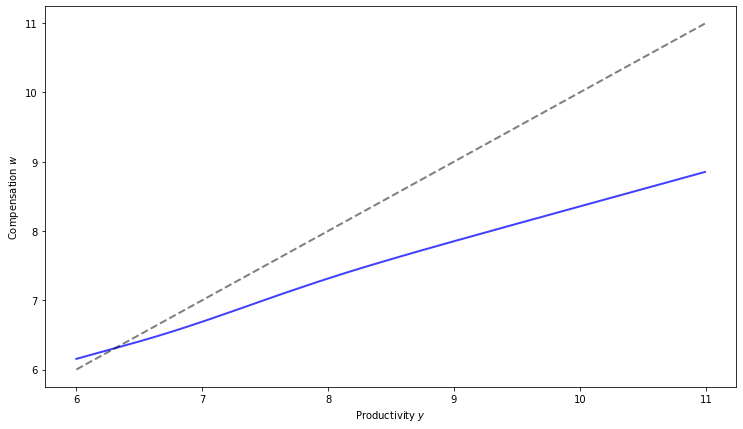

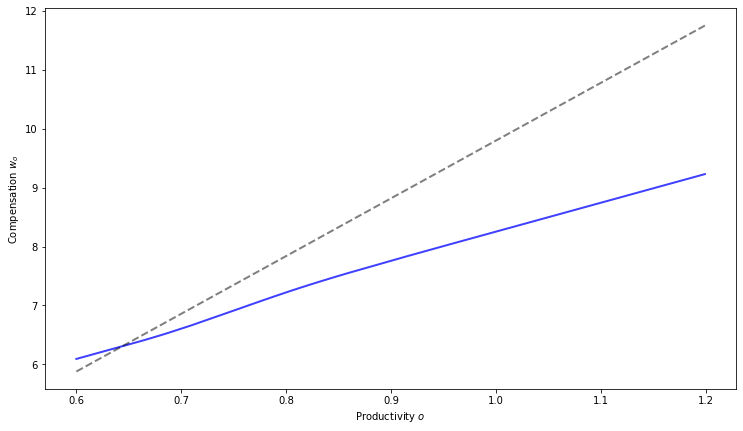

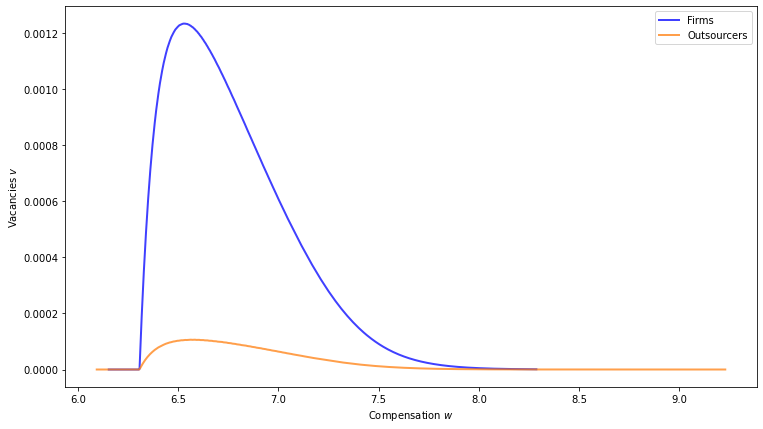

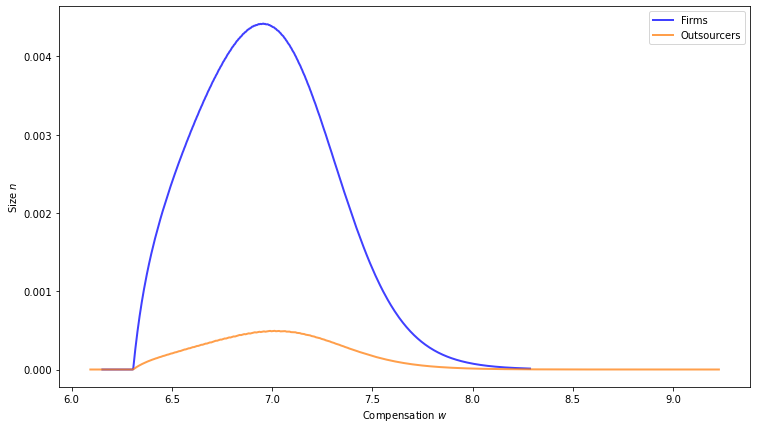

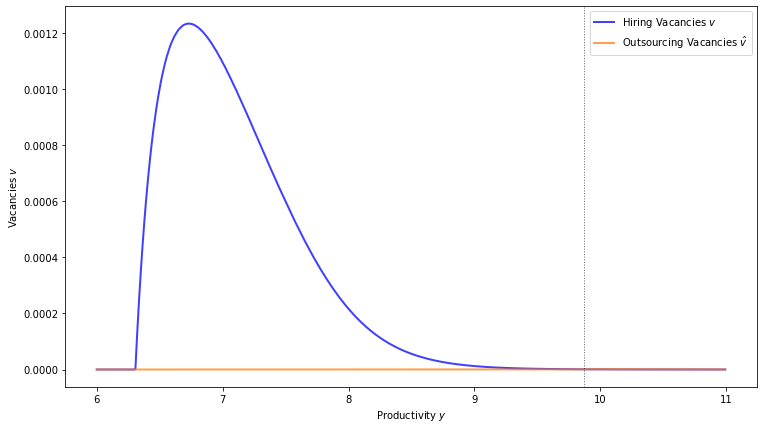

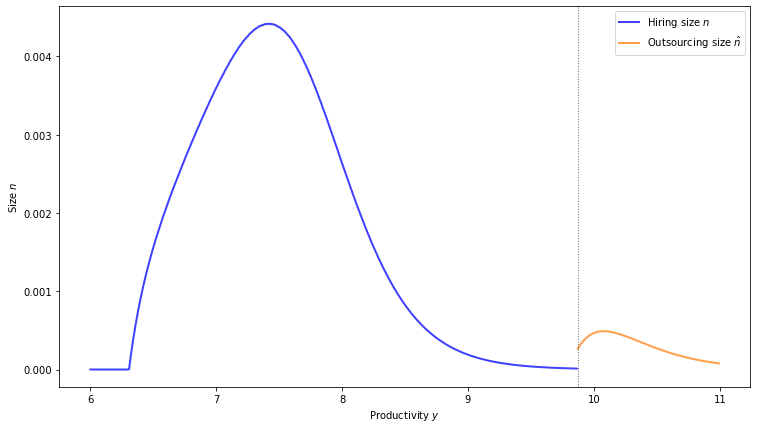

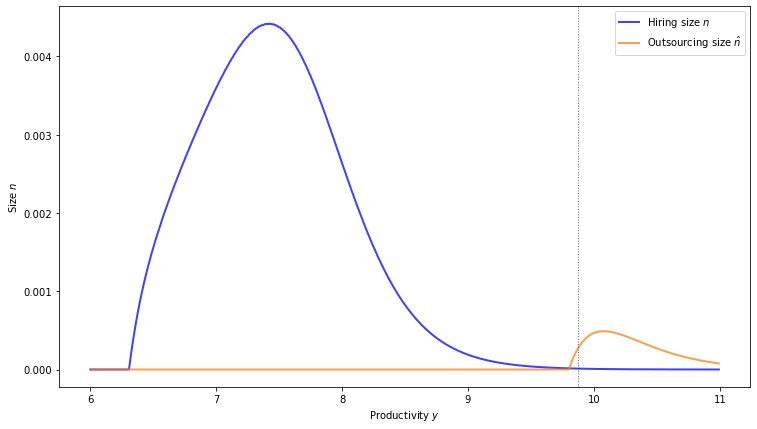

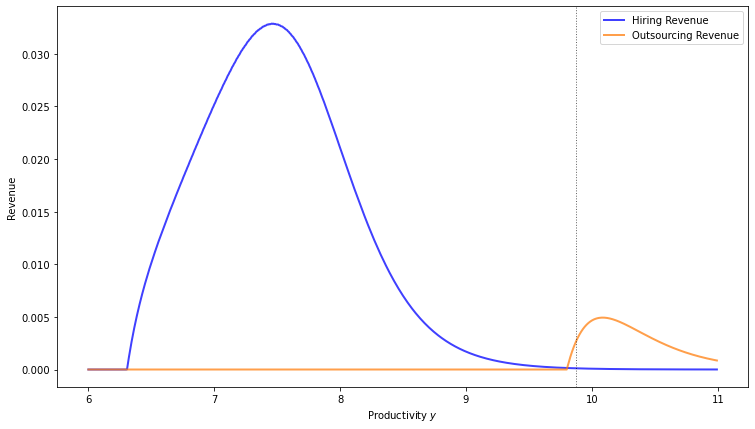

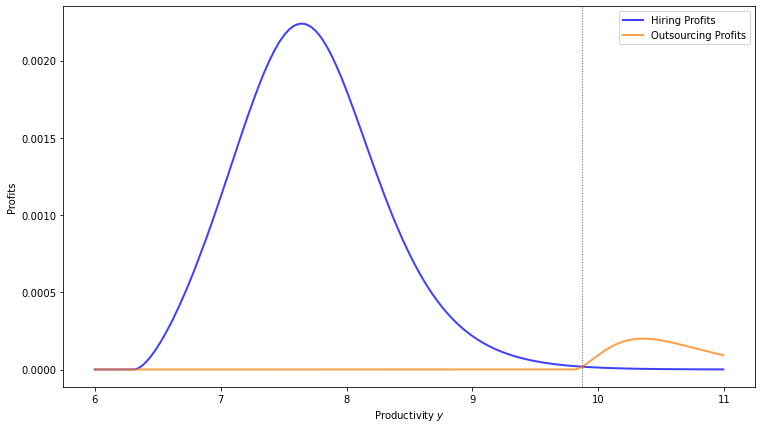

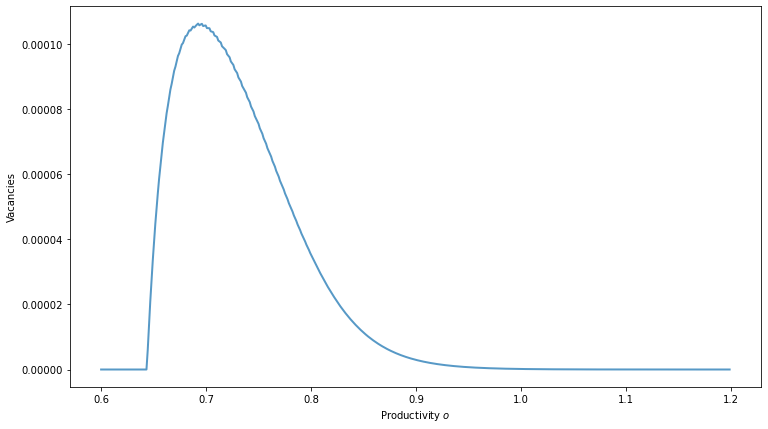

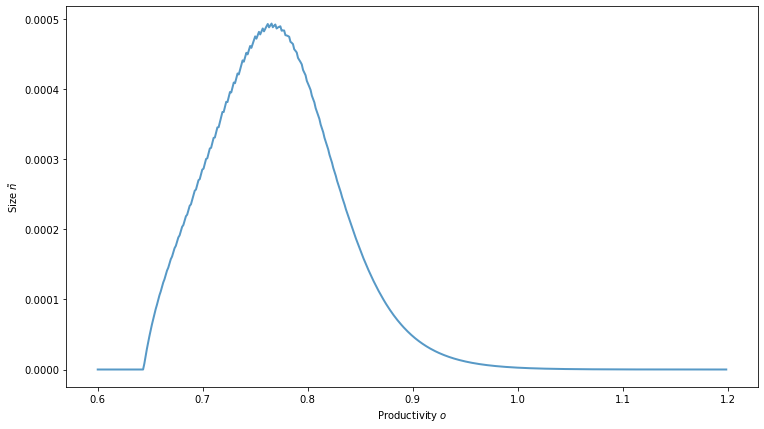

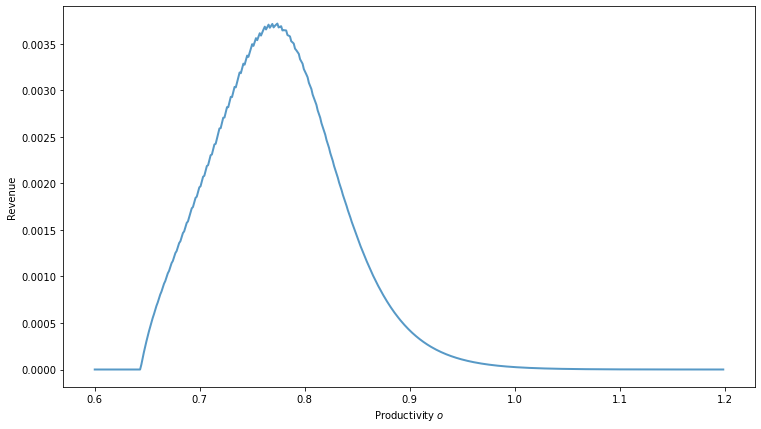

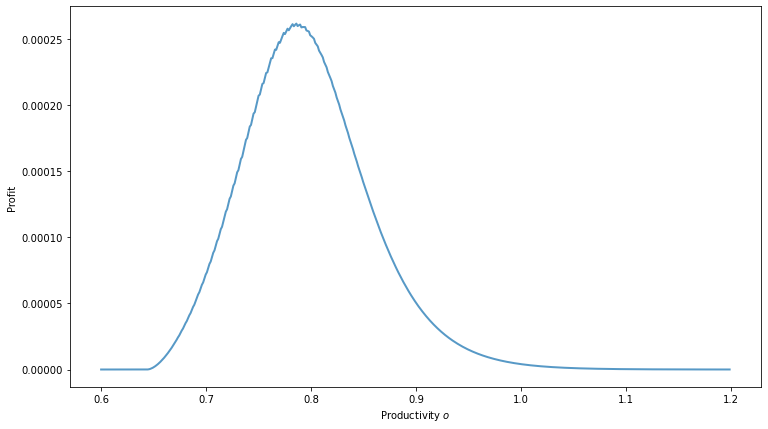

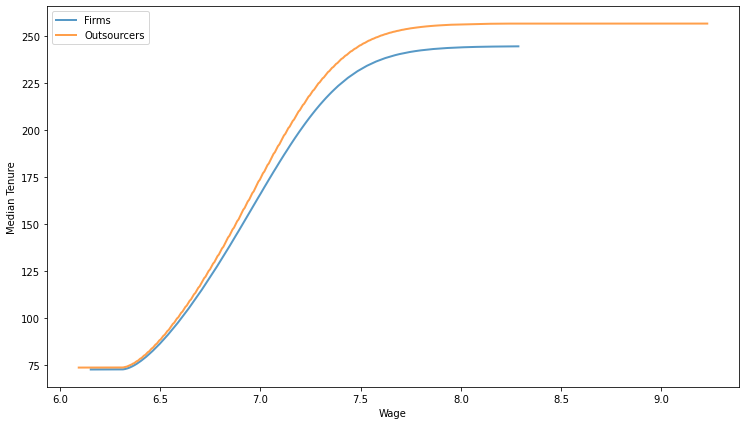

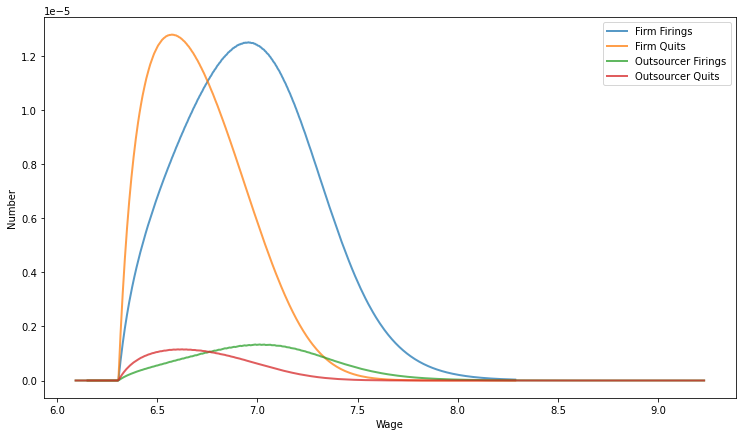

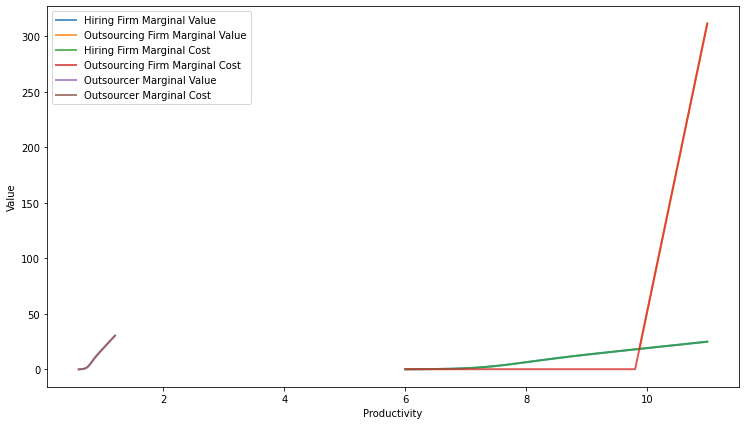

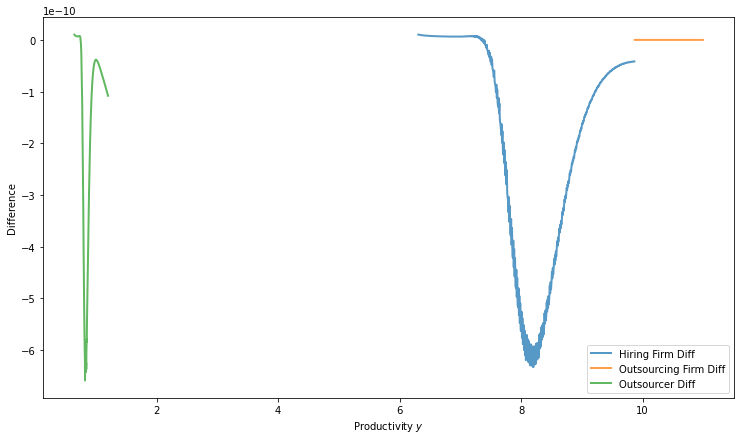

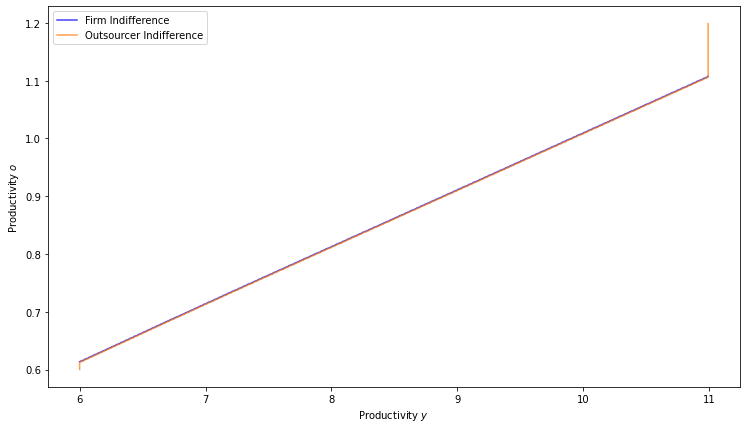

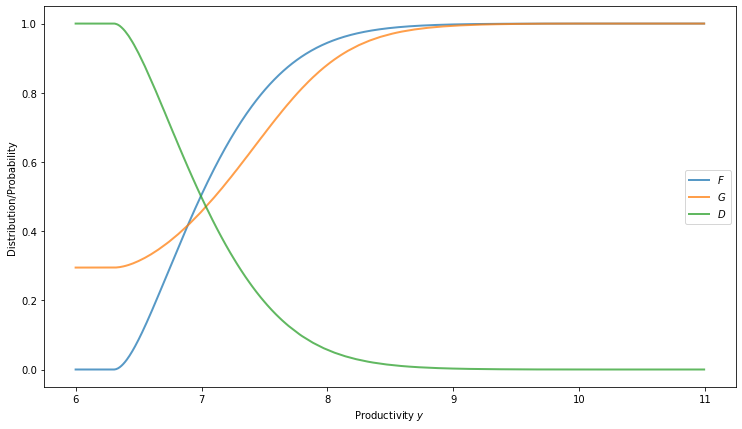

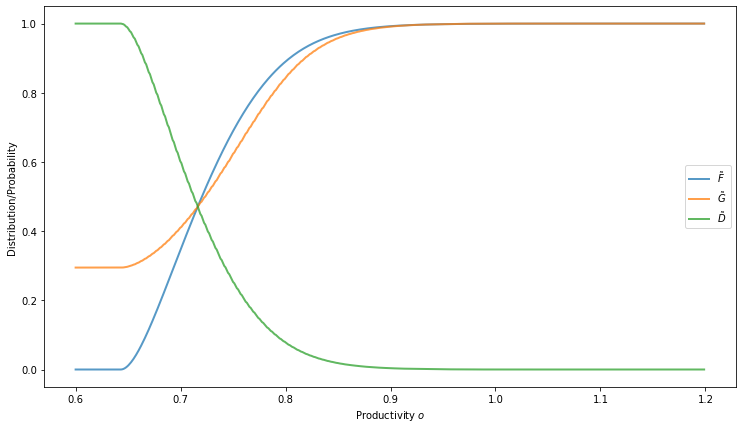

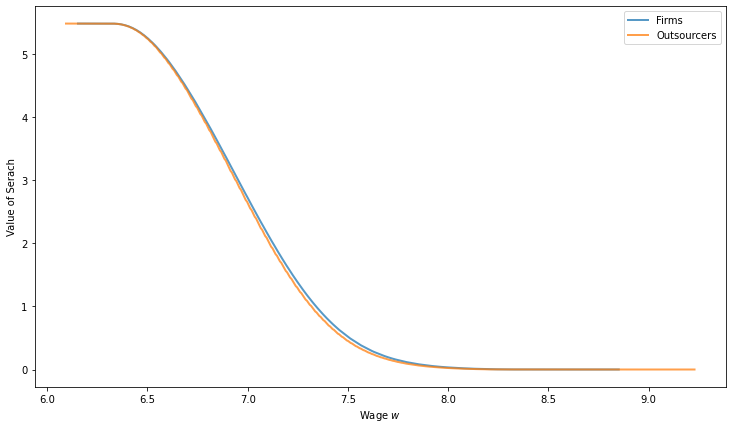

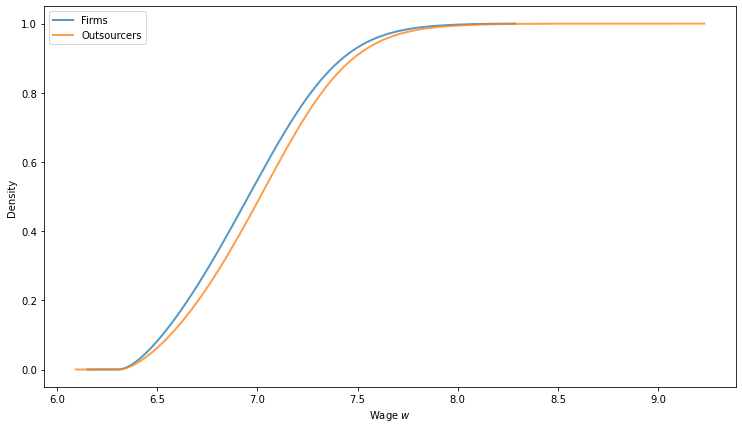

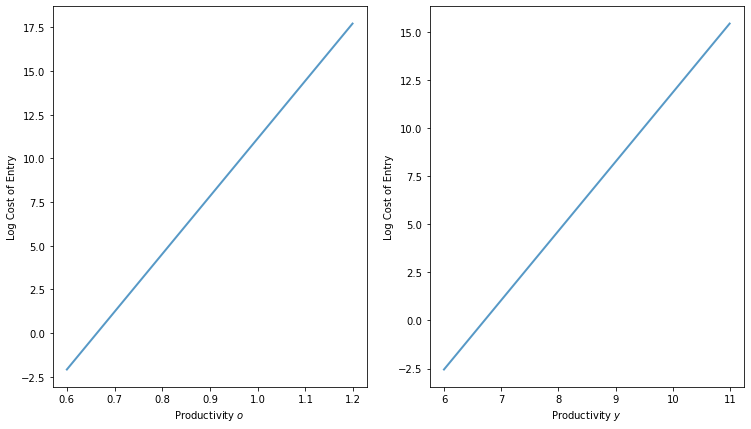

In [5]:
# High Calibration guess
# Chosen arbitrarily, unique to high ed
y_min = 6.0
y_max = 11.0
o_min = 0.6
o_max = 1.2

chosen_h = [eta, eta_o, alpha, y_min, y_max, y_grid_size, o_min, o_max, o_grid_size, gamma, gamma_o, hp]

# Get parameters that don't change and moments to match
fixed_parameters, match = get_moments(values_h, chosen_h)

# Calibrate

# Get iteration details for each calibration loop
tol = 1e-3
max_iter = 15
tol_i = 1e-6
max_iter_i = 1e5
slow_i = 1e-1
# slow_i = 5e-2

iter_details = tol, max_iter, tol_i, max_iter_i, slow_i

# Get initial guess for allocations and prices
v_grid_0 = np.ones(y_grid_size) * 0.9
n_grid_0 = np.ones(y_grid_size) * 0.9
v_hat_grid_0 = np.ones(y_grid_size) * 0.9
n_hat_grid_0 = np.ones(y_grid_size) * 0.9
v_o_grid_0 = np.ones(o_grid_size) * 0.9
n_o_grid_0 = np.ones(o_grid_size) * 0.9
y_hat_0 = y_max
R_grid_0 = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
R_o_grid_0 = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)

guess_0 = (v_grid_0, v_hat_grid_0, v_o_grid_0, n_grid_0, n_hat_grid_0, n_o_grid_0, y_hat_0, R_grid_0, R_o_grid_0)
p_1_0, p_2_0 = 9, 10

c_0_guess = -24.162
c_1_guess = 3.602
c_o_0_guess = -21.930
c_o_1_guess = 33.078
xi_guess = 0.0735
phi_guess = 0.0636
b_guess = 1.220

# These parameters were fixed before calibration 
# (don't keep calibration grid size, use finer grid for results, see below)
(B, delta, delta_o, delta_hat, eta, eta_o, alpha, y_min, y_max,
 _, o_min, o_max, _, gamma, gamma_o, hp) = fixed_parameters

y_grid_size = 700
o_grid_size = 500

y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint=False)
o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint=False)

c_grid = np.exp(c_0_guess + y_grid * c_1_guess)
c_o_grid = np.exp(c_o_0_guess + o_grid * c_o_1_guess)
xi = xi_guess
phi = phi_guess
b = b_guess

# Record initial guesses
v_grid_0 = np.ones(y_grid_size) * 0.9
n_grid_0 = np.ones(y_grid_size) * 0.9
v_hat_grid_0 = np.ones(y_grid_size) * 0.9
n_hat_grid_0 = np.ones(y_grid_size) * 0.9
v_o_grid_0 = np.ones(o_grid_size) * 0.9
n_o_grid_0 = np.ones(o_grid_size) * 0.9
y_hat_0 = y_max
R_grid_0 = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
R_o_grid_0 = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)

guess_0 = (v_grid_0, v_hat_grid_0, v_o_grid_0, n_grid_0, n_hat_grid_0, n_o_grid_0, y_hat_0, R_grid_0, R_o_grid_0)

tol = 1e-4
max_iter = 25
tol_i = 1e-8
max_iter_i = 1e5
slow_i = 1e-1
print_skip = 5
ps = 1e4
verbose = True

ooj = OutsourcingOnJob(
    B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi, alpha,
    y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
    gamma, gamma_o, c_grid, c_o_grid, hp
)

(v_grid, v_hat_grid, v_o_grid, n_grid,
 n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = find_p(
    ooj, guess_0, p_1_0, p_2_0, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)

solution = (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

list_facts(ooj, solution, compare=False, values=values_h)

graph_results(ooj, solution, save=False)

In [7]:
_, _, QD_QS_ED, make_grids, find_y_i, _, _, _, _, _, _, _, ell = operator_factory(ooj)

(theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
 Gamma_grid, Gamma_o_grid, w_grid, w_o_grid, nu) = make_grids(
    v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
)

xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
rm, rm_o = ooj.rm, ooj.rm_o

y_i = find_y_i(y_hat)

n = np.sum(n_grid[:y_i] * rm)
n_o = np.sum(n_o_grid * rm_o)

zeta = n_o / (n_o + n)
ee_h = np.sum(n_grid[:y_i] * xi_bar * ell(theta) * D_grid[:y_i] * rm) / n
ee_o = np.sum(n_o_grid * xi_bar_o * ell(theta) * D_o_grid * rm_o) / n_o
ee = ((1 - zeta) * ee_h + zeta * ee_o)

ee

0.0020374406979339296